In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Downloading files

In [10]:
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/data_downloaders/download_calcagno.sh"
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/preprocessors/preprocess_calcagno.py"
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/utils/mean_margin.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1445  100  1445    0     0  10958      0 --:--:-- --:--:-- --:--:-- 10946
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5339  100  5339    0     0  46404      0 --:--:-- --:--:-- --:--:-- 46833
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   987  100   987    0     0   8067      0 --:--:-- --:--:-- --:--:--  8090


In [ ]:
!chmod +x download_calcagno.sh

In [ ]:
!./download_calcagno.sh data

==> Downloading Zenodo ZIP...
--2025-07-21 02:18:50--  https://zenodo.org/records/7055957/files/Nikatag/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.48.194, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7972177 (7.6M) [application/octet-stream]
Saving to: ‘/content/data/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping_zenodo.zip’

/content/data/Singl 100%[===================>]   7.60M  7.74MB/s    in 1.0s    

2025-07-21 02:18:51 (7.74 MB/s) - ‘/content/data/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping_zenodo.zip’ saved [7972177/7972177]

==> Unzipping Zenodo ZIP...
Archive:  /content/data/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping_zenodo.zip
8f7e1d14be5fa874c92bff1d8cb282eb9aa613fd
   creating: /content/data/Nikatag-Single-Ce

## scPSS

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install git+https://github.com/SaminRK/scPSS.git

  Cloning https://github.com/SaminRK/scPSS.git to /tmp/pip-req-build-yoev9v_2
  Running command git clone --filter=blob:none --quiet https://github.com/SaminRK/scPSS.git /tmp/pip-req-build-yoev9v_2
  Resolved https://github.com/SaminRK/scPSS.git to commit c16c71713e6a618ed6196b83b1dc3daa30838e1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.0 MB/s eta 0:00:00
  Created wheel for scPSS: f

In [ ]:
DATA_DIR = 'data'

## Subsample uniformly

In [44]:
## Modify to the directory where outputs should be stored
OUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/outputs"
metrics_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-metrics.csv"
results_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-results.csv"

In [ ]:
import os
os.makedirs(OUT_PATH, exist_ok=True)

In [ ]:
import scanpy as sc
import time
import sys
from preprocess_calcagno import get_preprocessed_anndata


with open(metrics_csv_path, 'w') as f:
    print('sample_size', 'seed', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'aupr', 'time', sep=',', file=f, flush=True)
    for sample_size in (100, 200, 500, 1_000, 2_000, 5_000, 10_000, 14_779):
        for ri in range(25):
            print("RUN", ri)
            ad_full = get_preprocessed_anndata('ref_0_que_1-7', DATA_DIR)
            ad = sc.pp.subsample(ad_full.copy(), n_obs=sample_size, random_state=ri * 100, copy=True)
            print(ad)

            start = time.perf_counter()

            reference_samples = list(ad.obs[ad.obs['dataset'] == 'reference']['sample'].unique())
            query_samples = list(ad.obs[ad.obs['dataset'] == 'query']['sample'].unique())

            from scpss import scPSS

            scpss = scPSS(ad, 'sample', reference_samples, query_samples)
            scpss.harmony_integrate()
            params = scpss.find_optimal_parameters()
            scpss.set_distance_and_condition()

            ad_que = scpss.adata[scpss.query_mask]

            true_labels = ad_que.obs['zone'].isin(['BZ1', 'BZ2']).to_numpy()
            predicted_labels = ad_que.obs['scpss_condition'].isin(['pathological']).to_numpy()
            predicted_scores = ad_que.obs['scpss_scores']

            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1-score:", f1)

            from sklearn.metrics import roc_auc_score, average_precision_score
            import matplotlib.pyplot as plt
            from sklearn.metrics import roc_curve, precision_recall_curve

            y_true = true_labels
            y_scores = predicted_scores

            # Calculate AUC
            auc = roc_auc_score(y_true, y_scores)
            print("AUC:", auc)

            # Calculate AUPR
            aupr = average_precision_score(y_true, y_scores)
            print("AUPR:", aupr)

            end = time.perf_counter()

            print(sample_size, ri*100, accuracy, precision, recall, f1, auc, aupr, f'{end - start:.4f}', sep=',',file=f, flush=True)


RUN 0


2025-07-20 08:13:18,617 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:13:18,629 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:13:18,638 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:13:18,672 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:13:18,689 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:13:18,703 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:13:18,718 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6375
Precision: 0.6410256410256411
Recall: 0.625
F1-score: 0.6329113924050633
AUC: 0.69625
AUPR: 0.6305877523113399
RUN 1


2025-07-20 08:14:18,007 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:14:18,023 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:14:18,025 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:14:18,050 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:14:18,066 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:14:18,084 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:14:18,104 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:14:18,118 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:14:18,129 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:14:18,137 - 

AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.696969696969697
Precision: 0.575
Recall: 0.8846153846153846
F1-score: 0.696969696969697
AUC: 0.8625
AUPR: 0.844291989854099
RUN 2


2025-07-20 08:15:17,610 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:15:17,625 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:15:17,629 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:15:17,645 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:15:17,661 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:15:17,675 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:15:17,692 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7464788732394366
Precision: 0.7333333333333333
Recall: 0.6875
F1-score: 0.7096774193548387
AUC: 0.8181089743589745
AUPR: 0.7575331442210592
RUN 3


2025-07-20 08:16:16,874 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:16:16,886 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:16:16,890 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:16:16,910 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:16:16,928 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:16:16,941 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:16:16,953 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:16:16,966 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:16:16,978 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.76
Precision: 0.6944444444444444
Recall: 0.78125
F1-score: 0.7352941176470589
AUC: 0.8786337209302326
AUPR: 0.8377779113315184
RUN 4


2025-07-20 08:17:16,650 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:17:16,666 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:17:16,669 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:17:16,693 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:17:16,712 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:17:16,726 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:17:16,740 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6585365853658537
Precision: 0.5576923076923077
Recall: 0.8529411764705882
F1-score: 0.6744186046511628
AUC: 0.7334558823529411
AUPR: 0.6178541834257544
RUN 5


2025-07-20 08:18:15,833 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:18:15,887 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:18:15,888 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:18:15,908 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:18:15,924 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:18:15,935 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:18:15,945 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:18:15,954 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7625
Precision: 0.8181818181818182
Recall: 0.5454545454545454
F1-score: 0.6545454545454545
AUC: 0.8536428110896196
AUPR: 0.7207236359956899
RUN 6


2025-07-20 08:19:15,547 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:19:15,670 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:19:15,671 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:19:15,697 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:19:15,707 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:19:15,716 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:19:15,728 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7662337662337663
Precision: 0.6851851851851852
Recall: 0.9736842105263158
F1-score: 0.8043478260869565
AUC: 0.8582995951417004
AUPR: 0.8180756000619096
RUN 7


2025-07-20 08:20:19,057 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:20:19,073 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:20:19,077 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:20:19,118 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:20:19,136 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:20:19,152 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:20:19,166 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7
Precision: 0.7368421052631579
Recall: 0.6666666666666666
F1-score: 0.7
AUC: 0.7819548872180451
AUPR: 0.7321745935994556
RUN 8


2025-07-20 08:21:24,295 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:21:24,415 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:21:24,417 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:21:24,431 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:21:24,446 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:21:24,456 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:21:24,465 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:21:24,474 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6329113924050633
Precision: 0.5384615384615384
Recall: 0.65625
F1-score: 0.5915492957746479
AUC: 0.6609042553191489
AUPR: 0.4837037018632103
RUN 9


2025-07-20 08:22:25,109 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:22:25,124 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:22:25,127 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:22:25,151 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:22:25,171 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:22:25,190 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:22:25,207 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:22:25,224 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7341772151898734
Precision: 0.65
Recall: 0.7878787878787878
F1-score: 0.7123287671232876
AUC: 0.7595520421607378
AUPR: 0.59948248304093
RUN 10


2025-07-20 08:23:26,076 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:23:26,088 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:23:26,096 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:23:26,118 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:23:26,133 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:23:26,145 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:23:26,160 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:23:26,173 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7380952380952381
Precision: 0.7
Recall: 0.8333333333333334
F1-score: 0.7608695652173914
AUC: 0.7619047619047619
AUPR: 0.6942209924374552
RUN 11


2025-07-20 08:24:27,666 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:24:27,787 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:24:27,788 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:24:27,807 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:24:27,817 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:24:27,826 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:24:27,835 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:24:27,843 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:24:27,851 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:24:27,863 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7631578947368421
Precision: 0.7586206896551724
Recall: 0.6666666666666666
F1-score: 0.7096774193548387
AUC: 0.8632840028188865
AUPR: 0.8225267707794641
RUN 12


2025-07-20 08:25:29,621 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:25:29,638 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:25:29,642 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:25:29,661 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:25:29,679 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:25:29,691 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:25:29,704 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:25:29,718 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6746987951807228
Precision: 0.6346153846153846
Recall: 0.8048780487804879
F1-score: 0.7096774193548387
AUC: 0.6811846689895471
AUPR: 0.5679287147651326
RUN 13


2025-07-20 08:26:32,009 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:26:32,107 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:26:32,109 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:26:32,131 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:26:32,140 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:26:32,154 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:26:32,162 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8026315789473685
Precision: 0.8055555555555556
Recall: 0.7837837837837838
F1-score: 0.7945205479452054
AUC: 0.8724878724878725
AUPR: 0.8784237836616513
RUN 14


2025-07-20 08:27:35,442 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:27:35,458 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:27:35,461 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:27:35,480 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:27:35,499 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:27:35,515 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:27:35,531 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:27:35,549 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:27:35,562 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:27:35,572 - 

AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7721518987341772
Precision: 0.8181818181818182
Recall: 0.6923076923076923
F1-score: 0.75
AUC: 0.8641025641025641
AUPR: 0.8147667264037286
RUN 15


2025-07-20 08:28:37,776 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:28:37,894 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:28:37,896 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:28:37,912 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:28:37,924 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:28:37,936 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:28:37,948 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:28:37,958 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7763157894736842
Precision: 0.8484848484848485
Recall: 0.7
F1-score: 0.7671232876712328
AUC: 0.80625
AUPR: 0.8597640990256887
RUN 16


2025-07-20 08:29:41,407 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:29:41,529 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:29:41,532 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:29:41,547 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:29:41,561 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:29:41,569 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:29:41,577 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:29:41,587 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7662337662337663
Precision: 0.75
Recall: 0.7894736842105263
F1-score: 0.7692307692307693
AUC: 0.8245614035087719
AUPR: 0.8412100744041894
RUN 17


2025-07-20 08:30:41,554 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:30:41,598 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:30:41,600 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:30:41,633 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:30:41,670 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:30:41,679 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:30:41,689 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8
Precision: 0.7647058823529411
Recall: 0.9069767441860465
F1-score: 0.8297872340425532
AUC: 0.8108108108108107
AUPR: 0.810954338324223
RUN 18


2025-07-20 08:31:41,174 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:31:41,192 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:31:41,195 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:31:41,213 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:31:41,234 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:31:41,247 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7236842105263158
Precision: 0.65
Recall: 0.7878787878787878
F1-score: 0.7123287671232876
AUC: 0.7730796335447498
AUPR: 0.6209089114534505
RUN 19


2025-07-20 08:32:40,905 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:32:41,011 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:32:41,017 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:32:41,041 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:32:41,052 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:32:41,063 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8356164383561644
Precision: 0.7857142857142857
Recall: 0.9166666666666666
F1-score: 0.8461538461538461
AUC: 0.8325825825825826
AUPR: 0.7848362125632665
RUN 20


2025-07-20 08:33:40,621 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:33:40,636 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:33:40,637 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:33:40,662 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:33:40,680 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:33:40,694 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7142857142857143
Precision: 0.7391304347826086
Recall: 0.7727272727272727
F1-score: 0.7555555555555555
AUC: 0.7734159779614325
AUPR: 0.8017685852185101
RUN 21


2025-07-20 08:34:40,462 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:34:40,583 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:34:40,585 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:34:40,603 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 08:34:40,614 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:34:40,627 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:34:40,637 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:34:40,646 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:34:40,655 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:34:40,666 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7692307692307693
Precision: 0.7575757575757576
Recall: 0.7142857142857143
F1-score: 0.7352941176470589
AUC: 0.8710963455149502
AUPR: 0.8807413450590548
RUN 22


2025-07-20 08:35:40,095 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:35:40,110 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:35:40,119 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:35:40,159 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:35:40,176 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:35:40,191 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:35:40,208 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7948717948717948
Precision: 0.7647058823529411
Recall: 0.7647058823529411
F1-score: 0.7647058823529411
AUC: 0.8589572192513368
AUPR: 0.8354716879214522
RUN 23


2025-07-20 08:36:39,345 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:36:39,465 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:36:39,467 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:36:39,482 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:36:39,497 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:36:39,506 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:36:39,517 - harmonypy - INFO - Iteration 5 of 10


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:36:39,529 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8309859154929577
Precision: 0.8205128205128205
Recall: 0.8648648648648649
F1-score: 0.8421052631578947
AUC: 0.9006359300476947
AUPR: 0.9084653131052887
RUN 24


2025-07-20 08:37:39,113 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:37:39,129 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:37:39,132 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:37:39,152 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:37:39,179 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:37:39,201 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:37:39,217 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:37:39,231 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:37:39,243 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


AnnData object with n_obs × n_vars = 100 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.5972222222222222
Precision: 0.5263157894736842
Recall: 0.6451612903225806
F1-score: 0.5797101449275363
AUC: 0.7482297403619197
AUPR: 0.7721856520813156
RUN 0
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id

2025-07-20 08:38:38,511 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:38:38,630 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:38:38,632 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:38:38,664 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:38:38,680 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:38:38,693 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:38:38,708 - harmonypy - INFO - Iteration 5 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:38:38,723 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7300613496932515
Precision: 0.68
Recall: 0.85
F1-score: 0.7555555555555555
AUC: 0.8152108433734939
AUPR: 0.8127412187009901
RUN 1
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:39:42,444 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:39:42,563 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:39:42,565 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:39:42,593 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:39:42,614 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:39:42,628 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 08:39:42,644 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:39:42,655 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:39:42,666 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:39:42,676 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:39:42,686 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:39:42,696 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:39:42,705 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7021276595744681
Precision: 0.6212121212121212
Recall: 0.7068965517241379
F1-score: 0.6612903225806451
AUC: 0.8236393851267138
AUPR: 0.7972836083804156
RUN 2
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:40:46,944 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:40:47,070 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:40:47,071 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:40:47,104 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:40:47,127 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:40:47,142 - harmonypy - INFO - Iteration 4 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:40:47,154 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:40:47,168 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:40:47,181 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7651006711409396
Precision: 0.7014925373134329
Recall: 0.7580645161290323
F1-score: 0.7286821705426356
AUC: 0.8607712272895811
AUPR: 0.8238844748632385
RUN 3
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:41:47,019 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:41:47,140 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:41:47,144 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:41:47,175 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:41:47,192 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:41:47,223 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:41:47,241 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:41:47,253 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:41:47,275 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:41:47,285 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:41:47,298 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:41:47,311 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:41:47,323 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7735849056603774
Precision: 0.7666666666666667
Recall: 0.8214285714285714
F1-score: 0.7931034482758621
AUC: 0.8971428571428572
AUPR: 0.9266444411997895
RUN 4
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:42:47,136 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:42:47,258 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:42:47,259 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:42:47,291 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:42:47,315 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:42:47,334 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:42:47,346 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:42:47,357 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:42:47,367 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:42:47,376 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:42:47,385 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8
Precision: 0.7058823529411765
Recall: 0.9230769230769231
F1-score: 0.8
AUC: 0.9002714932126697
AUPR: 0.87878160931914
RUN 5
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:43:47,277 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:43:47,396 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:43:47,401 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:43:47,433 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:43:47,454 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:43:47,470 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 08:43:47,485 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:43:47,499 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:43:47,513 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:43:47,524 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8092105263157895
Precision: 0.7638888888888888
Recall: 0.8208955223880597
F1-score: 0.7913669064748201
AUC: 0.8988586479367866
AUPR: 0.8842841748049297
RUN 6
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:44:47,629 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:44:47,667 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:44:47,674 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:44:47,724 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:44:47,764 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:44:47,778 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:44:47,795 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:44:47,807 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:44:47,819 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10


✅ PCA Complete.


2025-07-20 08:44:47,830 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:44:47,843 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.78
Precision: 0.7875
Recall: 0.7974683544303798
F1-score: 0.7924528301886793
AUC: 0.8855410946692815
AUPR: 0.8702292980929256
RUN 7
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:45:48,866 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:45:48,990 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:45:48,993 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:45:49,025 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:45:49,045 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:45:49,062 - harmonypy - INFO - Iteration 4 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:45:49,078 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:45:49,090 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:45:49,103 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:45:49,113 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:45:49,123 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:45:49,134 - harmonypy - INFO - Converged after 9 iterations
INFO:harmonypy:Converged after 9 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7973856209150327
Precision: 0.788235294117647
Recall: 0.8375
F1-score: 0.8121212121212121
AUC: 0.898972602739726
AUPR: 0.9089056954408754
RUN 8
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:46:51,748 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:46:51,868 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:46:51,871 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:46:51,902 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:46:51,927 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:46:51,952 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:46:51,966 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:46:51,978 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:46:51,993 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:46:52,005 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:46:52,016 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:46:52,026 - harmonypy - INFO - Converged after 9 iterations
INFO:harmonypy:Converged after 9 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7341772151898734
Precision: 0.6962025316455697
Recall: 0.7534246575342466
F1-score: 0.7236842105263158
AUC: 0.8340048348106366
AUPR: 0.7857344739288624
RUN 9
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:47:55,923 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:47:56,048 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:47:56,050 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:47:56,073 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:47:56,101 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:47:56,122 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:47:56,138 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:47:56,154 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:47:56,167 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:47:56,183 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:47:56,205 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:47:56,224 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:47:56,236 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8089171974522293
Precision: 0.726027397260274
Recall: 0.8412698412698413
F1-score: 0.7794117647058824
AUC: 0.9118541033434651
AUPR: 0.8991885204523928
RUN 10
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:48:56,834 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:48:56,881 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:48:56,882 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:48:56,925 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:48:56,952 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:48:56,969 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:48:56,984 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:48:57,003 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:48:57,015 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7239263803680982
Precision: 0.6907216494845361
Recall: 0.8170731707317073
F1-score: 0.7486033519553073
AUC: 0.8318277627220716
AUPR: 0.8289696606232182
RUN 11
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:49:57,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:49:57,246 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:49:57,247 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:49:57,278 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:49:57,308 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:49:57,325 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:49:57,337 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:49:57,346 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:49:57,359 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7870967741935484
Precision: 0.8387096774193549
Recall: 0.6933333333333334
F1-score: 0.7591240875912408
AUC: 0.8706666666666666
AUPR: 0.8547348826543834
RUN 12
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:50:57,851 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:50:57,964 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:50:57,968 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:50:57,989 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:50:58,004 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:50:58,034 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 08:50:58,054 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:50:58,071 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:50:58,088 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:50:58,100 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:50:58,112 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:50:58,131 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:50:58,140 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6973684210526315
Precision: 0.7058823529411765
Recall: 0.6486486486486487
F1-score: 0.676056338028169
AUC: 0.7486139986139986
AUPR: 0.6363737230109705
RUN 13
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:51:58,096 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:51:58,221 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:51:58,223 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:51:58,256 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:51:58,287 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:51:58,304 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:51:58,317 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:51:58,333 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:51:58,345 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:51:58,358 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:51:58,371 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.802547770700637
Precision: 0.7804878048780488
Recall: 0.8311688311688312
F1-score: 0.8050314465408805
AUC: 0.885551948051948
AUPR: 0.8976924250050016
RUN 14
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:52:58,743 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:52:58,815 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:52:58,818 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:52:58,867 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:52:58,885 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:52:58,904 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:52:58,921 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:52:58,934 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10


✅ PCA Complete.


2025-07-20 08:52:58,948 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:52:58,961 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:52:58,974 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.803680981595092
Precision: 0.7922077922077922
Recall: 0.7922077922077922
F1-score: 0.7922077922077922
AUC: 0.8986710963455149
AUPR: 0.9022489917158574
RUN 15
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:53:58,623 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:53:58,740 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:53:58,742 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:53:58,774 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:53:58,802 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:53:58,824 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:53:58,843 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:53:58,854 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:53:58,865 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:53:58,880 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:53:58,892 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7516778523489933
Precision: 0.8035714285714286
Recall: 0.6338028169014085
F1-score: 0.7086614173228346
AUC: 0.8457927049476344
AUPR: 0.8420043320357882
RUN 16
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:54:58,868 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:54:58,990 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:54:58,992 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:54:59,015 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:54:59,040 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:54:59,067 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:54:59,084 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:54:59,095 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:54:59,110 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8053691275167785
Precision: 0.7560975609756098
Recall: 0.8732394366197183
F1-score: 0.8104575163398693
AUC: 0.8847959552184905
AUPR: 0.8728989671125763
RUN 17
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:55:58,399 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:55:58,473 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:55:58,475 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:55:58,508 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:55:58,529 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:55:58,544 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:55:58,557 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:55:58,573 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:55:58,588 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8227848101265823
Precision: 0.8210526315789474
Recall: 0.8764044943820225
F1-score: 0.8478260869565217
AUC: 0.903761602344895
AUPR: 0.9244172638562608
RUN 18
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:56:58,563 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:56:58,682 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:56:58,684 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:56:58,715 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:56:58,732 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:56:58,747 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:56:58,759 - harmonypy - INFO - Iteration 5 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:56:58,771 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:56:58,782 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:56:58,795 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:56:58,806 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:56:58,816 - harmonypy - INFO - Converged after 9 iterations
INFO:harmonypy:Converged after 9 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7484276729559748
Precision: 0.6534653465346535
Recall: 0.9295774647887324
F1-score: 0.7674418604651163
AUC: 0.8697183098591549
AUPR: 0.8482730891247096
RUN 19
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:57:58,440 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:57:58,564 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:57:58,565 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:57:58,596 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:57:58,618 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:57:58,633 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 08:57:58,650 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:57:58,667 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:57:58,680 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:57:58,696 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:57:58,712 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:57:58,724 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:57:58,736 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8
Precision: 0.7875
Recall: 0.8181818181818182
F1-score: 0.802547770700637
AUC: 0.881951381951382
AUPR: 0.8859065224005935
RUN 20
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:58:58,420 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:58:58,541 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:58:58,543 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:58:58,572 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:58:58,595 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 08:58:58,614 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 08:58:58,635 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:58:58,650 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:58:58,661 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:58:58,672 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:58:58,683 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:58:58,693 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:58:58,704 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.810126582278481
Precision: 0.8181818181818182
Recall: 0.8372093023255814
F1-score: 0.8275862068965517
AUC: 0.8696705426356589
AUPR: 0.8939612079525283
RUN 21
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 08:59:58,449 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 08:59:58,572 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 08:59:58,576 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 08:59:58,607 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 08:59:58,632 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10


✅ PCA Complete.


2025-07-20 08:59:58,652 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 08:59:58,662 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 08:59:58,678 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 08:59:58,691 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 08:59:58,701 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 08:59:58,712 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 08:59:58,722 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 08:59:58,735 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8266666666666667
Precision: 0.8194444444444444
Recall: 0.8194444444444444
F1-score: 0.8194444444444444
AUC: 0.900462962962963
AUPR: 0.9132439750828365
RUN 22
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:00:59,000 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:00:59,077 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:00:59,086 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:00:59,110 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:00:59,142 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:00:59,156 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:00:59,177 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:00:59,189 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10


✅ PCA Complete.


2025-07-20 09:00:59,200 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:00:59,214 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:00:59,224 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:00:59,234 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:00:59,244 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7961783439490446
Precision: 0.847457627118644
Recall: 0.684931506849315
F1-score: 0.7575757575757576
AUC: 0.853392041748206
AUPR: 0.8303551496563666
RUN 23
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:01:59,072 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:01:59,116 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:01:59,118 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:01:59,155 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:01:59,179 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:01:59,193 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:01:59,204 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:01:59,217 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:01:59,230 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:01:59,242 - 

✅ PCA Complete.
✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7777777777777778
Precision: 0.7159090909090909
Recall: 0.875
F1-score: 0.7875
AUC: 0.8887174211248285
AUPR: 0.8831011782355378
RUN 24
AnnData object with n_obs × n_vars = 200 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:02:59,393 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:02:59,526 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:02:59,528 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:02:59,550 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:02:59,569 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:02:59,583 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10


✅ PCA Complete.


2025-07-20 09:02:59,599 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:02:59,612 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:02:59,626 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:02:59,642 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:02:59,655 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:02:59,666 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:02:59,676 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7278911564625851
Precision: 0.7222222222222222
Recall: 0.7222222222222222
F1-score: 0.7222222222222222
AUC: 0.8353703703703703
AUPR: 0.8066634464618091
RUN 0
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:04:07,015 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:04:07,157 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:04:07,160 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:04:07,205 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:04:07,252 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:04:07,282 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:04:07,300 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:04:07,319 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:04:07,337 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:04:07,356 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:04:07,375 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:04:07,397 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:04:07,414 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7974025974025974
Precision: 0.7641921397379913
Recall: 0.8793969849246231
F1-score: 0.8177570093457944
AUC: 0.8940671097422597
AUPR: 0.9010975778016656
RUN 1
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:05:09,378 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:05:09,517 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:05:09,519 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:05:09,570 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:05:09,611 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:05:09,639 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:05:09,662 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:05:09,682 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:05:09,700 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:05:09,718 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:05:09,736 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:05:09,753 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:05:09,771 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8233695652173914
Precision: 0.7580645161290323
Recall: 0.8757763975155279
F1-score: 0.8126801152737753
AUC: 0.9165541452876047
AUPR: 0.9128528854911251
RUN 2
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:06:12,073 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:06:12,208 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:06:12,210 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:06:12,257 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:06:12,303 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:06:12,333 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:06:12,361 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:06:12,388 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:06:12,412 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:06:12,426 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:06:12,441 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:06:12,458 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:06:12,477 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.825065274151436
Precision: 0.7475247524752475
Recall: 0.9041916167664671
F1-score: 0.8184281842818428
AUC: 0.9077123530716346
AUPR: 0.8797524827082441
RUN 3
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:07:16,573 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:07:16,708 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:07:16,710 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:07:16,759 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:07:16,797 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:07:16,827 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:07:16,864 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:07:16,893 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:07:16,915 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:07:16,941 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:07:16,960 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:07:16,981 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:07:16,998 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8363636363636363
Precision: 0.8351648351648352
Recall: 0.8216216216216217
F1-score: 0.8283378746594006
AUC: 0.9236216216216215
AUPR: 0.9276207784462053
RUN 4
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:08:18,207 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:08:18,346 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:08:18,348 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:08:18,394 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:08:18,441 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:08:18,479 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:08:18,504 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:08:18,524 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:08:18,548 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:08:18,573 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:08:18,590 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:08:18,607 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:08:18,625 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8142493638676844
Precision: 0.7647058823529411
Recall: 0.861878453038674
F1-score: 0.8103896103896104
AUC: 0.9255186073178359
AUPR: 0.925689849730817
RUN 5
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:09:19,220 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:09:19,363 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:09:19,365 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:09:19,419 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:09:19,466 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:09:19,490 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:09:19,510 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:09:19,531 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:09:19,549 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:09:19,568 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:09:19,585 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:09:19,600 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:09:19,617 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7941952506596306
Precision: 0.7659574468085106
Recall: 0.8089887640449438
F1-score: 0.7868852459016393
AUC: 0.8942646318966964
AUPR: 0.8898361366220103
RUN 6
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:10:22,831 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:10:22,976 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:10:22,979 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:10:23,027 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:10:23,075 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:10:23,103 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:10:23,141 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:10:23,164 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:10:23,184 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:10:23,201 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:10:23,219 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:10:23,240 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:10:23,262 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8211382113821138
Precision: 0.8306010928961749
Recall: 0.8128342245989305
F1-score: 0.8216216216216217
AUC: 0.9019216078039609
AUPR: 0.9122264515473892
RUN 7
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:11:28,570 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:11:28,715 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:11:28,717 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:11:28,765 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:11:28,796 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:11:28,819 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:11:28,842 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:11:28,867 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:11:28,892 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:11:28,911 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:11:28,931 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:11:28,961 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:11:28,979 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8176943699731903
Precision: 0.7692307692307693
Recall: 0.8670520231213873
F1-score: 0.8152173913043478
AUC: 0.9146242774566474
AUPR: 0.9093422867382108
RUN 8
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:12:32,172 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:12:32,312 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:12:32,314 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:12:32,365 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:12:32,414 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:12:32,459 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:12:32,493 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:12:32,511 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:12:32,530 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:12:32,544 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:12:32,566 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:12:32,582 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:12:32,599 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.817258883248731
Precision: 0.7929292929292929
Recall: 0.8351063829787234
F1-score: 0.8134715025906736
AUC: 0.9054430902706052
AUPR: 0.886175918341809
RUN 9
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:13:36,682 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:13:36,820 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:13:36,823 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:13:36,876 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:13:36,905 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:13:36,930 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:13:36,952 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:13:36,985 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:13:37,006 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:13:37,026 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:13:37,045 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:13:37,062 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:13:37,081 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7885117493472585
Precision: 0.7106598984771574
Recall: 0.8536585365853658
F1-score: 0.775623268698061
AUC: 0.9162490255039536
AUPR: 0.9162446296084125
RUN 10
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:14:42,589 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:14:42,732 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:14:42,735 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:14:42,782 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:14:42,828 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:14:42,878 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:14:42,902 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:14:42,920 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:14:42,939 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:14:42,964 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:14:42,983 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:14:42,999 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:14:43,020 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8075949367088607
Precision: 0.746606334841629
Recall: 0.8918918918918919
F1-score: 0.812807881773399
AUC: 0.8967567567567568
AUPR: 0.8788689105452431
RUN 11
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:15:46,100 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:15:46,241 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:15:46,243 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:15:46,291 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:15:46,332 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:15:46,359 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:15:46,378 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:15:46,400 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:15:46,423 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:15:46,440 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:15:46,473 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:15:46,494 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:15:46,517 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8020833333333334
Precision: 0.8536585365853658
Recall: 0.7291666666666666
F1-score: 0.7865168539325843
AUC: 0.9011773003472223
AUPR: 0.9041776790914322
RUN 12


2025-07-20 09:16:46,986 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'
✅ PCA Complete.


2025-07-20 09:16:47,126 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:16:47,129 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:16:47,176 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:16:47,223 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:16:47,265 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:16:47,286 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:16:47,307 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:16:47,324 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:16:47,350 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:16:47,369 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8070175438596491
Precision: 0.7707317073170732
Recall: 0.8404255319148937
F1-score: 0.8040712468193384
AUC: 0.8883482908137542
AUPR: 0.8896194379249401
RUN 13
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:17:48,360 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:17:48,503 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:17:48,506 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:17:48,556 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:17:48,606 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:17:48,639 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:17:48,666 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:17:48,694 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:17:48,734 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:17:48,757 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:17:48,777 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:17:48,794 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:17:48,812 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8151041666666666
Precision: 0.8313953488372093
Recall: 0.772972972972973
F1-score: 0.8011204481792717
AUC: 0.901480374847209
AUPR: 0.8995462832209519
RUN 14
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:18:50,765 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:18:50,886 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:18:50,889 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:18:50,935 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:18:50,982 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:18:51,011 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:18:51,036 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:18:51,055 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:18:51,075 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:18:51,094 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:18:51,111 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:18:51,127 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:18:51,149 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8363171355498721
Precision: 0.7912621359223301
Recall: 0.8858695652173914
F1-score: 0.8358974358974359
AUC: 0.915143877336694
AUPR: 0.9100689383144551
RUN 15
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:19:52,454 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:19:52,591 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:19:52,593 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:19:52,640 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:19:52,686 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:19:52,714 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:19:52,736 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:19:52,761 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:19:52,782 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:19:52,800 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:19:52,817 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:19:52,834 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:19:52,853 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8306878306878307
Precision: 0.8108108108108109
Recall: 0.8379888268156425
F1-score: 0.8241758241758241
AUC: 0.9075826057662614
AUPR: 0.9133569052749055
RUN 16
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:20:54,091 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:20:54,238 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:20:54,240 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:20:54,288 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:20:54,334 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:20:54,378 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:20:54,407 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:20:54,434 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:20:54,454 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:20:54,471 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:20:54,488 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:20:54,505 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:20:54,522 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8594164456233422
Precision: 0.8272251308900523
Recall: 0.8876404494382022
F1-score: 0.8563685636856369
AUC: 0.917734741121337
AUPR: 0.9015807315769654
RUN 17
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:21:55,478 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:21:55,619 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:21:55,621 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:21:55,667 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:21:55,702 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:21:55,735 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:21:55,759 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:21:55,787 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:21:55,805 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:21:55,820 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:21:55,836 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:21:55,852 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:21:55,869 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8641025641025641
Precision: 0.8974358974358975
Recall: 0.8413461538461539
F1-score: 0.8684863523573201
AUC: 0.9232618343195267
AUPR: 0.9267354683011624
RUN 18
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:22:58,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:22:58,497 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:22:58,499 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:22:58,546 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:22:58,593 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:22:58,620 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:22:58,663 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:22:58,687 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:22:58,708 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:22:58,732 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:22:58,750 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:22:58,770 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:22:58,792 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7906976744186046
Precision: 0.7711442786069652
Recall: 0.8157894736842105
F1-score: 0.7928388746803069
AUC: 0.9057173390328613
AUPR: 0.9079470196088099
RUN 19
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:24:00,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:24:00,405 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:24:00,408 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:24:00,455 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:24:00,505 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:24:00,537 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:24:00,563 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:24:00,586 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:24:00,601 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:24:00,618 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:24:00,638 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:24:00,655 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:24:00,672 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8051948051948052
Precision: 0.7676767676767676
Recall: 0.8397790055248618
F1-score: 0.8021108179419525
AUC: 0.9178041382298776
AUPR: 0.917236417733637
RUN 20
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:25:03,684 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:25:03,821 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:25:03,824 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:25:03,871 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:25:03,925 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:25:03,977 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:25:04,013 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:25:04,034 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:25:04,052 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:25:04,074 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:25:04,098 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:25:04,116 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:25:04,132 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7688311688311689
Precision: 0.7650273224043715
Recall: 0.7526881720430108
F1-score: 0.7588075880758808
AUC: 0.8864483708866915
AUPR: 0.8870509013729018
RUN 21
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:26:08,778 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:26:08,924 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:26:08,927 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:26:08,979 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:26:09,025 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:26:09,059 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:26:09,081 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:26:09,100 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:26:09,125 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:26:09,145 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:26:09,165 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:26:09,183 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:26:09,201 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8571428571428571
Precision: 0.8128342245989305
Recall: 0.8888888888888888
F1-score: 0.8491620111731844
AUC: 0.9156425685792581
AUPR: 0.9154298442604105
RUN 22
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:27:22,278 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:27:22,420 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:27:22,424 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:27:22,482 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:27:22,523 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:27:22,567 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:27:22,598 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:27:22,618 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:27:22,640 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:27:22,661 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:27:22,677 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:27:22,698 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:27:22,717 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8235294117647058
Precision: 0.8201058201058201
Recall: 0.8157894736842105
F1-score: 0.8179419525065963
AUC: 0.8949201361612987
AUPR: 0.9014894273821695
RUN 23
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:28:25,034 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:28:25,177 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:28:25,179 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:28:25,226 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:28:25,261 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:28:25,306 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:28:25,336 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:28:25,354 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:28:25,374 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:28:25,396 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:28:25,418 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Converged after 8 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7866323907455013
Precision: 0.726457399103139
Recall: 0.8804347826086957
F1-score: 0.7960687960687961
AUC: 0.9037910922587487
AUPR: 0.8929635107378129
RUN 24
AnnData object with n_obs × n_vars = 500 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:29:28,031 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:29:28,171 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:29:28,173 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:29:28,224 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10


✅ PCA Complete.


2025-07-20 09:29:28,274 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:29:28,304 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:29:28,332 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:29:28,354 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:29:28,375 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:29:28,394 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:29:28,413 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:29:28,429 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:29:28,446 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8467741935483871
Precision: 0.8363636363636363
Recall: 0.8214285714285714
F1-score: 0.8288288288288288
AUC: 0.9082341269841271
AUPR: 0.9002805298957068
RUN 0
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:30:31,169 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:30:31,356 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.


✅ PCA Complete.


2025-07-20 09:30:31,366 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:30:31,488 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:30:31,608 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:30:31,693 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:30:31,772 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:30:31,837 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:30:31,891 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:30:31,940 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:30:31,983 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:30:32,026 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:30:32,069 - harmonypy - 

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7953367875647669
Precision: 0.7218543046357616
Recall: 0.9108635097493036
F1-score: 0.8054187192118226
AUC: 0.9065267389236985
AUPR: 0.8954283561828029
RUN 1
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:31:34,174 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:31:34,362 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.


✅ PCA Complete.


2025-07-20 09:31:34,374 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:31:34,492 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:31:34,609 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:31:34,719 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:31:34,797 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:31:34,860 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:31:34,916 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:31:34,968 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:31:35,017 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:31:35,065 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:31:35,109 - harmonypy - 

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8322147651006712
Precision: 0.7845303867403315
Recall: 0.8580060422960725
F1-score: 0.8196248196248196
AUC: 0.9088401418626034
AUPR: 0.9017491758016939
RUN 2
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:32:38,790 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:32:38,981 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:32:38,989 - harmonypy - INFO - Iteration 1 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:32:39,133 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:32:39,259 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:32:39,355 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:32:39,422 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:32:39,478 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:32:39,531 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:32:39,573 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:32:39,625 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:32:39,667 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:32:39,716 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8188976377952756
Precision: 0.7715736040609137
Recall: 0.8636363636363636
F1-score: 0.8150134048257373
AUC: 0.9120218957871398
AUPR: 0.9017590211467271
RUN 3
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:33:46,682 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:33:46,858 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:33:46,868 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:33:46,990 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:33:47,106 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:33:47,222 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:33:47,335 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:33:47,395 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:33:47,442 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:33:47,486 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:33:47,530 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:33:47,576 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:33:47,618 - harmonypy - INFO - Converged after 10 iterations
INFO:harmonypy:Converged after 10 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8533163265306123
Precision: 0.82
Recall: 0.8840970350404312
F1-score: 0.8508430609597925
AUC: 0.9384165562611357
AUPR: 0.9359024468013203
RUN 4
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:34:49,611 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:34:49,792 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:34:49,804 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:34:49,897 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:34:49,998 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:34:50,111 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:34:50,193 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:34:50,251 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:34:50,293 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:34:50,352 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:34:50,399 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:34:50,450 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:34:50,506 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8227040816326531
Precision: 0.7753623188405797
Recall: 0.8746594005449592
F1-score: 0.8220230473751601
AUC: 0.9292990675579428
AUPR: 0.9274722379620242
RUN 5
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:35:51,975 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:35:52,154 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:35:52,163 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:35:52,293 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:35:52,413 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:35:52,499 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:35:52,580 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:35:52,662 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:35:52,724 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:35:52,796 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:35:52,842 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:35:52,895 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:35:52,934 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8137755102040817
Precision: 0.77
Recall: 0.850828729281768
F1-score: 0.8083989501312336
AUC: 0.9228352229582886
AUPR: 0.9171576046655076
RUN 6
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:36:54,327 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:36:54,504 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:36:54,513 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:36:54,626 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:36:54,742 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:36:54,854 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:36:54,935 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:36:54,995 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:36:55,047 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:36:55,085 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:36:55,127 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:36:55,169 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:36:55,204 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.830238726790451
Precision: 0.8090452261306532
Recall: 0.8609625668449198
F1-score: 0.8341968911917098
AUC: 0.9111244019138756
AUPR: 0.9095991067841017
RUN 7
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:37:57,690 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:37:57,868 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:37:57,882 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:37:58,001 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:37:58,121 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:37:58,212 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:37:58,286 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:37:58,344 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:37:58,401 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:37:58,447 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:37:58,489 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:37:58,536 - harmonypy - INFO - Converged after 9 iterations
INFO:harmonypy:Converged after 9 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8333333333333334
Precision: 0.7692307692307693
Recall: 0.8928571428571429
F1-score: 0.8264462809917356
AUC: 0.9154478458049886
AUPR: 0.9060098127299334
RUN 8
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:39:04,027 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:39:04,209 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:39:04,214 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:39:04,336 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:39:04,448 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:39:04,527 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:39:04,644 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:39:04,711 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:39:04,769 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:39:04,829 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:39:04,881 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:39:04,925 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:39:04,975 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8386683738796414
Precision: 0.8193384223918575
Recall: 0.8541114058355438
F1-score: 0.8363636363636363
AUC: 0.917522388843659
AUPR: 0.912219269738911
RUN 9
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:40:06,981 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:40:07,163 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:40:07,172 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:40:07,289 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:40:07,398 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:40:07,478 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:40:07,547 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:40:07,633 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:40:07,700 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:40:07,745 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:40:07,810 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:40:07,879 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:40:07,925 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8305519897304237
Precision: 0.8154269972451791
Recall: 0.8199445983379502
F1-score: 0.8176795580110497
AUC: 0.9216424339620141
AUPR: 0.9225077521930479
RUN 10
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:41:08,950 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:41:09,131 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.


✅ PCA Complete.


2025-07-20 09:41:09,153 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:41:09,254 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:41:09,371 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:41:09,461 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:41:09,525 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:41:09,584 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:41:09,639 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:41:09,692 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:41:09,745 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:41:09,796 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:41:09,836 - harmonypy - 

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8089887640449438
Precision: 0.7461024498886414
Recall: 0.8957219251336899
F1-score: 0.8140947752126367
AUC: 0.9154967501158437
AUPR: 0.90234225606185
RUN 11
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:42:11,793 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:42:11,981 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:42:11,987 - harmonypy - INFO - Iteration 1 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:42:12,091 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:42:12,211 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:42:12,314 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:42:12,397 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:42:12,456 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:42:12,502 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:42:12,560 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:42:12,601 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:42:12,646 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:42:12,691 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8198198198198198
Precision: 0.7939698492462312
Recall: 0.8449197860962567
F1-score: 0.8186528497409327
AUC: 0.9075317471901911
AUPR: 0.8997745617225208
RUN 12
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:43:15,816 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:43:15,998 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:43:16,006 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:43:16,126 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:43:16,240 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:43:16,315 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:43:16,404 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:43:16,472 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:43:16,529 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:43:16,575 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:43:16,622 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:43:16,669 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:43:16,714 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8010204081632653
Precision: 0.7753623188405797
Recall: 0.8359375
F1-score: 0.8045112781954887
AUC: 0.8998502604166665
AUPR: 0.8932674226953198
RUN 13
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:44:21,829 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:44:22,011 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:44:22,023 - harmonypy - INFO - Iteration 1 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:44:22,115 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:44:22,224 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:44:22,299 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:44:22,357 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:44:22,409 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:44:22,464 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:44:22,516 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:44:22,561 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:44:22,608 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:44:22,658 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8236057068741893
Precision: 0.7715736040609137
Recall: 0.8685714285714285
F1-score: 0.8172043010752689
AUC: 0.9108245673566339
AUPR: 0.8965354503751417
RUN 14
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:45:31,410 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:45:31,589 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:45:31,598 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:45:31,697 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:45:31,794 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:45:31,853 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:45:31,911 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:45:31,973 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:45:32,021 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:45:32,082 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:45:32,126 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:45:32,175 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:45:32,217 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8463508322663252
Precision: 0.841642228739003
Recall: 0.8130311614730878
F1-score: 0.8270893371757925
AUC: 0.9157951867835111
AUPR: 0.9086215624930435
RUN 15
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:46:36,476 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:46:36,657 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:46:36,666 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:46:36,797 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:46:36,920 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:46:37,047 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:46:37,128 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:46:37,196 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:46:37,253 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:46:37,310 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:46:37,362 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:46:37,416 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:46:37,482 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8301158301158301
Precision: 0.7897310513447433
Recall: 0.8753387533875339
F1-score: 0.8303341902313625
AUC: 0.9155773420479303
AUPR: 0.9156171995094119
RUN 16
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:47:41,497 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:47:41,674 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:47:41,683 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:47:41,803 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:47:41,927 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:47:42,052 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:47:42,166 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:47:42,240 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:47:42,295 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:47:42,346 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:47:42,421 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:47:42,466 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:47:42,511 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8282051282051283
Precision: 0.8048780487804879
Recall: 0.859375
F1-score: 0.8312342569269522
AUC: 0.914542561026936
AUPR: 0.9122178888202463
RUN 17
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:48:46,274 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:48:46,450 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:48:46,464 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:48:46,573 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:48:46,680 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:48:46,788 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:48:46,844 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:48:46,915 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:48:46,982 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:48:47,043 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:48:47,095 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:48:47,156 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:48:47,202 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8286445012787724
Precision: 0.8246913580246914
Recall: 0.8413098236775819
F1-score: 0.8329177057356608
AUC: 0.9148483758055547
AUPR: 0.9131179243350899
RUN 18
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:49:51,116 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:49:51,294 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:49:51,303 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:49:51,419 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:49:51,529 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:49:51,649 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:49:51,715 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:49:51,779 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:49:51,826 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:49:51,873 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:49:51,925 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:49:51,967 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:49:52,008 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8098859315589354
Precision: 0.7730496453900709
Recall: 0.8582677165354331
F1-score: 0.8134328358208955
AUC: 0.9016262673048222
AUPR: 0.8977932165213338
RUN 19
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:50:54,338 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 09:50:54,535 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:50:54,546 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:50:54,675 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:50:54,814 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:50:54,897 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:50:54,974 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:50:55,032 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:50:55,106 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:50:55,152 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:50:55,197 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8314028314028314
Precision: 0.816
Recall: 0.8315217391304348
F1-score: 0.8236877523553163
AUC: 0.9114157010736684
AUPR: 0.9104645883418144
RUN 20
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:51:56,991 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:51:57,172 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:51:57,184 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:51:57,304 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:51:57,427 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:51:57,530 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:51:57,588 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:51:57,640 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:51:57,692 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:51:57,735 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:51:57,793 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:51:57,830 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:51:57,881 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.824203821656051
Precision: 0.7824074074074074
Recall: 0.8848167539267016
F1-score: 0.8304668304668305
AUC: 0.9290660361425436
AUPR: 0.9299642829203384
RUN 21
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:52:59,516 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:52:59,702 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.


✅ PCA Complete.


2025-07-20 09:52:59,714 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:52:59,850 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:52:59,963 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:53:00,027 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:53:00,124 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:53:00,189 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:53:00,245 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:53:00,290 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:53:00,351 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:53:00,397 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:53:00,435 - harmonypy - 

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8409986859395532
Precision: 0.8164383561643835
Recall: 0.8465909090909091
F1-score: 0.8312412831241283
AUC: 0.9212741720382307
AUPR: 0.920814220347534
RUN 22
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:54:02,524 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:54:02,707 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:54:02,717 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10


✅ PCA Complete.


2025-07-20 09:54:02,840 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:54:02,962 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:54:03,060 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:54:03,137 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:54:03,194 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:54:03,256 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:54:03,305 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:54:03,367 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:54:03,414 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:54:03,456 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before convergence


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8331226295828066
Precision: 0.8125
Recall: 0.8507853403141361
F1-score: 0.8312020460358056
AUC: 0.9117820248595092
AUPR: 0.9124174503536997
RUN 23
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:55:08,577 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:55:08,759 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:55:08,769 - harmonypy - INFO - Iteration 1 of 10


✅ PCA Complete.


INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:55:08,894 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:55:09,015 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:55:09,137 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:55:09,191 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:55:09,241 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:55:09,290 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:55:09,344 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:55:09,393 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:55:09,440 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:55:09,491 - harmonypy - INFO - Stopped before convergence
INFO:harmonypy:Stopped before

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8180645161290323
Precision: 0.7645631067961165
Recall: 0.8774373259052924
F1-score: 0.8171206225680934
AUC: 0.9157113777587315
AUPR: 0.9101977240207033
RUN 24
AnnData object with n_obs × n_vars = 1000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:56:15,354 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-07-20 09:56:15,543 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.


✅ PCA Complete.


2025-07-20 09:56:15,552 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:56:15,677 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:56:15,795 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:56:15,912 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:56:15,985 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:56:16,042 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:56:16,091 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:56:16,138 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:56:16,180 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of 10
2025-07-20 09:56:16,230 - harmonypy - INFO - Iteration 10 of 10
INFO:harmonypy:Iteration 10 of 10
2025-07-20 09:56:16,268 - harmonypy - 

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8199737187910644
Precision: 0.7729591836734694
Recall: 0.8632478632478633
F1-score: 0.8156123822341858
AUC: 0.9132930303662011
AUPR: 0.9052341747663322
RUN 0
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:57:18,215 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 09:57:18,508 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:57:18,528 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:57:18,845 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:57:19,189 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:57:19,514 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:57:19,736 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:57:20,003 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:57:20,226 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:57:20,415 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:57:20,569 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8318298969072165
Precision: 0.8032378580323786
Recall: 0.8622994652406417
F1-score: 0.8317214700193424
AUC: 0.9161994173517439
AUPR: 0.9161395258542928
RUN 1
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:58:21,971 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 09:58:22,271 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:58:22,303 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:58:22,635 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:58:22,962 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:58:23,314 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:58:23,633 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:58:23,823 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:58:24,031 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:58:24,221 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:58:24,389 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8096179183135704
Precision: 0.7478260869565218
Recall: 0.875
F1-score: 0.8064300066979236
AUC: 0.9137818716727376
AUPR: 0.9101177971764783
RUN 2
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 09:59:26,487 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 09:59:26,810 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 09:59:26,891 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 09:59:27,332 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 09:59:27,721 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 09:59:27,972 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 09:59:28,180 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 09:59:28,351 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 09:59:28,624 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 09:59:28,864 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 09:59:29,050 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8083554376657824
Precision: 0.7558962264150944
Recall: 0.8865836791147994
F1-score: 0.8160407383831955
AUC: 0.9058470104218973
AUPR: 0.8994218076118216
RUN 3
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:00:31,279 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:00:31,601 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:00:31,625 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:00:31,957 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:00:32,308 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:00:32,626 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:00:32,938 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:00:33,171 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:00:33,320 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:00:33,463 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:00:33,644 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.831964624131396
Precision: 0.7853828306264501
Recall: 0.8931398416886543
F1-score: 0.8358024691358025
AUC: 0.92758934996402
AUPR: 0.926899935879777
RUN 4
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:01:42,159 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:01:42,476 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:01:42,497 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:01:42,829 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:01:43,161 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:01:43,417 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:01:43,631 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:01:44,009 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:01:44,216 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:01:44,419 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:01:44,779 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8227767114523352
Precision: 0.7889022919179735
Recall: 0.8650793650793651
F1-score: 0.8252365930599369
AUC: 0.9151832838326022
AUPR: 0.9181252682084499
RUN 5
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:02:53,338 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:02:53,690 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:02:53,767 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:02:54,834 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:02:55,235 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:02:55,697 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:02:56,058 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:02:56,322 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:02:56,552 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:02:56,757 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:02:56,900 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8418998048145738
Precision: 0.7921760391198044
Recall: 0.8987517337031901
F1-score: 0.8421052631578947
AUC: 0.9316496015882081
AUPR: 0.9280207076201877
RUN 6
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:04:00,791 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:04:01,094 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:04:01,115 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:04:01,471 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:04:01,813 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:04:02,153 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:04:02,397 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:04:02,591 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:04:02,774 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:04:02,927 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8311688311688312
Precision: 0.7903587443946188
Recall: 0.9061696658097687
F1-score: 0.844311377245509
AUC: 0.921361050948323
AUPR: 0.9259911491768152
RUN 7
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:05:05,256 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:05:05,572 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:05:05,625 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:05:05,966 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:05:06,302 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:05:06,655 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:05:06,996 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:05:07,313 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:05:07,586 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:05:07,805 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:05:07,981 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8360337005832793
Precision: 0.7853658536585366
Recall: 0.8932038834951457
F1-score: 0.835820895522388
AUC: 0.9214729474810263
AUPR: 0.9164827748290815
RUN 8
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:06:11,437 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:06:11,737 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:06:11,762 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:06:12,144 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:06:12,485 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:06:12,825 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:06:13,153 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:06:13,341 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:06:13,549 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:06:13,839 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:06:13,995 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8370183196462413
Precision: 0.8022988505747126
Recall: 0.8903061224489796
F1-score: 0.8440145102781137
AUC: 0.9271905570738935
AUPR: 0.9298858980814688
RUN 9
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:07:18,388 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:07:18,671 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:07:18,689 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:07:19,005 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:07:19,321 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:07:19,561 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:07:19,816 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:07:20,002 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:07:20,200 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:07:20,355 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:07:20,481 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8352490421455939
Precision: 0.7929354445797807
Recall: 0.8809201623815968
F1-score: 0.8346153846153846
AUC: 0.9288034256560959
AUPR: 0.9284304541532582
RUN 10
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:08:25,959 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:08:26,322 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:08:26,348 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:08:26,735 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:08:27,102 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:08:27,478 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:08:27,765 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:08:28,027 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:08:28,248 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:08:28,438 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:08:28,597 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8259756877799105
Precision: 0.7663438256658596
Recall: 0.8890449438202247
F1-score: 0.823146944083225
AUC: 0.920589128454297
AUPR: 0.9076570173358082
RUN 11
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:09:38,001 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:09:38,344 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:09:38,366 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:09:38,740 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:09:39,137 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:09:39,491 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:09:39,806 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:09:40,016 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:09:40,283 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:09:40,497 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:09:40,721 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8099870298313878
Precision: 0.7585365853658537
Recall: 0.8675034867503487
F1-score: 0.8093689004554326
AUC: 0.910908245636279
AUPR: 0.9035517457834578
RUN 12
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:10:47,459 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:10:47,802 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:10:47,828 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:10:48,170 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:10:48,511 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:10:48,866 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:10:49,130 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:10:49,323 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:10:49,520 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:10:49,748 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:10:49,998 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8203324808184144
Precision: 0.7933579335793358
Recall: 0.8509234828496042
F1-score: 0.8211330362826226
AUC: 0.9130384255288503
AUPR: 0.9116110403048009
RUN 13
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:11:54,530 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:11:54,832 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:11:54,855 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:11:55,193 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:11:55,533 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:11:55,850 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:11:56,208 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:11:56,424 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:11:56,631 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:11:56,800 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:11:56,955 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8120978120978121
Precision: 0.7550535077288941
Recall: 0.8807212205270458
F1-score: 0.8130601792573624
AUC: 0.898846639904228
AUPR: 0.8853967105840992
RUN 14
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:13:01,458 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:13:01,771 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:13:01,791 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:13:02,148 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:13:02,486 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:13:02,854 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:13:03,159 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:13:03,412 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:13:03,616 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:13:03,803 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:13:03,965 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8386479591836735
Precision: 0.8088235294117647
Recall: 0.8461538461538461
F1-score: 0.8270676691729323
AUC: 0.9169807917756333
AUPR: 0.9106165435949567
RUN 15
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:14:17,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:14:17,549 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:14:17,565 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:14:17,974 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:14:18,306 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:14:18,602 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:14:18,938 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:14:19,232 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:14:19,431 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:14:19,617 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:14:19,820 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8128205128205128
Precision: 0.7804878048780488
Recall: 0.8340192043895748
F1-score: 0.8063660477453581
AUC: 0.9010562909479877
AUPR: 0.8988869213536389
RUN 16
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:15:27,349 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:15:27,655 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:15:27,679 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:15:28,021 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:15:28,386 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:15:28,720 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:15:29,184 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:15:29,464 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:15:30,080 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:15:30,651 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:15:30,911 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8280746941403735
Precision: 0.7903822441430333
Recall: 0.8685636856368564
F1-score: 0.8276307295029051
AUC: 0.9164197715596788
AUPR: 0.9100876051302389
RUN 17
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:16:36,831 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:16:37,169 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:16:37,215 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:16:37,589 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:16:37,937 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:16:38,307 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:16:38,589 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:16:38,893 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:16:39,258 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:16:39,682 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:16:40,191 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8239795918367347
Precision: 0.7909535452322738
Recall: 0.8603723404255319
F1-score: 0.824203821656051
AUC: 0.9153466572799333
AUPR: 0.9095532631324793
RUN 18
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:17:49,864 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:17:50,229 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:17:50,275 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:17:50,738 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:17:51,162 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:17:51,531 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:17:51,865 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:17:52,127 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:17:52,329 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:17:52,675 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:17:52,834 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8417680973734786
Precision: 0.8012048192771084
Recall: 0.8902275769745649
F1-score: 0.8433734939759037
AUC: 0.9217821326255061
AUPR: 0.9148007982770336
RUN 19
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:18:59,146 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:18:59,456 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:18:59,482 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:18:59,902 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:19:00,326 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:19:00,658 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:19:00,889 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:19:01,129 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:19:01,343 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:19:01,653 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:19:01,791 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8334409296320207
Precision: 0.7824561403508772
Recall: 0.902834008097166
F1-score: 0.8383458646616542
AUC: 0.9263655616573803
AUPR: 0.9236273191515387
RUN 20
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:20:10,468 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:20:10,787 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:20:10,807 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:20:11,142 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:20:11,498 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:20:11,834 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:20:12,075 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:20:12,281 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:20:12,423 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:20:12,620 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:20:12,803 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8287186091435931
Precision: 0.7939024390243903
Recall: 0.8703208556149733
F1-score: 0.8303571428571429
AUC: 0.916883116883117
AUPR: 0.9148844775023885
RUN 21
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:21:18,341 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:21:18,682 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:21:18,713 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:21:19,063 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:21:19,372 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:21:19,694 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:21:19,932 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:21:20,117 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:21:20,288 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:21:20,440 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:21:20,588 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8428290766208252
Precision: 0.7948717948717948
Recall: 0.8857142857142857
F1-score: 0.8378378378378378
AUC: 0.9232803593021247
AUPR: 0.9148325081301845
RUN 22
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:22:27,426 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:22:27,765 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:22:27,784 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:22:28,134 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:22:28,516 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:22:28,861 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:22:29,211 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:22:29,512 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:22:29,716 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:22:29,892 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:22:30,060 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8126598465473146
Precision: 0.7766990291262136
Recall: 0.8544726301735648
F1-score: 0.813731722822632
AUC: 0.9060522414343868
AUPR: 0.9095814938904802
RUN 23
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:23:35,237 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:23:35,555 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:23:35,579 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:23:35,912 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:23:36,258 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:23:36,556 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:23:36,783 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:23:36,977 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:23:37,140 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:23:37,320 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:23:37,470 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8279158699808795
Precision: 0.7827102803738317
Recall: 0.8885941644562334
F1-score: 0.8322981366459627
AUC: 0.919856471009422
AUPR: 0.9203669543378331
RUN 24
AnnData object with n_obs × n_vars = 2000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:24:43,270 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:24:43,584 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:24:43,608 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:24:43,985 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:24:44,332 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:24:44,670 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:24:44,972 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:24:45,213 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:24:45,450 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:24:45,626 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:24:45,812 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.814453125
Precision: 0.7567567567567568
Recall: 0.8919667590027701
F1-score: 0.8188175460902734
AUC: 0.9131524498560509
AUPR: 0.9065665559985128
RUN 0
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:25:54,245 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:25:55,400 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:25:55,448 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:25:57,194 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:25:58,753 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:26:00,298 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:26:01,987 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:26:03,503 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8391304347826087
Precision: 0.8385502471169687
Recall: 0.8200859291084855
F1-score: 0.829215313603041
AUC: 0.9123356836566864
AUPR: 0.9113283808303082
RUN 1
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:27:13,015 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:27:13,778 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:27:13,812 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:27:14,787 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:27:15,768 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:27:16,720 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:27:17,685 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8149106911726637
Precision: 0.7968253968253968
Recall: 0.8198149156232989
F1-score: 0.8081566943922726
AUC: 0.9008609362984522
AUPR: 0.9041414325852309
RUN 2
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:28:27,052 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:28:27,692 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:28:27,725 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:28:28,660 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:28:29,650 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:28:30,633 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:28:32,055 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8130502330398757
Precision: 0.7923526287838556
Recall: 0.818431157432803
F1-score: 0.8051807879114948
AUC: 0.9029013770692558
AUPR: 0.8995807521579409
RUN 3
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:29:42,361 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:29:43,110 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:29:43,143 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:29:44,196 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:29:45,139 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:29:46,070 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:29:47,052 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:29:47,796 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:29:48,608 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:29:49,361 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.835260858391159
Precision: 0.835103409726104
Recall: 0.8119565217391305
F1-score: 0.8233673188206118
AUC: 0.9161469484662836
AUPR: 0.9155876179077986
RUN 4
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:30:54,601 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:30:55,305 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:30:55,340 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:30:56,356 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:30:57,387 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:30:58,425 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:30:59,996 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8209146968139774
Precision: 0.8020010531858873
Recall: 0.8259219088937093
F1-score: 0.8137857333689554
AUC: 0.9038673781521149
AUPR: 0.904247658198908
RUN 5
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:32:03,804 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:32:04,545 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:32:04,583 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:32:05,575 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:32:06,586 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:32:07,493 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:32:09,296 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:32:10,319 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8325945241199478
Precision: 0.8191068400226117
Recall: 0.8181818181818182
F1-score: 0.8186440677966101
AUC: 0.9130470346976919
AUPR: 0.9104870633571431
RUN 6
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:33:14,676 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:33:15,336 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:33:15,371 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:33:16,303 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:33:17,308 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:33:19,132 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:33:20,283 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8271124935199585
Precision: 0.8015992003998001
Recall: 0.855923159018143
F1-score: 0.8278709677419355
AUC: 0.9141526018177436
AUPR: 0.9160468902736858
RUN 7
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:34:24,638 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:34:25,372 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:34:25,409 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:34:26,402 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:34:27,431 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:34:29,407 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:34:30,604 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8250773993808049
Precision: 0.7993746743095362
Recall: 0.8396278051450465
F1-score: 0.8190069407367859
AUC: 0.9091954290116555
AUPR: 0.9086143107958062
RUN 8
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:35:36,888 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:35:37,677 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:35:37,819 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:35:39,665 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:35:40,735 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:35:41,683 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:35:42,678 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:35:43,334 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8221544715447154
Precision: 0.8066013408973698
Recall: 0.8279512969825304
F1-score: 0.8171368861024033
AUC: 0.9059611051357161
AUPR: 0.9072781229644722
RUN 9
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:36:48,238 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:36:49,171 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:36:49,203 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:36:50,165 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:36:51,137 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:36:52,124 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:36:53,017 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:36:53,649 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8294314381270903
Precision: 0.8172561629153269
Recall: 0.8256632376827288
F1-score: 0.8214381901427417
AUC: 0.9140835164601846
AUPR: 0.9129632118550617
RUN 10
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:37:58,186 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:37:58,909 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:37:58,948 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:37:59,936 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:38:00,956 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:38:01,927 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:38:02,912 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.832482124616956
Precision: 0.8243243243243243
Recall: 0.8216594827586207
F1-score: 0.8229897463572585
AUC: 0.9167394647639773
AUPR: 0.9128854408314
RUN 11
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:39:06,592 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:39:07,322 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:39:07,362 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:39:08,364 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:39:09,341 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:39:10,273 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:39:11,252 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:39:11,980 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:39:12,552 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:39:13,087 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:39:13,587 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8221191028615623
Precision: 0.8039430449069004
Recall: 0.8155555555555556
F1-score: 0.809707666850524
AUC: 0.9045363689808135
AUPR: 0.901955915103547
RUN 12
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:40:17,776 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:40:18,440 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:40:18,476 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:40:19,418 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:40:20,407 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:40:21,349 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:40:22,265 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:40:22,858 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:40:23,522 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:40:24,838 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-20 10:40:25,409 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8239490445859873
Precision: 0.8265993265993266
Recall: 0.7940700808625337
F1-score: 0.8100082485565027
AUC: 0.9084000677109783
AUPR: 0.9057136239349095
RUN 13
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:41:30,677 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:41:31,374 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:41:31,418 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:41:32,385 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:41:33,404 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:41:35,211 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:41:36,424 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8183925811437404
Precision: 0.789769820971867
Recall: 0.8400435255712732
F1-score: 0.8141312944898498
AUC: 0.9060750539278422
AUPR: 0.9027127620839431
RUN 14
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:42:40,453 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:42:41,192 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:42:41,223 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:42:42,161 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:42:43,026 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:42:44,584 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:42:45,934 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:42:46,674 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8300720906282183
Precision: 0.8309549945115258
Recall: 0.8113612004287245
F1-score: 0.8210412147505423
AUC: 0.911673820927834
AUPR: 0.9131645750865693
RUN 15
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:43:50,292 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:43:50,956 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:43:50,991 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:43:51,971 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:43:52,933 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:43:54,695 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:43:55,540 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:43:56,443 - harmonypy - INFO - Converged after 5 iterations
INFO:harmonypy:Converged after 5 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.829869130100077
Precision: 0.8119978575254418
Recall: 0.8293216630196937
F1-score: 0.8205683355886333
AUC: 0.9134723484003202
AUPR: 0.910350126433436
RUN 16
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:45:00,992 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:45:01,664 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:45:01,696 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:45:02,649 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:45:04,194 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:45:05,643 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:45:06,691 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8188611182684875
Precision: 0.8026455026455026
Recall: 0.8213318895506226
F1-score: 0.8118811881188119
AUC: 0.9080581388725186
AUPR: 0.90737107883948
RUN 17
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:46:15,397 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:46:16,396 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:46:16,431 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:46:17,412 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:46:18,309 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:46:19,215 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:46:20,048 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8222730739893211
Precision: 0.8007135575942915
Recall: 0.8360830228845131
F1-score: 0.8180161416297839
AUC: 0.9108547659183939
AUPR: 0.9092948954474347
RUN 18
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:47:26,197 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:47:26,981 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:47:27,020 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:47:28,099 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:47:29,288 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:47:30,423 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:47:31,610 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8269280371421202
Precision: 0.7983193277310925
Recall: 0.8411732152739347
F1-score: 0.8191862031797359
AUC: 0.9116645145422124
AUPR: 0.9053213542874136
RUN 19
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:48:39,102 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:48:39,930 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:48:39,963 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:48:41,110 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:48:42,305 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:48:44,486 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:48:45,998 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8262438772879608
Precision: 0.7989690721649485
Recall: 0.8451472191930207
F1-score: 0.8214096449390567
AUC: 0.9120769597896831
AUPR: 0.908976644299203
RUN 20
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:49:57,973 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:49:58,678 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:49:58,717 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:49:59,719 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:50:00,718 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:50:01,714 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:50:02,707 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8289810547875064
Precision: 0.7991761071060762
Recall: 0.848087431693989
F1-score: 0.8229056203605515
AUC: 0.9152771197237226
AUPR: 0.910546634485472
RUN 21
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:51:10,397 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:51:11,086 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:51:11,118 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:51:12,102 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:51:13,729 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:51:15,177 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:51:16,237 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-20 10:51:17,051 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-20 10:51:17,728 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-20 10:51:18,285 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8272210743801653
Precision: 0.8291571753986332
Recall: 0.7978082191780822
F1-score: 0.8131806757888858
AUC: 0.9053920538576333
AUPR: 0.9041317927138457
RUN 22
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:52:24,308 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:52:24,988 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:52:25,022 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:52:25,957 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:52:26,984 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:52:28,013 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:52:29,012 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8197943444730077
Precision: 0.8022892819979188
Recall: 0.8276972624798712
F1-score: 0.8147952443857331
AUC: 0.9069033427155303
AUPR: 0.9081004817429646
RUN 23
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:53:34,305 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:53:35,017 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:53:35,050 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:53:36,003 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:53:36,941 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:53:37,941 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:53:38,918 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8241814900747615
Precision: 0.8045501551189245
Recall: 0.8365591397849462
F1-score: 0.8202424881391671
AUC: 0.9073918739714646
AUPR: 0.9116981343874618
RUN 24
AnnData object with n_obs × n_vars = 5000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:54:42,815 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:54:43,521 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:54:43,560 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:54:44,583 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:54:45,598 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:54:46,629 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-20 10:54:47,476 - harmonypy - INFO - Converged after 4 iterations
INFO:harmonypy:Converged after 4 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8165374677002584
Precision: 0.779128672745694
Recall: 0.8487858719646799
F1-score: 0.8124669836238775
AUC: 0.9089760628313135
AUPR: 0.9029168459320354
RUN 0
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:55:53,155 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:55:55,480 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:55:55,521 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:55:57,555 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:56:00,294 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:56:02,515 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8159856078129015
Precision: 0.8153676064123825
Recall: 0.7942918686052773
F1-score: 0.8046917621385706
AUC: 0.8981036038397326
AUPR: 0.8979807875115541
RUN 1
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:57:16,644 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:57:18,975 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:57:19,023 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:57:21,961 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:57:24,101 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:57:26,023 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8075038679731821
Precision: 0.8107653490328006
Recall: 0.7795148247978436
F1-score: 0.7948330355915899
AUC: 0.8954728173178261
AUPR: 0.8986072905214487
RUN 2
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 10:58:54,819 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 10:58:57,082 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 10:58:57,133 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 10:58:59,150 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 10:59:01,147 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 10:59:03,142 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8101298701298701
Precision: 0.8191334690316953
Recall: 0.7703035274815423
F1-score: 0.7939684329199549
AUC: 0.8927726015608392
AUPR: 0.8956829866712885
RUN 3
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:00:23,529 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:00:26,293 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:00:26,391 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:00:29,476 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:00:32,155 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:00:34,733 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169067958689277
Precision: 0.8189655172413793
Recall: 0.789544235924933
F1-score: 0.803985803985804
AUC: 0.8983697802495064
AUPR: 0.9024706567640858
RUN 4
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:02:14,391 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:02:16,699 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:02:16,749 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:02:18,698 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:02:20,728 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:02:23,427 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8058264887063655
Precision: 0.8103932584269663
Recall: 0.7749127048079506
F1-score: 0.7922559384868872
AUC: 0.8920370189572343
AUPR: 0.8959501130005528
RUN 5
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:03:40,253 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:03:42,463 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:03:42,515 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:03:45,628 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:03:47,720 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:03:49,699 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8166473392604046
Precision: 0.8132956152758133
Recall: 0.7902693787795492
F1-score: 0.8016171755193086
AUC: 0.9004833769504185
AUPR: 0.9015651685241489
RUN 6
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:05:03,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:05:06,661 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:05:06,711 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:05:08,741 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:05:10,710 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:05:12,688 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8109324758842443
Precision: 0.808746194298367
Recall: 0.7895163469332612
F1-score: 0.7990155865463495
AUC: 0.8964035645874213
AUPR: 0.8966604604881478
RUN 7
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:06:46,008 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:06:48,313 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:06:48,363 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:06:51,276 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:06:53,463 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8248419966464594
Precision: 0.8052631578947368
Recall: 0.831973898858075
F1-score: 0.8184006418828563
AUC: 0.9079854682292657
AUPR: 0.907632608035037
RUN 8
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:08:22,049 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:08:24,948 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:08:25,039 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:08:27,302 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:08:29,303 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:08:31,184 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8157826982492276
Precision: 0.8179530201342282
Recall: 0.7894736842105263
F1-score: 0.8034610630407911
AUC: 0.8974613401676629
AUPR: 0.8969725805150204
RUN 9
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:09:45,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:09:47,828 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:09:47,872 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:09:49,726 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:09:51,668 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8248514595711702
Precision: 0.8002065049044915
Recall: 0.841933731667572
F1-score: 0.8205399682371625
AUC: 0.9102801406389225
AUPR: 0.9104344954909858
RUN 10
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:11:05,889 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:11:08,099 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:11:08,155 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:11:10,600 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:11:13,075 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:11:15,516 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8221246934297147
Precision: 0.8347826086956521
Recall: 0.7809110629067245
F1-score: 0.8069487251330905
AUC: 0.9050189878254531
AUPR: 0.904702078725369
RUN 11
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:12:28,461 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:12:30,732 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:12:30,776 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:12:32,719 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:12:34,784 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:12:38,162 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8109395109395109
Precision: 0.8095238095238095
Recall: 0.7836879432624113
F1-score: 0.7963963963963964
AUC: 0.8928049384842964
AUPR: 0.8958689667097434
RUN 12
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:13:54,523 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:13:56,925 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:13:56,999 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:13:59,937 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:14:01,831 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:14:03,801 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8139863735698676
Precision: 0.831006831006831
Recall: 0.7611534276387377
F1-score: 0.7945477779355389
AUC: 0.8977639042745071
AUPR: 0.8979106036089459
RUN 13
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:15:23,289 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:15:25,602 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:15:25,644 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:15:27,693 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:15:29,928 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:15:32,984 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8136686009026435
Precision: 0.8093626621545403
Recall: 0.7886782082989833
F1-score: 0.7988865692414753
AUC: 0.8970007191821887
AUPR: 0.8966305640240111
RUN 14
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:17:05,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:17:07,825 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:17:07,900 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:17:10,234 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:17:12,503 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:17:15,963 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8199100834938985
Precision: 0.8238620299689002
Recall: 0.7890603845112375
F1-score: 0.8060857538035962
AUC: 0.9004105148336169
AUPR: 0.9017860886102091
RUN 15
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:18:36,616 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:18:39,144 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:18:39,214 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:18:41,404 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:18:43,570 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:18:45,623 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8117117117117117
Precision: 0.8064426548181061
Recall: 0.7912806539509537
F1-score: 0.7987897125567323
AUC: 0.898750647969695
AUPR: 0.8993210201144736
RUN 16
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:20:06,147 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:20:09,401 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:20:09,504 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:20:11,739 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:20:13,836 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:20:15,955 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8123552123552124
Precision: 0.8277372262773722
Recall: 0.7655954631379962
F1-score: 0.7954545454545454
AUC: 0.8960743357564468
AUPR: 0.8992384603511641
RUN 17
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:21:33,705 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:21:35,968 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:21:36,016 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:21:38,082 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:21:40,192 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:21:43,263 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8100038774718883
Precision: 0.8054410552349547
Recall: 0.7936636880584891
F1-score: 0.7995090016366612
AUC: 0.8953274741450865
AUPR: 0.8990682188447187
RUN 18
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:23:00,815 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:23:04,172 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:23:04,236 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:23:06,350 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:23:08,415 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:23:10,518 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8162162162162162
Precision: 0.8111946532999165
Recall: 0.7952497952497952
F1-score: 0.8031430934656741
AUC: 0.8999178473247137
AUPR: 0.9001362709118199
RUN 19
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:24:27,664 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:24:29,931 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:24:29,991 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:24:32,133 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:24:34,328 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8241290322580646
Precision: 0.7947799385875128
Recall: 0.8470139078265613
F1-score: 0.8200660066006601
AUC: 0.9098236410409822
AUPR: 0.9061330148249886
RUN 20
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:25:52,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:25:55,921 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:25:56,007 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:25:58,565 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:26:00,926 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:26:03,337 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8137948783940291
Precision: 0.8209342560553633
Recall: 0.7751157092295127
F1-score: 0.7973673155020305
AUC: 0.8975402130514085
AUPR: 0.8973138885365193
RUN 21
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:27:36,997 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:27:39,378 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:27:39,432 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:27:42,377 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:27:45,291 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:27:47,694 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8163634017292554
Precision: 0.8248324103759836
Recall: 0.7749178532311063
F1-score: 0.7990964280672032
AUC: 0.8981561856630597
AUPR: 0.9007225218240668
RUN 22
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:29:06,386 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:29:08,662 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:29:08,715 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:29:10,886 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:29:13,126 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:29:16,430 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8062901155327342
Precision: 0.8216467849869072
Recall: 0.7591397849462366
F1-score: 0.7891574682129384
AUC: 0.8937291617130327
AUPR: 0.8960173305058035
RUN 23
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:30:33,446 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:30:35,775 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:30:35,830 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:30:38,943 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:30:41,099 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:30:43,191 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8170810253767873
Precision: 0.8163771712158809
Recall: 0.7970390309555855
F1-score: 0.8065922092073005
AUC: 0.8980686672447453
AUPR: 0.9036876702739798
RUN 24
AnnData object with n_obs × n_vars = 10000 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:31:59,700 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:32:01,999 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:32:02,092 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:32:04,788 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:32:07,556 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 11:32:11,212 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8125241095538125
Precision: 0.8139007092198581
Recall: 0.781530918005993
F1-score: 0.7973874374652585
AUC: 0.8982617806021126
AUPR: 0.8975959086417024
RUN 0
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:33:31,148 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:33:34,023 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:33:34,113 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:33:37,357 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:33:40,736 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8197821350762527
Precision: 0.8173473210940427
Recall: 0.7996700879765396
F1-score: 0.8084120807856217
AUC: 0.9017186351236723
AUPR: 0.9031512892915166
RUN 1
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:35:15,504 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:35:18,141 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:35:18,203 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:35:21,636 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:35:24,948 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8171677559912854
Precision: 0.807621839501649
Recall: 0.8079178885630498
F1-score: 0.8077698369067253
AUC: 0.9010957298466877
AUPR: 0.9013882076879303
RUN 2
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:36:55,697 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:36:59,199 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:36:59,263 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:37:02,891 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:37:06,425 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.815599128540305
Precision: 0.8022077452044879
Recall: 0.8125
F1-score: 0.8073210708431979
AUC: 0.902141020687666
AUPR: 0.9034951115193262
RUN 3
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:38:36,753 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:38:39,391 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:38:39,481 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:38:43,638 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:38:47,025 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8182135076252723
Precision: 0.8084950567557672
Recall: 0.8093841642228738
F1-score: 0.8089393661842829
AUC: 0.9011969184581182
AUPR: 0.9026674013169886
RUN 4
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:40:22,361 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:40:25,601 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:40:25,684 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:40:29,057 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:40:32,163 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8163834422657952
Precision: 0.8110718929964704
Recall: 0.8002199413489736
F1-score: 0.8056093735584463
AUC: 0.9016909551815145
AUPR: 0.9017018781136975
RUN 5
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:42:05,397 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:42:08,111 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:42:08,216 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:42:12,384 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:42:15,820 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8163834422657952
Precision: 0.808549843375714
Recall: 0.8042521994134897
F1-score: 0.8063952954148672
AUC: 0.902060965057377
AUPR: 0.903331558917862
RUN 6
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:43:57,393 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:44:00,024 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:44:00,099 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:44:03,427 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:44:07,776 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8152505446623094
Precision: 0.8027223230490018
Recall: 0.8106671554252199
F1-score: 0.80667517782236
AUC: 0.9001593926174153
AUPR: 0.9019149117044347
RUN 7
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:45:45,864 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:45:49,310 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:45:49,417 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:45:52,927 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:45:56,295 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8188235294117647
Precision: 0.8148424389334328
Recall: 0.8009530791788856
F1-score: 0.8078380626675293
AUC: 0.9028145354958566
AUPR: 0.9040370381743532
RUN 8
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:47:33,828 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:47:36,481 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:47:36,554 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:47:40,917 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:47:46,041 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8144662309368191
Precision: 0.8023995637156881
Recall: 0.8090175953079178
F1-score: 0.8056949895044264
AUC: 0.901030473393394
AUPR: 0.9024020558802464
RUN 9
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:49:15,995 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:49:18,897 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:49:18,965 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:49:23,325 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:49:28,564 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8139433551198257
Precision: 0.8049586776859504
Recall: 0.8033357771260997
F1-score: 0.8041464085863682
AUC: 0.8995000070646276
AUPR: 0.9009355488305414
RUN 10
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:50:57,939 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:51:01,488 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:51:01,558 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:51:05,683 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:51:09,865 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8135076252723311
Precision: 0.8018936635105608
Recall: 0.8071847507331378
F1-score: 0.804530507855316
AUC: 0.9011847380655295
AUPR: 0.9023709332444412
RUN 11
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:52:37,145 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:52:39,822 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:52:39,898 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:52:44,866 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:52:49,042 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8140305010893246
Precision: 0.8075925925925926
Recall: 0.7993035190615836
F1-score: 0.8034266764922623
AUC: 0.9002336930122063
AUPR: 0.9018748398914846
RUN 12
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:54:15,947 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:54:18,557 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:54:18,627 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:54:22,030 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:54:26,332 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8172549019607843
Precision: 0.8087883802169517
Recall: 0.8062683284457478
F1-score: 0.8075263882514915
AUC: 0.9012603174015422
AUPR: 0.9026623445041524
RUN 13
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:55:58,527 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:56:01,372 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:56:01,454 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:56:04,886 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:56:08,320 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8152505446623094
Precision: 0.8042685151404597
Recall: 0.8081011730205279
F1-score: 0.8061802889010788
AUC: 0.9003202347015486
AUPR: 0.9014702405141319
RUN 14
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:57:39,134 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:57:41,911 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:57:42,120 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:57:45,973 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:57:49,351 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8162091503267974
Precision: 0.8075721374747289
Recall: 0.8053519061583577
F1-score: 0.8064604937138662
AUC: 0.9004862534525323
AUPR: 0.9020010266812541
RUN 15
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 11:59:20,751 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 11:59:23,435 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 11:59:23,517 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 11:59:28,046 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 11:59:31,561 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8180392156862745
Precision: 0.808199121522694
Recall: 0.8093841642228738
F1-score: 0.8087912087912088
AUC: 0.903374498594139
AUPR: 0.9043512199362428
RUN 16
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:01:12,506 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:01:15,314 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:01:15,390 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:01:19,974 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:01:25,453 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8154248366013072
Precision: 0.8064634594197576
Recall: 0.8049853372434017
F1-score: 0.8057237204182719
AUC: 0.9007805012864931
AUPR: 0.9024887385461853
RUN 17
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:03:07,767 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:03:10,474 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:03:10,563 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:03:14,417 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:03:19,138 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8186492374727669
Precision: 0.8094626810929764
Recall: 0.8090175953079178
F1-score: 0.8092400770006417
AUC: 0.9015774643735697
AUPR: 0.9029190698649747
RUN 18
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:04:55,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:04:57,912 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:04:57,988 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:05:01,522 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:05:06,018 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8180392156862745
Precision: 0.8065161994903531
Recall: 0.812133431085044
F1-score: 0.8093150684931507
AUC: 0.9017300846927058
AUPR: 0.9032722429502149
RUN 19
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:06:35,760 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:06:38,420 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:06:38,488 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:06:41,462 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:06:44,389 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8196078431372549
Precision: 0.8127077946065755
Recall: 0.8064516129032258
F1-score: 0.8095676172953082
AUC: 0.9026612148041466
AUPR: 0.9038369529875587
RUN 20
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:08:12,382 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:08:14,973 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:08:15,041 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:08:19,223 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:08:22,664 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8157734204793028
Precision: 0.8032667876588022
Recall: 0.8112170087976539
F1-score: 0.8072223235455043
AUC: 0.9006191719866561
AUPR: 0.9022758712061547
RUN 21
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:09:50,533 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:09:53,188 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:09:53,261 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:09:56,405 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:09:59,582 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8133333333333334
Precision: 0.8009444242644388
Recall: 0.8082844574780058
F1-score: 0.8045977011494253
AUC: 0.9015152225674415
AUPR: 0.9023989765463264
RUN 22
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:11:29,488 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:11:32,844 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:11:32,942 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:11:36,325 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:11:39,534 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8177777777777778
Precision: 0.8099097439675815
Recall: 0.8059017595307918
F1-score: 0.8079007808911346
AUC: 0.9019645572500377
AUPR: 0.9019299777317233
RUN 23
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:13:10,803 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:13:13,370 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:13:13,459 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:13:17,604 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:13:21,011 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8166448801742919
Precision: 0.8028550777014818
Recall: 0.8143328445747801
F1-score: 0.8085532302092812
AUC: 0.9019894052509185
AUPR: 0.9030152327249046
RUN 24
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 12:14:50,474 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 12:14:53,119 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 12:14:53,181 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 12:14:56,209 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 12:14:59,277 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8163834422657952
Precision: 0.8077559272192611
Recall: 0.8055351906158358
F1-score: 0.8066440304671011
AUC: 0.9020655936065607
AUPR: 0.903348697697672


In [45]:
import pandas as pd

In [46]:
metrics = pd.read_csv(metrics_csv_path)

In [47]:
metrics

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,100,0,0.637500,0.641026,0.625000,0.632911,0.696250,0.630588,0.2406
1,100,100,0.696970,0.575000,0.884615,0.696970,0.862500,0.844292,0.3100
2,100,200,0.746479,0.733333,0.687500,0.709677,0.818109,0.757533,0.2557
3,100,300,0.760000,0.694444,0.781250,0.735294,0.878634,0.837778,0.2500
4,100,400,0.658537,0.557692,0.852941,0.674419,0.733456,0.617854,0.2174
...,...,...,...,...,...,...,...,...,...
195,14779,2000,0.815773,0.803267,0.811217,0.807222,0.900619,0.902276,36.1342
196,14779,2100,0.813333,0.800944,0.808284,0.804598,0.901515,0.902399,34.8322
197,14779,2200,0.817778,0.809910,0.805902,0.807901,0.901965,0.901930,37.7154
198,14779,2300,0.816645,0.802855,0.814333,0.808553,0.901989,0.903015,36.0951


In [49]:
# Median-based degradation

full_size = metrics['sample_size'].iloc[-1]
subsampled_size = 500

aupr_full_median = metrics[metrics['sample_size'] == full_size]['aupr'].median()
aupr_subsampled_median = metrics[metrics['sample_size'] == subsampled_size]['aupr'].median()

absolute_deg_median = max(aupr_full_median - aupr_subsampled_median, 0)
relative_deg_median = (absolute_deg_median / aupr_full_median) * 100

print(f"Median AUPR at full size: {aupr_full_median:.4f}")
print(f"Median AUPR at for subsampled ({subsampled_size}): {aupr_subsampled_median:.4f}")
print(f"Absolute degradation (median): {absolute_deg_median:.4f}")
print(f"Relative degradation (median): {relative_deg_median:.2f}%")

Median AUPR at full size: 0.9025
Median AUPR at for subsampled (500): 0.9042
Absolute degradation (median): 0.0000
Relative degradation (median): 0.00%


In [11]:
from mean_margin import mean_margin_by_group
result = mean_margin_by_group(metrics, 'sample_size')
result

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,100,1200.0000 ± 303.7976,0.7382 ± 0.0255,0.7102 ± 0.0384,0.7642 ± 0.0429,0.7296 ± 0.0287,0.8058 ± 0.0274,0.7575 ± 0.0464,0.2826 ± 0.0223
1,200,1200.0000 ± 303.7976,0.7753 ± 0.0157,0.7516 ± 0.0250,0.7985 ± 0.0329,0.7708 ± 0.0193,0.8678 ± 0.0155,0.8563 ± 0.0253,0.7957 ± 0.0412
2,500,1200.0000 ± 303.7976,0.8175 ± 0.0099,0.7907 ± 0.0180,0.8409 ± 0.0183,0.8134 ± 0.0101,0.9074 ± 0.0046,0.9043 ± 0.0058,1.1060 ± 0.0623
3,1000,1200.0000 ± 303.7976,0.8253 ± 0.0055,0.7897 ± 0.0115,0.8607 ± 0.0097,0.8230 ± 0.0045,0.9153 ± 0.0035,0.9103 ± 0.0046,1.8048 ± 0.0348
4,2000,1200.0000 ± 303.7976,0.8264 ± 0.0046,0.7831 ± 0.0070,0.8773 ± 0.0077,0.8273 ± 0.0049,0.9172 ± 0.0035,0.9137 ± 0.0044,4.4742 ± 0.2232
5,5000,1200.0000 ± 303.7976,0.8251 ± 0.0026,0.8085 ± 0.0063,0.8271 ± 0.0063,0.8175 ± 0.0025,0.9096 ± 0.0018,0.9082 ± 0.0018,10.2107 ± 0.5707
6,10000,1200.0000 ± 303.7976,0.8148 ± 0.0022,0.8149 ± 0.0039,0.7894 ± 0.0091,0.8017 ± 0.0034,0.8987 ± 0.0020,0.9000 ± 0.0016,22.3259 ± 0.4858
7,14779,1200.0000 ± 303.7976,0.8165 ± 0.0008,0.8071 ± 0.0017,0.8069 ± 0.0017,0.8070 ± 0.0007,0.9014 ± 0.0004,0.9026 ± 0.0004,37.0511 ± 0.5583


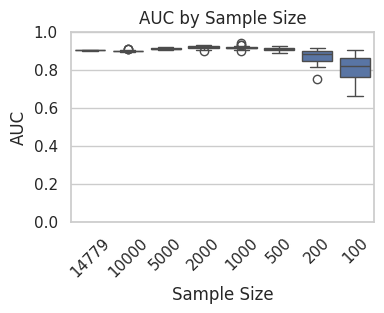

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="auc", data=metrics)
plt.title('AUC by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('calcagno_subsampled_auc.svg')
plt.show()

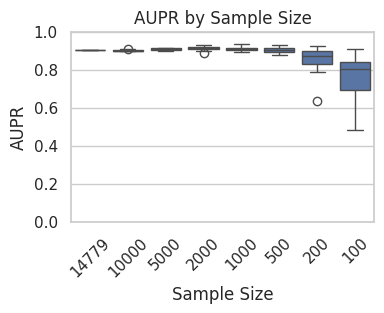

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="aupr", data=metrics)
plt.title('AUPR by Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUPR")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('calcagno_subsampled_aupr.svg')
plt.show()

## Subsample only reference

In [50]:
## Modify to the directory where outputs should be stored
OUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/outputs"
metrics_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-ref-metrics.csv"
results_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-ref-results.csv"

In [ ]:
import scanpy as sc
import time
import sys
from preprocess_calcagno import get_preprocessed_anndata


with open(metrics_csv_path, 'w') as f:
    print('sample_size', 'seed', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'aupr', 'time', sep=',', file=f, flush=True)
    for sample_size in (50, 100, 200, 500, 1_000, 2_000, 3_304):

        for ri in range(25):
            print("RUN", ri)
            ad_full = get_preprocessed_anndata('ref_0_que_1-7', DATA_DIR)
            ad_ref = ad_full[ad_full.obs['dataset'] == 'reference'].copy()
            ad_query = ad_full[ad_full.obs['dataset'] == 'query'].copy()
            ad_ref_sub = ad_ref.copy()
            ad_ref_sub = sc.pp.subsample(ad_ref_sub, n_obs=sample_size, random_state=ri * 100, copy=True)

            # Combine the subsampled reference with all query cells
            ad = ad_ref_sub.concatenate(ad_query, batch_key=None)

            print(ad)

            start = time.perf_counter()

            reference_samples = list(ad.obs[ad.obs['dataset'] == 'reference']['sample'].unique())
            query_samples = list(ad.obs[ad.obs['dataset'] == 'query']['sample'].unique())

            from scpss import scPSS

            scpss = scPSS(ad, 'sample', reference_samples, query_samples)
            scpss.harmony_integrate()
            params = scpss.find_optimal_parameters()
            scpss.set_distance_and_condition()

            ad_que = scpss.adata[scpss.query_mask]

            true_labels = ad_que.obs['zone'].isin(['BZ1', 'BZ2']).to_numpy()
            predicted_labels = ad_que.obs['scpss_condition'].isin(['pathological']).to_numpy()
            predicted_scores = ad_que.obs['scpss_scores']

            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1-score:", f1)

            from sklearn.metrics import roc_auc_score, average_precision_score
            import matplotlib.pyplot as plt
            from sklearn.metrics import roc_curve, precision_recall_curve

            y_true = true_labels
            y_scores = predicted_scores

            # Calculate AUC
            auc = roc_auc_score(y_true, y_scores)
            print("AUC:", auc)

            # Calculate AUPR
            aupr = average_precision_score(y_true, y_scores)
            print("AUPR:", aupr)

            end = time.perf_counter()

            print(sample_size, ri*100, accuracy, precision, recall, f1, auc, aupr, f'{end - start:.4f}', sep=',',file=f, flush=True)


RUN 0
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:00:47,651 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:00:50,195 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:00:50,335 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:00:52,966 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:00:55,611 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8131590413943355
Precision: 0.7783193277310925
Recall: 0.8487903225806451
F1-score: 0.8120287567946695
AUC: 0.9042358655070285
AUPR: 0.9007214427562988
RUN 1
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:02:05,395 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:02:08,187 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:02:08,340 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:02:11,398 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:02:13,836 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8027015250544662
Precision: 0.7694125590817016
Recall: 0.8354105571847508
F1-score: 0.8010544815465729
AUC: 0.8959194588592623
AUPR: 0.8895171576940204
RUN 2
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:03:23,835 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:03:26,234 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:03:26,306 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:03:28,963 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:03:32,582 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7966884531590414
Precision: 0.7395306028531984
Recall: 0.8836143695014663
F1-score: 0.8051774530271398
AUC: 0.8943709960004463
AUPR: 0.8845010227169334
RUN 3
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:04:40,459 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:04:44,136 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:04:44,200 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:04:46,628 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:04:49,035 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8279738562091503
Precision: 0.8361003861003861
Recall: 0.7938049853372434
F1-score: 0.8144039112448289
AUC: 0.912298341420302
AUPR: 0.9070590909528818
RUN 4
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:05:57,653 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:06:00,123 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:06:00,184 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:06:03,507 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:06:06,800 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8074074074074075
Precision: 0.7758327668252889
Recall: 0.8366935483870968
F1-score: 0.8051146384479718
AUC: 0.9015874827464738
AUPR: 0.8943944678056133
RUN 5
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:07:16,728 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:07:19,206 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:07:19,262 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:07:21,632 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:07:24,149 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7945098039215687
Precision: 0.7624534056252118
Recall: 0.8247800586510264
F1-score: 0.7923930269413629
AUC: 0.8848153562107092
AUPR: 0.8737208234096141
RUN 6
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:08:32,931 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:08:35,361 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:08:35,434 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:08:38,857 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:08:41,398 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7951198257080611
Precision: 0.7228362279316779
Recall: 0.9230205278592375
F1-score: 0.810754246156323
AUC: 0.9083276552403214
AUPR: 0.9020616661070795
RUN 7
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:09:49,845 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:09:52,502 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:09:52,547 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:09:54,835 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:09:57,095 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8221350762527233
Precision: 0.7874095270156539
Recall: 0.8574046920821115
F1-score: 0.8209177853821181
AUC: 0.9115257391184026
AUPR: 0.9077732198711312
RUN 8
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:11:09,115 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:11:11,492 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:11:11,542 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:11:14,755 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:11:17,010 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7935511982570806
Precision: 0.7410588786506325
Recall: 0.8696847507331378
F1-score: 0.8002361075976052
AUC: 0.8895294422013574
AUPR: 0.8804647751291867
RUN 9
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:12:39,099 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:12:41,571 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:12:41,620 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:12:44,226 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:12:46,749 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.796078431372549
Precision: 0.7442772028849169
Recall: 0.8700513196480938
F1-score: 0.8022646611458509
AUC: 0.8947385393468094
AUPR: 0.8860949782677964
RUN 10
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:14:05,915 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:14:08,450 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:14:08,506 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:14:10,904 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:14:14,490 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8053159041394335
Precision: 0.7707563025210084
Recall: 0.8405425219941349
F1-score: 0.8041381728914606
AUC: 0.9020423595076977
AUPR: 0.903220786329588
RUN 11
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:15:35,015 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:15:38,539 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:15:38,591 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:15:40,927 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:15:43,281 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.797995642701525
Precision: 0.7455399061032864
Recall: 0.8731671554252199
F1-score: 0.804322134053689
AUC: 0.9006268760849685
AUPR: 0.8965088269207071
RUN 12
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:16:59,529 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:17:02,351 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:17:02,510 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:17:05,113 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:17:07,387 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8226579520697168
Precision: 0.8045219868257076
Recall: 0.8282624633431085
F1-score: 0.8162196333423644
AUC: 0.9125168881143241
AUPR: 0.9085660207378448
RUN 13
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:18:22,025 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:18:24,414 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:18:24,461 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:18:27,191 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:18:30,029 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7927668845315904
Precision: 0.7298387096774194
Recall: 0.8957111436950147
F1-score: 0.804312047399605
AUC: 0.8998024157616229
AUPR: 0.8945359228561349
RUN 14
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:19:46,389 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:19:48,945 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:19:48,993 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:19:51,959 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:19:54,832 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8305010893246187
Precision: 0.812422139170671
Recall: 0.8366935483870968
F1-score: 0.8243792325056434
AUC: 0.9124085130712665
AUPR: 0.9067467910141369
RUN 15
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:21:06,768 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:21:09,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:21:09,404 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:21:11,903 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:21:15,521 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8083660130718954
Precision: 0.7944313867293437
Recall: 0.8053519061583577
F1-score: 0.7998543733503231
AUC: 0.8994441599646086
AUPR: 0.8945547332208355
RUN 16
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:22:22,311 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:22:25,699 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:22:25,749 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:22:28,183 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:22:30,555 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8072331154684096
Precision: 0.7673038892551087
Recall: 0.8533724340175953
F1-score: 0.8080527594585214
AUC: 0.9048014011349204
AUPR: 0.9008932294619424
RUN 17
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:23:39,004 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:23:41,532 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:23:41,582 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:23:44,384 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:23:47,440 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7823093681917211
Precision: 0.7484044339939536
Recall: 0.8167155425219942
F1-score: 0.7810692375109552
AUC: 0.8708376248916555
AUPR: 0.8561237710316315
RUN 18
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:24:57,522 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:25:00,024 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:25:00,070 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:25:02,577 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:25:05,215 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7945969498910675
Precision: 0.7331828442437923
Recall: 0.8929618768328446
F1-score: 0.8052227088670357
AUC: 0.8916607672965228
AUPR: 0.8801704935150506
RUN 19
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:26:15,093 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:26:17,716 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:26:17,765 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:26:20,196 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:26:22,548 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.79119825708061
Precision: 0.7177625960717335
Recall: 0.9243035190615836
F1-score: 0.8080435827591732
AUC: 0.9085296975023861
AUPR: 0.9034769464821633
RUN 20
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:27:32,075 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:27:34,636 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:27:34,772 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:27:38,059 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:27:40,478 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7885838779956427
Precision: 0.7336520666255398
Recall: 0.8718841642228738
F1-score: 0.7968174204355108
AUC: 0.8913125907743757
AUPR: 0.8840167447960183
RUN 21
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:28:48,443 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:28:50,960 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:28:51,006 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:28:53,547 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:28:56,243 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8098474945533769
Precision: 0.7805003427004797
Recall: 0.8348607038123167
F1-score: 0.8067658519305703
AUC: 0.904252887605671
AUPR: 0.8990687395349959
RUN 22
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:30:07,763 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:30:10,188 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:30:10,233 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:30:12,610 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:30:14,940 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8162962962962963
Precision: 0.8387292594091461
Recall: 0.7597140762463344
F1-score: 0.7972687055202924
AUC: 0.9045685120286249
AUPR: 0.8992394751650397
RUN 23
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:31:24,527 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:31:27,796 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:31:27,849 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:31:30,162 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:31:32,506 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.798082788671024
Precision: 0.7572529093591215
Recall: 0.8467741935483871
F1-score: 0.7995154451847365
AUC: 0.8939692562018905
AUPR: 0.8859128597386445
RUN 24
AnnData object with n_obs × n_vars = 11525 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:32:41,323 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:32:43,706 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:32:43,751 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:32:46,444 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:32:49,541 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.806884531590414
Precision: 0.7903225806451613
Recall: 0.8082844574780058
F1-score: 0.7992026096411743
AUC: 0.9024076494814319
AUPR: 0.8970736751925478
RUN 0
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:33:56,412 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:33:59,089 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:33:59,141 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:34:01,414 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:34:03,614 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8118518518518518
Precision: 0.7675701996429151
Recall: 0.8667521994134897
F1-score: 0.8141516742704656
AUC: 0.9056770191071384
AUPR: 0.901973556677037
RUN 1
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:35:13,876 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:35:16,282 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:35:16,360 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:35:19,832 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:35:22,359 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8196078431372549
Precision: 0.8088288945640277
Recall: 0.8126832844574781
F1-score: 0.8107515085024685
AUC: 0.9031753491753143
AUPR: 0.8999446680900554
RUN 2
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:36:32,022 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:36:34,402 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:36:34,449 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:36:36,675 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:36:40,023 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.812723311546841
Precision: 0.762418663704174
Recall: 0.8804985337243402
F1-score: 0.8172152760057838
AUC: 0.9095615594605354
AUPR: 0.9049292254076806
RUN 3
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:37:49,973 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:37:52,412 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:37:52,489 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:37:54,638 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:37:56,836 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8311111111111111
Precision: 0.8051700208188758
Recall: 0.8506231671554252
F1-score: 0.8272727272727273
AUC: 0.9179832656022302
AUPR: 0.9131345352033708
RUN 4
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:39:14,205 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:39:16,665 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:39:16,715 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:39:18,959 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:39:22,308 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8193464052287581
Precision: 0.8040625561747259
Recall: 0.8198313782991202
F1-score: 0.8118704056629458
AUC: 0.9056870374800424
AUPR: 0.9017442104473185
RUN 5
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:40:35,620 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:40:38,032 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:40:38,080 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:40:40,393 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:40:43,883 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.814640522875817
Precision: 0.7691188358932902
Recall: 0.8718841642228738
F1-score: 0.8172837385104372
AUC: 0.9118071975401453
AUPR: 0.9069590423658573
RUN 6
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:42:02,293 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:42:05,557 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:42:05,606 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:42:07,960 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:42:10,306 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.802962962962963
Precision: 0.7359326539654408
Recall: 0.9133064516129032
F1-score: 0.8150813772797906
AUC: 0.9143526559833257
AUPR: 0.9103524020966111
RUN 7
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:43:24,381 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:43:26,814 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:43:26,862 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:43:29,172 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:43:31,561 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 17:43:33,827 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8261437908496732
Precision: 0.7894296705134638
Recall: 0.8651026392961877
F1-score: 0.8255356362046349
AUC: 0.9148981853163904
AUPR: 0.9116697844801299
RUN 8
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:44:44,535 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:44:47,251 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:44:47,299 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:44:49,594 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:44:51,956 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 17:44:54,216 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8063616557734204
Precision: 0.771035869929601
Recall: 0.843108504398827
F1-score: 0.8054631413062511
AUC: 0.90045227015721
AUPR: 0.8999828974008393
RUN 9
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:46:04,205 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:46:07,294 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:46:07,343 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:46:09,658 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:46:11,956 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.797037037037037
Precision: 0.737361469561257
Recall: 0.8902126099706745
F1-score: 0.806609648758615
AUC: 0.904549601969131
AUPR: 0.8996364962765829
RUN 10
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:47:21,647 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:47:24,193 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:47:24,242 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:47:27,632 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:47:29,903 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8250108932461874
Precision: 0.7792355037252996
Recall: 0.8817815249266863
F1-score: 0.8273430782459157
AUC: 0.9170831954918905
AUPR: 0.9134442696447878
RUN 11
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:48:37,242 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:48:39,774 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:48:39,827 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:48:42,271 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:48:44,702 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.797995642701525
Precision: 0.7314159292035398
Recall: 0.9089076246334311
F1-score: 0.8105590062111802
AUC: 0.9110702837885309
AUPR: 0.9072648627947772
RUN 12
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:49:53,903 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:49:57,237 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:49:57,285 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:49:59,754 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:50:02,264 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8267538126361655
Precision: 0.796816158849709
Recall: 0.8531891495601173
F1-score: 0.8240396530359355
AUC: 0.913901220183008
AUPR: 0.9111828348944495
RUN 13
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:51:09,627 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:51:12,130 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:51:12,176 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:51:14,817 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:51:18,829 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8080174291938997
Precision: 0.7458062566117576
Recall: 0.904508797653959
F1-score: 0.8175267124989646
AUC: 0.9146011664431158
AUPR: 0.9107454169589475
RUN 14
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:52:26,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:52:29,328 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:52:29,377 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:52:31,716 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:52:34,133 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8317211328976035
Precision: 0.8177393185505679
Recall: 0.8313782991202346
F1-score: 0.8245024084340634
AUC: 0.9161352564386773
AUPR: 0.9106714069968807
RUN 15
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:53:53,731 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:53:56,188 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:53:56,234 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:53:58,686 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:54:02,060 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8182135076252723
Precision: 0.7631168019987508
Recall: 0.8957111436950147
F1-score: 0.8241146711635751
AUC: 0.9171926363192997
AUPR: 0.9127417835467346
RUN 16
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:55:10,461 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:55:12,883 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:55:12,937 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:55:15,348 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:55:17,848 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8211764705882353
Precision: 0.7827242524916943
Recall: 0.8636363636363636
F1-score: 0.8211920529801324
AUC: 0.9127843695355713
AUPR: 0.9096684467386765
RUN 17
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:56:25,411 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:56:27,779 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:56:27,830 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:56:31,058 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:56:33,372 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8166448801742919
Precision: 0.761303398815092
Recall: 0.8949780058651027
F1-score: 0.8227464195450717
AUC: 0.9164499977831685
AUPR: 0.9123886495984477
RUN 18
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:57:41,786 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:57:44,173 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:57:44,224 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:57:46,453 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:57:48,582 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 17:57:51,387 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7959041394335512
Precision: 0.7355521936459909
Recall: 0.8911290322580645
F1-score: 0.8059008785015747
AUC: 0.9036647268985456
AUPR: 0.899984720612499
RUN 19
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 17:58:59,084 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 17:59:02,473 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 17:59:02,518 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 17:59:04,689 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 17:59:06,894 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7952069716775599
Precision: 0.7208475540386803
Recall: 0.9290689149560117
F1-score: 0.8118193465727098
AUC: 0.9123013560674677
AUPR: 0.9075106753277737
RUN 20
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:00:17,297 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:00:19,686 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:00:19,735 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:00:23,327 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:00:25,694 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8081045751633987
Precision: 0.7469641772920461
Recall: 0.9019428152492669
F1-score: 0.8171703752906011
AUC: 0.9117331103022248
AUPR: 0.9076860627300162
RUN 21
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:01:39,220 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:01:41,573 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:01:41,616 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:01:45,361 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:01:47,816 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8193464052287581
Precision: 0.7833808008041548
Recall: 0.8570381231671554
F1-score: 0.8185557986870897
AUC: 0.9094046151020303
AUPR: 0.9053669567377456
RUN 22
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:02:57,118 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:02:59,461 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:02:59,507 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:03:01,840 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:03:04,161 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8316339869281045
Precision: 0.7857606227700292
Recall: 0.8880131964809385
F1-score: 0.8337635518843572
AUC: 0.920087885186645
AUPR: 0.9139947408900011
RUN 23
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:04:14,050 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:04:16,485 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:04:16,533 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:04:18,768 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:04:21,009 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8180392156862745
Precision: 0.767982176957352
Recall: 0.8845307917888563
F1-score: 0.8221465076660988
AUC: 0.91303367172088
AUPR: 0.9092893167343425
RUN 24
AnnData object with n_obs × n_vars = 11575 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:05:32,450 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:05:35,850 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:05:35,901 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:05:38,393 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:05:41,125 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8099346405228758
Precision: 0.7515747426640037
Recall: 0.8966275659824047
F1-score: 0.8177183451734225
AUC: 0.9146952904268449
AUPR: 0.9111565939261967
RUN 0
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:06:48,865 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:06:51,480 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:06:51,533 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:06:54,135 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:06:57,739 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:07:00,268 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8011328976034858
Precision: 0.7573791761271489
Recall: 0.8559384164222874
F1-score: 0.8036482533126829
AUC: 0.9007584547759075
AUPR: 0.9017353255829277
RUN 1
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:08:09,318 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:08:11,859 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:08:11,905 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:08:14,249 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:08:16,665 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:08:20,066 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8240522875816993
Precision: 0.7882905552759604
Recall: 0.8612536656891495
F1-score: 0.8231584479285277
AUC: 0.9144242462407655
AUPR: 0.9117323557728556
RUN 2
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:09:31,168 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:09:33,705 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:09:33,753 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:09:36,137 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:09:38,462 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8025272331154684
Precision: 0.7352507374631269
Recall: 0.9136730205278593
F1-score: 0.8148087610330174
AUC: 0.9137542028444627
AUPR: 0.9098806135958802
RUN 3
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:10:47,560 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:10:50,725 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:10:50,772 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:10:53,213 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:10:55,630 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:10:57,997 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8301525054466231
Precision: 0.8074697527617044
Recall: 0.844024926686217
F1-score: 0.825342772649879
AUC: 0.9125944467641325
AUPR: 0.9090250678743641
RUN 4
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:12:07,268 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:12:10,821 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:12:10,877 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:12:13,355 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:12:15,705 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:12:18,065 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8307625272331155
Precision: 0.7991147429349676
Recall: 0.8603372434017595
F1-score: 0.8285966460723743
AUC: 0.9165440913159161
AUPR: 0.9135422028417113
RUN 5
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:13:26,592 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:13:29,484 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:13:29,549 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:13:32,422 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:13:34,704 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:13:37,061 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8188235294117647
Precision: 0.7678883071553229
Recall: 0.8870967741935484
F1-score: 0.823199251637044
AUC: 0.9152057706802359
AUPR: 0.910457683430412
RUN 6
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:14:44,876 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:14:47,228 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:14:47,275 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:14:49,746 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:14:53,095 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:14:55,420 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.803834422657952
Precision: 0.7359046076843809
Recall: 0.9162390029325513
F1-score: 0.8162298963180667
AUC: 0.9156982239525958
AUPR: 0.9123336110191826
RUN 7
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:16:03,097 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:16:05,498 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:16:05,547 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:16:07,830 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:16:10,070 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:16:13,397 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8298910675381264
Precision: 0.7994871794871795
Recall: 0.8572214076246334
F1-score: 0.827348310631523
AUC: 0.9165223493151452
AUPR: 0.913700620018671
RUN 8
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:17:23,864 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:17:26,273 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:17:26,320 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:17:28,776 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:17:31,256 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:17:34,299 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8115032679738562
Precision: 0.7575473173783827
Recall: 0.8876466275659824
F1-score: 0.8174529496160013
AUC: 0.9127764218294073
AUPR: 0.9094117300696117
RUN 9
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:18:41,451 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:18:44,766 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:18:44,819 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:18:47,209 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:18:49,705 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8118518518518518
Precision: 0.753810623556582
Recall: 0.8973607038123167
F1-score: 0.8193456614509246
AUC: 0.9141543591919821
AUPR: 0.909966734040702
RUN 10
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:19:58,543 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:20:00,979 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:20:01,026 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:20:03,454 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:20:06,817 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:20:09,307 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8335511982570806
Precision: 0.7946161515453639
Recall: 0.876466275659824
F1-score: 0.8335366916506886
AUC: 0.91928702437394
AUPR: 0.9149186357848202
RUN 11
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:21:18,451 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:21:20,843 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:21:20,892 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:21:23,200 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:21:25,447 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:21:28,603 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8096732026143791
Precision: 0.7494663007014334
Recall: 0.9008431085043989
F1-score: 0.8182120858997836
AUC: 0.9138930288689922
AUPR: 0.911178392162108
RUN 12
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:22:37,844 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:22:40,884 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:22:40,944 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:22:43,356 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:22:45,728 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:22:48,056 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8278867102396514
Precision: 0.7874483897605284
Recall: 0.873900293255132
F1-score: 0.8284249847971505
AUC: 0.9175152340170107
AUPR: 0.9140554172699957
RUN 13
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:23:58,519 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:24:01,769 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:24:01,855 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:24:04,294 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:24:06,876 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:24:09,348 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8304139433551199
Precision: 0.7869522563767168
Recall: 0.8821480938416423
F1-score: 0.8318354649153128
AUC: 0.9196864498979039
AUPR: 0.915487516251381
RUN 14
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:25:21,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:25:24,396 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:25:24,590 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:25:27,630 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:25:29,804 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8269281045751634
Precision: 0.8004849324558365
Recall: 0.8471407624633431
F1-score: 0.8231522707034729
AUC: 0.9155841241250217
AUPR: 0.9116005220314847
RUN 15
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:26:40,566 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:26:43,010 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:26:43,064 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:26:45,528 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:26:48,551 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:26:51,812 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8269281045751634
Precision: 0.799344375431332
Recall: 0.8491568914956011
F1-score: 0.8234980447920369
AUC: 0.9135279216011467
AUPR: 0.909787297840979
RUN 16
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:28:04,303 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:28:06,766 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:28:06,817 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:28:09,280 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:28:11,852 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8189978213507625
Precision: 0.7639431338853304
Recall: 0.8962609970674487
F1-score: 0.824829214809817
AUC: 0.9166214063578727
AUPR: 0.9133816526644296
RUN 17
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:29:23,375 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:29:26,338 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:29:26,394 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:29:28,942 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:29:31,518 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:29:34,132 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8260566448801743
Precision: 0.7922297297297297
Recall: 0.8596041055718475
F1-score: 0.8245428973277075
AUC: 0.9151217564223556
AUPR: 0.9119643612650297
RUN 18
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:30:47,615 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:30:50,901 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:30:50,979 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:30:54,008 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:30:56,649 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:31:00,349 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8175163398692811
Precision: 0.7949122807017543
Recall: 0.8304618768328446
F1-score: 0.8122983148081749
AUC: 0.9030711459167182
AUPR: 0.9044596323776437
RUN 19
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:32:10,803 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:32:13,835 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:32:13,887 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:32:16,568 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:32:19,638 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8064488017429194
Precision: 0.7472863476532641
Recall: 0.8958944281524927
F1-score: 0.8148703842627324
AUC: 0.910152003991271
AUPR: 0.905035658976798
RUN 20
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:33:32,941 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:33:36,420 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:33:36,468 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:33:38,958 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:33:41,558 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:33:44,078 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8064488017429194
Precision: 0.7465325407712239
Recall: 0.8977272727272727
F1-score: 0.8151784971290672
AUC: 0.9121034551388832
AUPR: 0.908751174236987
RUN 21
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:34:56,102 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:34:59,508 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:34:59,617 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:35:02,635 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:35:05,441 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8176906318082788
Precision: 0.77893864013267
Recall: 0.8608870967741935
F1-score: 0.8178652272331534
AUC: 0.9093231282756121
AUPR: 0.9054279577009396
RUN 22
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:36:21,920 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:36:25,917 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:36:25,969 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:36:28,604 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:36:31,265 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:36:33,901 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8378213507625273
Precision: 0.8130987632816582
Recall: 0.8555718475073314
F1-score: 0.8337947664553005
AUC: 0.9191452141532264
AUPR: 0.9141027769134891
RUN 23
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:38:07,294 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:38:09,793 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:38:09,840 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:38:13,307 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:38:15,675 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:38:18,087 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8019172113289761
Precision: 0.7436093678248891
Recall: 0.8903958944281525
F1-score: 0.8104095420802402
AUC: 0.9070309610963134
AUPR: 0.904461081607832
RUN 24
AnnData object with n_obs × n_vars = 11675 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:39:42,423 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:39:45,563 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:39:45,668 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:39:47,882 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:39:49,935 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:39:52,076 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8246623093681917
Precision: 0.778821243523316
Recall: 0.8815982404692082
F1-score: 0.827028885832187
AUC: 0.9159556870009388
AUPR: 0.9133926262342433
RUN 0
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:41:19,195 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:41:21,786 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:41:21,841 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:41:24,303 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:41:26,705 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:41:29,141 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8220479302832244
Precision: 0.7930975274725275
Recall: 0.8465909090909091
F1-score: 0.8189716312056737
AUC: 0.9114635886652189
AUPR: 0.9092116382953375
RUN 1
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:42:55,701 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:42:58,158 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:42:58,208 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:43:00,795 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:43:03,844 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:43:07,004 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8262309368191721
Precision: 0.8151857246904588
Recall: 0.8205645161290323
F1-score: 0.8178662769455608
AUC: 0.9105569411428813
AUPR: 0.9095693889436809
RUN 2
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:44:30,311 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:44:32,742 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:44:32,793 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:44:35,080 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:44:38,357 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:44:40,832 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8206535947712418
Precision: 0.7835447263017357
Recall: 0.8605205278592375
F1-score: 0.820230607966457
AUC: 0.9115557333351522
AUPR: 0.9101756278568109
RUN 3
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:46:00,228 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:46:02,682 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:46:02,731 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:46:05,046 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:46:07,405 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:46:10,171 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8308496732026144
Precision: 0.8061313360041804
Recall: 0.8482404692082112
F1-score: 0.8266499955345181
AUC: 0.9113033860516966
AUPR: 0.9098112960528344
RUN 4
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:47:17,746 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:47:21,175 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:47:21,231 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:47:23,718 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:47:26,122 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:47:28,624 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8320697167755992
Precision: 0.8304926016107885
Recall: 0.8126832844574781
F1-score: 0.8214914312181566
AUC: 0.9136887332342987
AUPR: 0.9110894334149404
RUN 5
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:48:35,766 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:48:38,182 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:48:38,230 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:48:41,793 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:48:44,200 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:48:46,558 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.827276688453159
Precision: 0.7986588720770289
Recall: 0.8513563049853372
F1-score: 0.82416607523066
AUC: 0.9135130615221885
AUPR: 0.9110357211822018
RUN 6
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:49:56,771 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:49:59,162 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:49:59,210 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:50:02,580 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:50:04,746 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:50:07,081 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8299782135076252
Precision: 0.8114448196196907
Recall: 0.8368768328445748
F1-score: 0.8239646305152034
AUC: 0.9139905633626458
AUPR: 0.9120692644424477
RUN 7
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:51:18,023 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:51:20,430 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:51:20,477 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:51:23,853 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:51:26,179 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:51:28,369 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8244880174291939
Precision: 0.8029929577464788
Recall: 0.8359604105571847
F1-score: 0.8191451149425287
AUC: 0.9103350448408971
AUPR: 0.909596059308377
RUN 8
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:52:40,873 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:52:43,995 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:52:44,103 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:52:46,463 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:52:48,828 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:52:51,165 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8352941176470589
Precision: 0.8225397973950795
Recall: 0.8333944281524927
F1-score: 0.827931536780772
AUC: 0.9165804497877932
AUPR: 0.9137235993007633
RUN 9
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:54:09,041 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:54:11,582 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:54:11,661 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:54:14,418 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:54:17,951 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:54:20,785 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8287581699346406
Precision: 0.8092116917626218
Recall: 0.8372434017595308
F1-score: 0.8229889199171245
AUC: 0.9130262416814008
AUPR: 0.911136782729169
RUN 10
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:55:29,214 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:55:31,823 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:55:31,872 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:55:34,461 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:55:37,209 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:55:40,783 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.83119825708061
Precision: 0.815831987075929
Recall: 0.8330278592375366
F1-score: 0.824340255735921
AUC: 0.9123892985019578
AUPR: 0.9111863613587887
RUN 11
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:56:49,132 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:56:51,684 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:56:51,735 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:56:54,309 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:56:56,874 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:57:00,557 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.818562091503268
Precision: 0.7806054557551564
Recall: 0.8601539589442815
F1-score: 0.8184513428671085
AUC: 0.9103106536047385
AUPR: 0.9094003225049082
RUN 12
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:58:08,955 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:58:11,594 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:58:11,649 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:58:14,210 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:58:16,773 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:58:19,317 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8309368191721133
Precision: 0.8093980992608236
Recall: 0.842925219941349
F1-score: 0.8258215119411025
AUC: 0.9136440311934981
AUPR: 0.9124824387005732
RUN 13
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 18:59:29,606 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 18:59:32,051 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 18:59:32,102 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 18:59:34,614 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 18:59:36,946 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 18:59:39,626 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8354684095860566
Precision: 0.8280617874218462
Recall: 0.8253299120234604
F1-score: 0.826693592803378
AUC: 0.9164541695676302
AUPR: 0.9141326806521674
RUN 14
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:00:56,022 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:00:58,526 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:00:58,586 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:01:02,155 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:01:04,511 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:01:06,966 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8268409586056645
Precision: 0.8105640107430617
Recall: 0.8297287390029325
F1-score: 0.8200344171723576
AUC: 0.9118480627572803
AUPR: 0.9108827903965604
RUN 15
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:02:15,286 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:02:17,735 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:02:17,785 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:02:20,345 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:02:23,948 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:02:26,447 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.83119825708061
Precision: 0.8231404958677686
Recall: 0.8214809384164223
F1-score: 0.8223098798275388
AUC: 0.911423819683417
AUPR: 0.910555158668473
RUN 16
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:03:34,316 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:03:36,779 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:03:36,829 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:03:39,406 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:03:42,067 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:03:45,508 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8268409586056645
Precision: 0.7988971221781836
Recall: 0.8497067448680352
F1-score: 0.8235189626076916
AUC: 0.9121505323562386
AUPR: 0.9111362117841715
RUN 17
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:04:54,212 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:04:56,633 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:04:56,679 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:04:58,937 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:05:01,320 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:05:03,971 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8316339869281045
Precision: 0.8075043630017452
Recall: 0.8480571847507331
F1-score: 0.8272841051314143
AUC: 0.9144741553993975
AUPR: 0.9124478635222792
RUN 18
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:06:13,078 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:06:15,552 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:06:15,602 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:06:17,924 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:06:20,250 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:06:22,629 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.826318082788671
Precision: 0.811141060197664
Recall: 0.8273460410557185
F1-score: 0.8191634152980674
AUC: 0.9105144011217653
AUPR: 0.9096753741275524
RUN 19
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:07:32,368 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:07:35,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:07:35,405 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:07:38,057 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:07:40,770 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:07:43,346 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8323311546840959
Precision: 0.8096072931276297
Recall: 0.8464076246334311
F1-score: 0.8275985663082437
AUC: 0.9148392626672429
AUPR: 0.9115298859050447
RUN 20
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:08:51,468 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:08:54,758 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:08:54,811 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:08:57,262 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:08:59,653 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:09:02,026 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8256209150326798
Precision: 0.8075485134413388
Recall: 0.8313782991202346
F1-score: 0.8192901652668654
AUC: 0.9110152893159931
AUPR: 0.9088716342909056
RUN 21
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:10:11,529 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:10:15,889 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:10:15,980 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:10:20,528 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:10:25,540 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:10:29,782 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.823442265795207
Precision: 0.8010884831460674
Recall: 0.8363269794721407
F1-score: 0.8183285509325682
AUC: 0.9074017017957308
AUPR: 0.9055053344969485
RUN 22
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:11:38,346 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:11:40,747 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:11:40,794 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:11:43,190 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:11:45,584 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:11:49,003 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8220479302832244
Precision: 0.7841211717709721
Recall: 0.8634530791788856
F1-score: 0.821877180739707
AUC: 0.9125617728610134
AUPR: 0.9106423300372328
RUN 23
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:12:58,162 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:13:00,566 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:13:00,621 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:13:03,050 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:13:05,567 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:13:08,588 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8316339869281045
Precision: 0.8130774697938877
Recall: 0.8387096774193549
F1-score: 0.8256946950559365
AUC: 0.9100441161639169
AUPR: 0.9085113124386179
RUN 24
AnnData object with n_obs × n_vars = 11975 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:14:17,109 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:14:20,063 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:14:20,118 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:14:22,453 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:14:24,711 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:14:27,038 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8266666666666667
Precision: 0.8027947598253276
Recall: 0.842375366568915
F1-score: 0.8221089348001073
AUC: 0.911706404791474
AUPR: 0.9109304097111821
RUN 0
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:15:36,811 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:15:40,224 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:15:40,273 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:15:42,887 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:15:45,339 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:15:47,892 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8226579520697168
Precision: 0.8201384989706157
Recall: 0.8031524926686217
F1-score: 0.8115566256134827
AUC: 0.9063915818383524
AUPR: 0.9066655992318391
RUN 1
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:17:03,636 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:17:06,271 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:17:06,327 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:17:09,236 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:17:12,891 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:17:15,586 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.818562091503268
Precision: 0.8177024482109227
Recall: 0.7958211143695014
F1-score: 0.8066134125952071
AUC: 0.9025003422690316
AUPR: 0.9031387093911591
RUN 2
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:18:27,968 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:18:30,841 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:18:30,899 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:18:34,116 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:18:36,529 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:18:38,968 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8184749455337691
Precision: 0.8037097064649739
Recall: 0.8179985337243402
F1-score: 0.8107911708602052
AUC: 0.9009988652746266
AUPR: 0.9041415146126658
RUN 3
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:19:50,588 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:19:54,051 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:19:54,107 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:19:56,760 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:19:59,300 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:20:02,021 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8181263616557735
Precision: 0.8163380281690141
Recall: 0.7967375366568915
F1-score: 0.8064186995640479
AUC: 0.8995376140267453
AUPR: 0.9025780771181628
RUN 4
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:21:14,631 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:21:17,120 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:21:17,175 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:21:19,581 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:21:22,123 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:21:25,738 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8183006535947712
Precision: 0.8197685448681464
Recall: 0.7919721407624634
F1-score: 0.8056306516267363
AUC: 0.8979646685788258
AUPR: 0.901826855258505
RUN 5
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:22:37,504 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:22:40,040 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:22:40,099 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:22:42,639 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:22:46,168 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:22:48,894 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8250980392156863
Precision: 0.8045205721349108
Recall: 0.8350439882697948
F1-score: 0.8194981563090206
AUC: 0.9076652854913497
AUPR: 0.9073828517562914
RUN 6
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:23:59,776 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:24:02,328 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:24:02,394 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:24:05,008 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:24:08,584 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:24:10,985 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8243137254901961
Precision: 0.8158281307381564
Recall: 0.8143328445747801
F1-score: 0.8150798018712163
AUC: 0.907873692008542
AUPR: 0.9078728770865285
RUN 7
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:25:22,656 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:25:25,202 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:25:25,286 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:25:28,846 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:25:31,586 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:25:34,074 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8228322440087146
Precision: 0.8220131702728128
Recall: 0.8007697947214076
F1-score: 0.8112524370996194
AUC: 0.9049385828064501
AUPR: 0.9061091162901441
RUN 8
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:26:44,197 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:26:46,734 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:26:46,806 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:26:50,465 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:26:53,077 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:26:55,722 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8243137254901961
Precision: 0.8179297597042514
Recall: 0.811033724340176
F1-score: 0.8144671452236334
AUC: 0.9071168937660264
AUPR: 0.9059594664376966
RUN 9
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:28:11,439 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:28:13,976 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:28:14,035 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:28:16,605 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:28:19,233 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:28:22,402 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8222222222222222
Precision: 0.8190138214419126
Recall: 0.8037023460410557
F1-score: 0.8112858464384829
AUC: 0.9048780462552846
AUPR: 0.9051429192067841
RUN 10
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:29:33,817 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:29:36,281 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:29:36,333 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:29:38,802 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:29:41,400 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:29:45,017 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8223965141612201
Precision: 0.8241654021244309
Recall: 0.7963709677419355
F1-score: 0.8100298284862043
AUC: 0.9063129574041927
AUPR: 0.907014733903716
RUN 11
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:31:02,119 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:31:05,483 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:31:05,538 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:31:08,313 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:31:11,100 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:31:13,844 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8208278867102397
Precision: 0.8044412607449857
Recall: 0.8233137829912024
F1-score: 0.813768115942029
AUC: 0.9040662535402311
AUPR: 0.9056914453628208
RUN 12
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:32:26,055 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:32:28,551 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:32:28,602 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:32:31,013 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:32:33,551 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:32:36,918 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8255337690631809
Precision: 0.8160688140556369
Recall: 0.8172653958944281
F1-score: 0.8166666666666667
AUC: 0.9076587994322962
AUPR: 0.9082227903481805
RUN 13
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:33:47,791 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:33:50,258 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:33:50,314 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:33:52,695 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:33:55,024 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:33:58,714 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8210893246187364
Precision: 0.8208561191778239
Recall: 0.7978372434017595
F1-score: 0.8091830095733804
AUC: 0.9043586134133407
AUPR: 0.9040827965245919
RUN 14
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:35:08,909 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:35:11,368 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:35:11,424 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:35:13,983 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:35:16,513 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:35:20,293 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8202178649237473
Precision: 0.8185915492957746
Recall: 0.7989369501466276
F1-score: 0.8086448381411743
AUC: 0.8979054414198635
AUPR: 0.9018103151366181
RUN 15
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:36:31,781 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:36:34,220 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:36:34,273 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:36:36,754 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:36:40,176 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:36:42,933 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8270152505446623
Precision: 0.8207355387174274
Recall: 0.813966275659824
F1-score: 0.8173368915063955
AUC: 0.9074867513869813
AUPR: 0.9072984541316205
RUN 16
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:37:54,187 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:37:56,646 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:37:56,704 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:37:59,156 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:38:02,821 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:38:05,164 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8225708061002178
Precision: 0.8072224218469278
Recall: 0.8234970674486803
F1-score: 0.8152785338414081
AUC: 0.9077089826497615
AUPR: 0.9083481901456641
RUN 17
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:39:15,768 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:39:18,183 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:39:18,229 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:39:20,902 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:39:24,396 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:39:26,952 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8247494553376906
Precision: 0.8170439904288607
Recall: 0.813599706744868
F1-score: 0.8153182110386629
AUC: 0.9053711085472738
AUPR: 0.9061013461847807
RUN 18
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:40:39,807 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:40:43,127 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:40:43,218 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:40:46,029 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:40:48,766 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:40:51,575 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8226579520697168
Precision: 0.8111697289430598
Recall: 0.8172653958944281
F1-score: 0.8142061535652333
AUC: 0.9040892440312422
AUPR: 0.9048762834562456
RUN 19
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:42:01,725 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:42:05,174 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:42:05,233 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:42:07,985 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:42:10,823 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:42:13,656 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8186492374727669
Precision: 0.8141873021783653
Recall: 0.8015029325513197
F1-score: 0.8077953264985684
AUC: 0.9020610868613028
AUPR: 0.9023557296181829
RUN 20
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:43:24,980 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:43:27,573 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:43:27,636 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:43:30,305 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:43:34,740 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:43:38,382 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8206535947712418
Precision: 0.8259785111281658
Recall: 0.7890395894428153
F1-score: 0.8070866141732284
AUC: 0.9044011534344565
AUPR: 0.9057863228109697
RUN 21
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:44:49,791 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:44:52,378 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:44:52,436 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:44:55,093 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:44:58,868 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:45:01,566 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8264923747276689
Precision: 0.8135746606334842
Recall: 0.8238636363636364
F1-score: 0.8186868226937437
AUC: 0.9079922376794112
AUPR: 0.9074265058736939
RUN 22
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:46:11,738 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:46:14,289 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:46:14,344 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:46:17,083 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:46:20,859 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:46:23,567 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8257952069716775
Precision: 0.8065259797836496
Recall: 0.8335777126099707
F1-score: 0.8198287516899504
AUC: 0.9079888576204678
AUPR: 0.906776418236134
RUN 23
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:47:41,805 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:47:45,136 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:47:45,216 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:47:48,169 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:47:50,853 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:47:54,496 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8203921568627451
Precision: 0.8277659779880285
Recall: 0.7857404692082112
F1-score: 0.8062059238363892
AUC: 0.8978691438499492
AUPR: 0.9010877562109706
RUN 24
AnnData object with n_obs × n_vars = 12475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:49:05,828 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:49:08,364 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:49:08,416 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:49:10,901 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:49:14,599 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:49:17,245 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8257952069716775
Precision: 0.8143298781596654
Recall: 0.8207478005865103
F1-score: 0.8175262437243268
AUC: 0.906193285047009
AUPR: 0.9071683900071832
RUN 0
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:50:28,332 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:50:30,883 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:50:30,967 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:50:34,314 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:50:37,748 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:50:40,388 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.80880174291939
Precision: 0.8228424386381631
Recall: 0.7619134897360704
F1-score: 0.7912066996574039
AUC: 0.8901637970473752
AUPR: 0.8942507939710385
RUN 1
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:51:57,165 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:51:59,703 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:51:59,758 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:52:02,658 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:52:05,559 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:52:09,457 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8108932461873638
Precision: 0.8280750798722045
Recall: 0.7600806451612904
F1-score: 0.7926223241590215
AUC: 0.8923697270471462
AUPR: 0.8944039076398781
RUN 2
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:53:25,591 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:53:28,916 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:53:28,985 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:53:31,747 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:53:34,524 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:53:37,245 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8150762527233115
Precision: 0.8243190661478599
Recall: 0.7765762463343109
F1-score: 0.7997357493393733
AUC: 0.8967174572797092
AUPR: 0.8985966600842121
RUN 3
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:54:53,984 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:54:56,525 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:54:56,584 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:55:00,477 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:55:03,403 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8167320261437908
Precision: 0.8024535450117265
Recall: 0.8152492668621701
F1-score: 0.8088008000727339
AUC: 0.9015131214497201
AUPR: 0.9038200416958184
RUN 4
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:56:21,028 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:56:23,535 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:56:23,593 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:56:26,746 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:56:29,956 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:56:33,952 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8120261437908497
Precision: 0.824385447394297
Recall: 0.7683284457478006
F1-score: 0.795370458210796
AUC: 0.8924028272640061
AUPR: 0.8964466998348262
RUN 5
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:57:51,151 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:57:54,570 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:57:54,634 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:57:57,514 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:58:00,338 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:58:03,072 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8116775599128541
Precision: 0.8186037516921292
Recall: 0.7758431085043989
F1-score: 0.7966500423449704
AUC: 0.893965419378225
AUPR: 0.8978127664453949
RUN 6
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 19:59:20,367 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 19:59:22,879 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 19:59:22,939 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 19:59:26,735 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 19:59:29,656 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 19:59:32,785 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8119389978213508
Precision: 0.8258893280632411
Recall: 0.7659457478005866
F1-score: 0.7947888931152529
AUC: 0.8909466308790491
AUPR: 0.8957786278824447
RUN 7
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:00:57,357 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:00:59,784 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:00:59,845 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:01:02,471 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:01:05,050 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:01:08,147 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8111546840958606
Precision: 0.8270033803937165
Recall: 0.7622800586510264
F1-score: 0.7933237958989032
AUC: 0.8928827956339626
AUPR: 0.8973429956841648
RUN 8
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:02:26,932 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:02:30,394 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:02:30,451 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:02:33,434 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:02:36,406 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:02:39,296 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8130718954248366
Precision: 0.8250539956803455
Recall: 0.7701612903225806
F1-score: 0.7966631908237748
AUC: 0.8937818913128952
AUPR: 0.8979484217871035
RUN 9
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:04:00,543 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:04:03,075 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:04:03,137 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:04:06,145 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:04:09,194 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:04:12,966 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8114161220043573
Precision: 0.8272365805168986
Recall: 0.7626466275659824
F1-score: 0.7936296013732596
AUC: 0.8922915593777087
AUPR: 0.8964816047720183
RUN 10
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:05:35,793 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:05:38,390 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:05:38,446 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:05:41,470 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:05:45,503 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:05:48,454 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8091503267973856
Precision: 0.8212037765538945
Recall: 0.7652126099706745
F1-score: 0.7922201138519924
AUC: 0.8925531333085502
AUPR: 0.8964416380113047
RUN 11
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:07:09,325 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:07:11,864 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:07:11,926 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:07:14,762 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:07:18,677 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:07:21,611 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8108061002178649
Precision: 0.8151986183074266
Recall: 0.7785923753665689
F1-score: 0.7964751101528077
AUC: 0.8923688744196652
AUPR: 0.8976114120850427
RUN 12
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:08:38,945 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:08:41,470 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:08:41,537 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:08:44,346 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:08:47,167 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:08:50,990 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8144662309368191
Precision: 0.8204584858408784
Recall: 0.780608504398827
F1-score: 0.8000375692683385
AUC: 0.8966910258277916
AUPR: 0.8979053352766134
RUN 13
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:10:12,097 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:10:14,602 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:10:14,661 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:10:17,451 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:10:20,362 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:10:24,220 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169934640522876
Precision: 0.8166037735849057
Recall: 0.7932551319648093
F1-score: 0.8047601338787653
AUC: 0.8975174350139514
AUPR: 0.8988926944426833
RUN 14
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:11:45,509 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:11:48,115 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:11:48,172 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:11:51,013 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:11:54,026 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:11:57,817 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8129847494553377
Precision: 0.8302075019952115
Recall: 0.7626466275659824
F1-score: 0.7949942682460833
AUC: 0.8951967352650134
AUPR: 0.8978275642480671
RUN 15
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:13:17,235 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:13:19,962 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:13:20,029 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:13:22,858 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:13:25,709 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:13:29,547 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8143790849673203
Precision: 0.8264625049077345
Recall: 0.7716275659824047
F1-score: 0.7981042654028436
AUC: 0.8957792929915481
AUPR: 0.897446067609919
RUN 16
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:14:49,406 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:14:52,164 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:14:52,227 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:14:55,171 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:14:58,071 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:15:01,728 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.809760348583878
Precision: 0.8115362649914335
Recall: 0.781341642228739
F1-score: 0.7961527686992249
AUC: 0.8953461582310951
AUPR: 0.8969628394862263
RUN 17
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:16:37,206 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:16:39,708 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:16:39,770 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:16:42,702 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:16:45,809 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:16:49,677 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.810631808278867
Precision: 0.8175662603985296
Recall: 0.7745601173020528
F1-score: 0.7954823529411764
AUC: 0.8924333391474408
AUPR: 0.896573177723085
RUN 18
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:18:13,643 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:18:16,204 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:18:16,262 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:18:19,837 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:18:23,278 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8220479302832244
Precision: 0.8056948424068768
Recall: 0.8245967741935484
F1-score: 0.8150362318840579
AUC: 0.9074403440912184
AUPR: 0.9077212970679392
RUN 19
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:19:43,561 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:19:46,103 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:19:46,163 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:19:49,161 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:19:52,582 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:19:56,070 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8137690631808279
Precision: 0.8248189469563515
Recall: 0.7723607038123167
F1-score: 0.7977283483199242
AUC: 0.8933885864362072
AUPR: 0.8981102923520403
RUN 20
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:21:22,704 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:21:25,468 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:21:25,549 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:21:29,318 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:21:32,406 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:21:35,462 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8120261437908497
Precision: 0.8248965924758715
Recall: 0.7675953079178885
F1-score: 0.7952150384505838
AUC: 0.8950419224752116
AUPR: 0.8969421120007806
RUN 21
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:22:54,526 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:22:57,049 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:22:57,126 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:23:00,947 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:23:03,748 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:23:06,447 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8173420479302832
Precision: 0.8153153153153153
Recall: 0.7961876832844574
F1-score: 0.8056379821958457
AUC: 0.8983899469860593
AUPR: 0.9003407663941712
RUN 22
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:24:26,161 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:24:28,685 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:24:28,754 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:24:32,598 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:24:35,624 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:24:38,478 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8117647058823529
Precision: 0.8146239022527683
Recall: 0.782074780058651
F1-score: 0.7980175799513746
AUC: 0.8958565166805603
AUPR: 0.8983714136986396
RUN 23
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:25:58,844 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:26:01,322 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:26:01,382 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:26:05,322 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:26:08,517 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:26:11,488 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8071459694989107
Precision: 0.80178671133445
Recall: 0.7895894428152492
F1-score: 0.7956413334564595
AUC: 0.8898126058780625
AUPR: 0.8947941656336904
RUN 24
AnnData object with n_obs × n_vars = 13475 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:27:32,199 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:27:34,696 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:27:34,756 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:27:38,848 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:27:41,942 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-20 20:27:44,933 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8144662309368191
Precision: 0.8177650429799427
Recall: 0.7846407624633431
F1-score: 0.8008605369001964
AUC: 0.8966835957883125
AUPR: 0.8998086967423751
RUN 0
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:29:04,742 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:29:07,315 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:29:07,380 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:29:11,611 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:29:14,805 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8170806100217864
Precision: 0.8051263406653336
Recall: 0.811766862170088
F1-score: 0.8084329652277084
AUC: 0.9021418733151471
AUPR: 0.903067546197762
RUN 1
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:30:48,239 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:30:50,788 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:30:50,852 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:30:54,877 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:30:57,824 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8171677559912854
Precision: 0.8078474514118078
Recall: 0.8075513196480938
F1-score: 0.8076993583868011
AUC: 0.9011593114960006
AUPR: 0.9027207763786063
RUN 2
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:32:31,708 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:32:34,508 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:32:34,574 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:32:39,082 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:32:42,568 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8152505446623094
Precision: 0.8028322440087146
Recall: 0.8104838709677419
F1-score: 0.8066399124407151
AUC: 0.9014970128805215
AUPR: 0.9028504344490696
RUN 3
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:34:11,772 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:34:14,495 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:34:14,591 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:34:17,999 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:34:22,401 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8178649237472767
Precision: 0.8068927789934355
Recall: 0.811033724340176
F1-score: 0.8089579524680073
AUC: 0.9020985111175315
AUPR: 0.903391226922583
RUN 4
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:35:50,969 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:35:54,606 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:35:54,688 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:35:58,164 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:36:01,752 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8159477124183007
Precision: 0.8126402393418101
Recall: 0.7965542521994134
F1-score: 0.8045168456127361
AUC: 0.9005212111792618
AUPR: 0.9021162995326286
RUN 5
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:37:34,284 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:37:37,752 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:37:37,819 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:37:41,502 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:37:45,008 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8180392156862745
Precision: 0.8096726737771239
Recall: 0.8070014662756598
F1-score: 0.8083348632274646
AUC: 0.9029558585008666
AUPR: 0.9043015271039947
RUN 6
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:39:13,426 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:39:16,154 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:39:16,226 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:39:19,710 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:39:23,858 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8177777777777778
Precision: 0.8102526276968468
Recall: 0.8053519061583577
F1-score: 0.8077948340840151
AUC: 0.9015080970377771
AUPR: 0.9026542943973234
RUN 7
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:40:53,106 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:40:55,817 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:40:55,890 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:40:59,330 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:41:02,751 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8190849673202615
Precision: 0.8110047846889952
Recall: 0.8077346041055719
F1-score: 0.809366391184573
AUC: 0.9019911714078439
AUPR: 0.9021340519301765
RUN 8
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:42:40,495 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:42:43,214 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:42:43,284 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:42:46,676 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:42:51,081 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8176906318082788
Precision: 0.8121752041573868
Recall: 0.8020527859237536
F1-score: 0.8070822574695684
AUC: 0.9017613883016586
AUPR: 0.9029293214537042
RUN 9
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:44:19,357 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:44:22,865 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:44:22,930 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:44:26,269 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:44:29,587 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8163834422657952
Precision: 0.8031866739091074
Recall: 0.8130498533724341
F1-score: 0.8080881683213408
AUC: 0.9014928106450785
AUPR: 0.9029575291497163
RUN 10
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:45:59,355 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:46:02,042 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:46:02,107 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:46:06,459 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:46:09,957 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8191721132897604
Precision: 0.8091058694459682
Recall: 0.811033724340176
F1-score: 0.8100686498855835
AUC: 0.9028380132025712
AUPR: 0.9042021546104104
RUN 11
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:47:38,701 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:47:41,335 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:47:41,394 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:47:44,413 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:47:47,703 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8166448801742919
Precision: 0.8077488064634594
Recall: 0.8062683284457478
F1-score: 0.8070078884608328
AUC: 0.9011028858273338
AUPR: 0.9014842459756798
RUN 12
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:49:16,356 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:49:19,038 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:49:19,130 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:49:22,817 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:49:25,723 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8175163398692811
Precision: 0.8079882740930744
Recall: 0.8082844574780058
F1-score: 0.8081363386476086
AUC: 0.9011290432204179
AUPR: 0.9028615297586813
RUN 13
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:50:54,113 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:50:56,664 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:50:56,729 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:50:59,704 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:51:02,678 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8174291938997821
Precision: 0.807727522431789
Recall: 0.8084677419354839
F1-score: 0.8080974626728955
AUC: 0.9015962830801192
AUPR: 0.9027349737212418
RUN 14
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:52:32,926 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:52:36,189 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:52:36,251 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:52:39,519 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:52:42,871 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.820479302832244
Precision: 0.8112170087976539
Recall: 0.8112170087976539
F1-score: 0.8112170087976539
AUC: 0.9021001554705309
AUPR: 0.902113272636507
RUN 15
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:54:13,703 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:54:16,418 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:54:16,483 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:54:20,614 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:54:23,605 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8183877995642701
Precision: 0.8104972375690608
Recall: 0.8066348973607038
F1-score: 0.8085614550799192
AUC: 0.9018769497763436
AUPR: 0.903176164005401
RUN 16
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:55:54,157 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:55:56,676 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:55:56,741 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:55:59,661 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:56:03,601 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8187363834422658
Precision: 0.8084795321637427
Recall: 0.8108504398826979
F1-score: 0.8096632503660323
AUC: 0.9017121490646189
AUPR: 0.903078544450177
RUN 17
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:57:35,915 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:57:38,485 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:57:38,559 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:57:41,845 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:57:45,076 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8174291938997821
Precision: 0.807840263784576
Recall: 0.8082844574780058
F1-score: 0.8080622995877234
AUC: 0.9010977091604834
AUPR: 0.9027396649606149
RUN 18
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 20:59:22,868 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 20:59:25,384 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 20:59:25,450 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 20:59:29,530 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 20:59:32,792 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8162962962962963
Precision: 0.8073815644509732
Recall: 0.8059017595307918
F1-score: 0.8066409833058155
AUC: 0.9015506979608561
AUPR: 0.9030011275035263
RUN 19
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:01:13,675 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:01:16,355 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:01:16,423 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:01:20,032 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:01:24,078 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8170806100217864
Precision: 0.8016172506738545
Recall: 0.8176319648093842
F1-score: 0.8095454133018782
AUC: 0.9028360338887755
AUPR: 0.9038423555384643
RUN 20
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:02:56,078 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:02:58,934 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:02:59,003 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:03:02,574 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:03:06,218 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8189978213507625
Precision: 0.8122343374607282
Recall: 0.8055351906158358
F1-score: 0.8088708935308733
AUC: 0.901665345906097
AUPR: 0.9019327694432042
RUN 21
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:04:35,008 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:04:37,701 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:04:37,812 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:04:42,029 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:04:45,425 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8161220043572984
Precision: 0.8095854922279793
Recall: 0.8018695014662757
F1-score: 0.8057090239410681
AUC: 0.9010426233350012
AUPR: 0.9025637878661893
RUN 22
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:06:14,413 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:06:18,318 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:06:18,424 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:06:24,874 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:06:28,776 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169934640522876
Precision: 0.8102810650887574
Recall: 0.8031524926686217
F1-score: 0.8067010309278351
AUC: 0.9012183254980928
AUPR: 0.9014838138875116
RUN 23
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:07:57,391 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:08:00,047 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:08:00,184 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:08:03,731 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:08:07,942 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8143790849673203
Precision: 0.8054739162380602
Recall: 0.8037023460410557
F1-score: 0.8045871559633028
AUC: 0.900052144260672
AUPR: 0.9018663628241816
RUN 24
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-20 21:09:36,810 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-20 21:09:40,311 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-20 21:09:40,475 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-20 21:09:43,887 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-20 21:09:47,095 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8128104575163398
Precision: 0.8010556971241354
Recall: 0.8066348973607038
F1-score: 0.8038356164383562
AUC: 0.9009050153497308
AUPR: 0.9021615733504929


In [51]:
metrics = pd.read_csv(metrics_csv_path)
metrics

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,50,0,0.813159,0.778319,0.848790,0.812029,0.904236,0.900721,12.6700
1,50,100,0.802702,0.769413,0.835411,0.801054,0.895919,0.889517,13.0187
2,50,200,0.796688,0.739531,0.883614,0.805177,0.894371,0.884501,13.3555
3,50,300,0.827974,0.836100,0.793805,0.814404,0.912298,0.907059,13.1039
4,50,400,0.807407,0.775833,0.836694,0.805115,0.901587,0.894394,13.8354
...,...,...,...,...,...,...,...,...,...
170,3304,2000,0.818998,0.812234,0.805535,0.808871,0.901665,0.901933,37.0381
171,3304,2100,0.816122,0.809585,0.801870,0.805709,0.901043,0.902564,36.4451
172,3304,2200,0.816993,0.810281,0.803152,0.806701,0.901218,0.901484,40.6372
173,3304,2300,0.814379,0.805474,0.803702,0.804587,0.900052,0.901866,36.7324


In [52]:
# Median-based degradation

full_size = metrics['sample_size'].iloc[-1]
subsampled_size = 500

aupr_full_median = metrics[metrics['sample_size'] == full_size]['aupr'].median()
aupr_subsampled_median = metrics[metrics['sample_size'] == subsampled_size]['aupr'].median()

absolute_deg_median = max(aupr_full_median - aupr_subsampled_median, 0)
relative_deg_median = (absolute_deg_median / aupr_full_median) * 100

print(f"Median AUPR at full size: {aupr_full_median:.4f}")
print(f"Median AUPR at for subsampled ({subsampled_size}): {aupr_subsampled_median:.4f}")
print(f"Absolute degradation (median): {absolute_deg_median:.4f}")
print(f"Relative degradation (median): {relative_deg_median:.2f}%")

Median AUPR at full size: 0.9027
Median AUPR at for subsampled (500): 0.9109
Absolute degradation (median): 0.0000
Relative degradation (median): 0.00%


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import sem, t

# Confidence level
confidence = 0.95

# Function to calculate mean ± margin
def mean_margin(series, confidence=0.95):
    n = len(series)
    mean = np.mean(series)
    se = sem(series)
    margin = se * t.ppf((1 + confidence) / 2., n - 1)
    return f"{mean:.4f} ± {margin:.4f}"

# Group by 'Group' and calculate mean ± margin for other columns
grouped = metrics.groupby('sample_size')

result = grouped.agg({
    col: lambda x: mean_margin(x, confidence)
    for col in metrics.columns if col != 'sample_size'
})

# Reset index to make it look cleaner
result.reset_index(inplace=True)

In [ ]:
result.to_csv(results_csv_path)
result

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,50,1200.0000 ± 303.7976,0.8034 ± 0.0055,0.7667 ± 0.0139,0.8484 ± 0.0162,0.8041 ± 0.0040,0.8993 ± 0.0044,0.8930 ± 0.0055,12.9217 ± 0.3584
1,100,1200.0000 ± 303.7976,0.8140 ± 0.0047,0.7679 ± 0.0109,0.8759 ± 0.0126,0.8175 ± 0.0033,0.9115 ± 0.0023,0.9076 ± 0.0021,13.8044 ± 0.3098
2,200,1200.0000 ± 303.7976,0.8184 ± 0.0045,0.7732 ± 0.0096,0.8772 ± 0.0094,0.8213 ± 0.0030,0.9139 ± 0.0020,0.9106 ± 0.0016,15.5349 ± 0.5801
3,500,1200.0000 ± 303.7976,0.8285 ± 0.0018,0.8075 ± 0.0051,0.8402 ± 0.0053,0.8233 ± 0.0014,0.9127 ± 0.0008,0.9110 ± 0.0006,18.0290 ± 0.1375
4,1000,1200.0000 ± 303.7976,0.8222 ± 0.0010,0.8163 ± 0.0031,0.8081 ± 0.0055,0.8121 ± 0.0016,0.9043 ± 0.0014,0.9053 ± 0.0008,21.2287 ± 0.1162
5,2000,1200.0000 ± 303.7976,0.8126 ± 0.0013,0.8203 ± 0.0029,0.7760 ± 0.0059,0.7974 ± 0.0021,0.8946 ± 0.0015,0.8977 ± 0.0011,28.2127 ± 0.2792
6,3304,1200.0000 ± 303.7976,0.8168 ± 0.0008,0.8070 ± 0.0015,0.8081 ± 0.0018,0.8075 ± 0.0008,0.9015 ± 0.0003,0.9026 ± 0.0003,36.9129 ± 0.3701


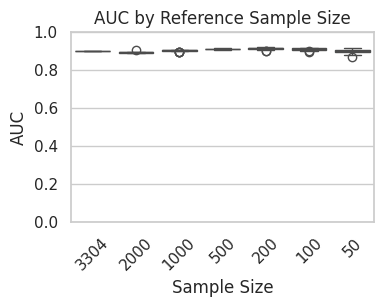

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="auc", data=metrics)
plt.title('AUC by Reference Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('calcagno_subsampled_ref_auc.svg')

plt.show()

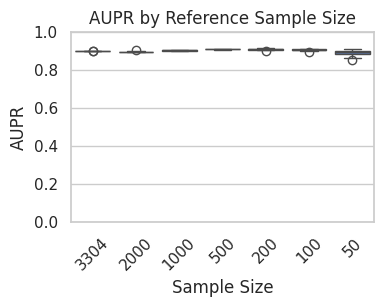

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="aupr", data=metrics)
plt.title('AUPR by Reference Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUPR")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('calcagno_subsampled_ref_aupr.svg')

plt.show()

## Subsample only query

In [38]:
## Modify to the directory where outputs should be stored
OUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/outputs"
metrics_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-que-metrics.csv"
results_csv_path = f"{OUT_PATH}/scpss-mouse-infarcted-heart-subsampled-que-results.csv"

In [ ]:
import time
import sys
from preprocess_calcagno import get_preprocessed_anndata
import scanpy as sc

with open(metrics_csv_path, 'w') as f:
    print('sample_size', 'seed', 'accuracy', 'precision', 'recall', 'f1', 'auc', 'aupr', 'time', sep=',', file=f, flush=True)
    for sample_size in (50, 100, 200, 500, 1_000, 2_000, 5_000, 10_000, 11_475):
        for ri in range(25):
            print("RUN", ri)
            ad_full = get_preprocessed_anndata('ref_0_que_1-7', DATA_DIR)
            ad_ref = ad_full[ad_full.obs['dataset'] == 'reference'].copy()
            ad_que = ad_full[ad_full.obs['dataset'] == 'query'].copy()
            ad_que_sub = sc.pp.subsample(ad_que.copy(), n_obs=sample_size, random_state=ri * 100, copy=True)

            # Combine the subsampled reference with all query cells
            ad = ad_que_sub.concatenate(ad_ref, batch_key=None)

            print(ad)

            start = time.perf_counter()

            reference_samples = list(ad.obs[ad.obs['dataset'] == 'reference']['sample'].unique())
            query_samples = list(ad.obs[ad.obs['dataset'] == 'query']['sample'].unique())

            from scpss import scPSS

            scpss = scPSS(ad, 'sample', reference_samples, query_samples)
            scpss.harmony_integrate()
            params = scpss.find_optimal_parameters()
            scpss.set_distance_and_condition()

            ad_que = scpss.adata[scpss.query_mask]

            true_labels = ad_que.obs['zone'].isin(['BZ1', 'BZ2']).to_numpy()
            predicted_labels = ad_que.obs['scpss_condition'].isin(['pathological']).to_numpy()
            predicted_scores = ad_que.obs['scpss_scores']

            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            print("Accuracy:", accuracy)
            print("Precision:", precision)
            print("Recall:", recall)
            print("F1-score:", f1)

            from sklearn.metrics import roc_auc_score, average_precision_score
            import matplotlib.pyplot as plt
            from sklearn.metrics import roc_curve, precision_recall_curve

            y_true = true_labels
            y_scores = predicted_scores

            # Calculate AUC
            auc = roc_auc_score(y_true, y_scores)
            print("AUC:", auc)

            # Calculate AUPR
            aupr = average_precision_score(y_true, y_scores)
            print("AUPR:", aupr)

            end = time.perf_counter()

            print(sample_size, ri*100, accuracy, precision, recall, f1, auc, aupr, f'{end - start:.4f}', sep=',',file=f, flush=True)


RUN 0
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:26:16,641 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:26:17,413 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:26:17,462 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:26:18,583 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:26:19,698 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 02:26:20,809 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.48
Precision: 1.0
Recall: 0.037037037037037035
F1-score: 0.07142857142857142
AUC: 0.8132045088566827
AUPR: 0.8196869966616731
RUN 1
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:28:03,901 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:28:04,606 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:28:04,653 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:28:07,416 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:28:09,324 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 02:28:10,456 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.46
Precision: 1.0
Recall: 0.06896551724137931
F1-score: 0.12903225806451613
AUC: 0.7405582922824303
AUPR: 0.7991481510653047
RUN 2
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:29:55,934 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:29:56,663 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:29:56,711 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:29:57,756 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:29:58,871 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.36
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7986111111111112
AUPR: 0.8673066606482751
RUN 3
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:31:56,614 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:31:57,392 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:31:57,443 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:31:58,536 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:31:59,629 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.52
Precision: 0.75
Recall: 0.11538461538461539
F1-score: 0.2
AUC: 0.7772435897435898
AUPR: 0.7622944570963059
RUN 4
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:33:49,777 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:33:50,485 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:33:50,534 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:33:51,635 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:33:52,801 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.54
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7600644122383252
AUPR: 0.7549864094483327
RUN 5
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:35:39,518 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:35:40,314 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:35:40,365 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:35:41,486 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:35:42,607 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.904
AUPR: 0.9074804435831291
RUN 6
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:37:22,102 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:37:22,887 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:37:22,929 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:37:24,042 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:37:25,137 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.66
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8449197860962566
AUPR: 0.7097170323370015
RUN 7
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:39:04,892 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:39:05,725 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:39:05,825 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:39:08,387 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:39:09,672 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.58
Precision: 1.0
Recall: 0.08695652173913043
F1-score: 0.16
AUC: 0.8582930756843801
AUPR: 0.8569053790639127
RUN 8
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:40:51,338 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:40:52,080 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:40:52,130 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:40:53,278 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:40:54,382 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.5
Precision: 1.0
Recall: 0.038461538461538464
F1-score: 0.07407407407407407
AUC: 0.8461538461538461
AUPR: 0.8466368167695855
RUN 9
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:42:47,062 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:42:47,800 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:42:47,839 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:42:48,931 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:42:50,016 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 02:42:51,123 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 02:42:53,163 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 02:42:55,164 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 02:42:56,532 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 02:42:57,621 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 02:42:58,505 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.48
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7131410256410257
AUPR: 0.684781178278079
RUN 10
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:44:47,213 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:44:48,063 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:44:48,130 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:44:49,211 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:44:50,302 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.56
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8133116883116883
AUPR: 0.8103004450534094
RUN 11
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:46:38,875 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:46:39,664 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:46:39,701 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:46:40,815 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:46:41,940 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.875
AUPR: 0.8292565973757925
RUN 12
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:48:29,821 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:48:30,587 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:48:30,640 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:48:31,764 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:48:32,891 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.58
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7274220032840722
AUPR: 0.5948045249295794
RUN 13
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:50:20,852 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:50:21,656 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:50:21,705 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:50:22,822 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:50:23,997 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.56
Precision: 1.0
Recall: 0.043478260869565216
F1-score: 0.08333333333333333
AUC: 0.7342995169082126
AUPR: 0.7197902525203977
RUN 14
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:52:12,537 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:52:13,326 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:52:13,369 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:52:14,474 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:52:15,586 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.44
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7272727272727272
AUPR: 0.7561488864563695
RUN 15
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:54:04,999 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:54:05,741 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:54:05,789 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:54:06,902 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:54:07,992 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.52
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.6698717948717948
AUPR: 0.6242875263449618
RUN 16
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:55:56,701 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:55:57,512 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:55:57,573 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:55:58,652 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:55:59,730 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.4
Precision: 1.0
Recall: 0.03225806451612903
F1-score: 0.0625
AUC: 0.7911714770797962
AUPR: 0.8769470671788719
RUN 17
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:57:49,516 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:57:50,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:57:50,328 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:57:51,402 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:57:52,459 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.52
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8044871794871794
AUPR: 0.814911550921129
RUN 18
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 02:59:40,693 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 02:59:41,425 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 02:59:41,466 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 02:59:42,545 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 02:59:43,689 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 02:59:46,507 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.69
AUPR: 0.8057743204723354
RUN 19
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:01:35,912 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:01:36,712 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:01:36,823 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:01:39,375 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:01:40,620 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:01:41,700 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.42
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.6847290640394089
AUPR: 0.7898045554749102
RUN 20
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:03:28,238 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:03:29,053 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:03:29,099 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:03:32,277 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:03:33,531 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.58
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7027914614121511
AUPR: 0.659675232036409
RUN 21
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:05:17,773 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:05:18,519 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:05:18,557 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:05:19,689 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:05:20,824 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.56
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7678571428571429
AUPR: 0.6692917315291272
RUN 22
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:07:02,946 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:07:03,738 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:07:03,786 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:07:04,926 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:07:06,069 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7583333333333333
AUPR: 0.6900059187717469
RUN 23
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:08:48,144 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:08:48,952 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:08:48,993 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:08:50,106 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:08:51,234 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.56
Precision: 1.0
Recall: 0.043478260869565216
F1-score: 0.08333333333333333
AUC: 0.7616747181964574
AUPR: 0.7485153385214283
RUN 24
AnnData object with n_obs × n_vars = 3354 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:10:32,047 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:10:32,815 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:10:32,855 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:10:33,942 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:10:35,018 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.56
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7467532467532468
AUPR: 0.6861271687885444
RUN 0
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:12:17,216 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:12:18,000 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:12:18,041 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:12:19,167 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:12:20,302 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:12:21,508 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.49
Precision: 1.0
Recall: 0.05555555555555555
F1-score: 0.10526315789473684
AUC: 0.786231884057971
AUPR: 0.7744313758678814
RUN 1
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:14:11,232 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:14:12,002 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:14:12,055 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:14:13,192 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:14:14,381 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:14:15,582 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:14:17,820 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:14:20,367 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:14:21,057 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:14:21,582 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:14:22,140 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7729166666666667
AUPR: 0.8398890355292784
RUN 2
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:16:04,106 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:16:04,861 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:16:04,913 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:16:06,044 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:16:07,175 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.64
Precision: 0.8928571428571429
Recall: 0.43103448275862066
F1-score: 0.5813953488372093
AUC: 0.8210180623973727
AUPR: 0.8635311429853372
RUN 3
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:17:49,352 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:17:50,118 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:17:50,175 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:17:51,413 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:17:52,518 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:17:53,627 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.49
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8611444577831133
AUPR: 0.8792785371119106
RUN 4
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:19:36,342 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:19:37,122 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:19:37,162 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:19:38,261 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:19:39,355 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:19:41,486 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:19:44,047 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:19:44,913 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:19:45,964 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:19:46,585 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:19:47,299 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.54
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.6984702093397746
AUPR: 0.6170573743592336
RUN 5
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:21:30,427 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:21:31,193 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:21:31,258 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:21:32,389 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:21:33,560 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.47
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8875953432356484
AUPR: 0.8968877918200886
RUN 6
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:23:17,526 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:23:18,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:23:18,323 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:23:19,394 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:23:20,471 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:23:21,568 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:23:22,665 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:23:23,533 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:23:24,618 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:23:25,324 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:23:27,374 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.65
Precision: 1.0
Recall: 0.07894736842105263
F1-score: 0.14634146341463414
AUC: 0.8786078098471986
AUPR: 0.8430203169277867
RUN 7
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:25:12,135 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:25:12,890 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:25:12,940 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:25:14,064 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:25:15,160 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.55
Precision: 1.0
Recall: 0.1
F1-score: 0.18181818181818182
AUC: 0.7899999999999999
AUPR: 0.8125272790330039
RUN 8
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:27:01,378 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:27:02,191 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:27:02,229 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:27:03,340 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:27:04,428 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:27:05,522 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:27:06,618 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:27:07,474 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:27:08,555 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:27:09,326 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:27:10,215 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.57
Precision: 1.0
Recall: 0.022727272727272728
F1-score: 0.044444444444444446
AUC: 0.8043831168831169
AUPR: 0.7666610087469753
RUN 9
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:28:59,663 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:29:00,429 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:29:00,494 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:29:01,604 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:29:03,737 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:29:06,216 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:29:07,443 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:29:08,559 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:29:09,358 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:29:10,455 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:29:11,175 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.52
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7888621794871795
AUPR: 0.7603330613887351
RUN 10
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:31:01,407 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:31:02,154 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:31:02,195 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:31:03,277 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:31:04,359 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.54
Precision: 1.0
Recall: 0.02127659574468085
F1-score: 0.041666666666666664
AUC: 0.8398233641107989
AUPR: 0.8422281428872079
RUN 11
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:32:46,590 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:32:47,407 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:32:47,501 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:32:50,071 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:32:51,347 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:32:52,459 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:32:53,350 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:32:54,284 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:32:55,246 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:32:56,383 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:32:56,911 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8008333333333334
AUPR: 0.7517987098781374
RUN 12
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:34:38,601 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:34:39,373 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:34:39,439 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:34:42,659 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:34:44,081 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:34:45,191 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.57
Precision: 1.0
Recall: 0.022727272727272728
F1-score: 0.044444444444444446
AUC: 0.7617694805194806
AUPR: 0.7013170955724362
RUN 13
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:36:26,241 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:36:27,026 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:36:27,080 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:36:28,225 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:36:29,347 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.59
Precision: 0.8571428571428571
Recall: 0.13043478260869565
F1-score: 0.22641509433962265
AUC: 0.8325281803542673
AUPR: 0.8230302100807374
RUN 14
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:38:10,815 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:38:11,646 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:38:11,746 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:38:14,437 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:38:15,719 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.6
Precision: 0.7777777777777778
Recall: 0.15555555555555556
F1-score: 0.25925925925925924
AUC: 0.6779797979797979
AUPR: 0.6223349973509157
RUN 15
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:39:58,208 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:39:59,007 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:39:59,048 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:40:00,182 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:40:01,311 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.54
Precision: 1.0
Recall: 0.1320754716981132
F1-score: 0.23333333333333334
AUC: 0.8024889602569248
AUPR: 0.8332728744234197
RUN 16
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:41:50,817 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:41:51,530 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:41:51,580 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:41:52,687 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:41:53,806 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.55
Precision: 1.0
Recall: 0.1509433962264151
F1-score: 0.26229508196721313
AUC: 0.857888398233641
AUPR: 0.8903131754816749
RUN 17
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:43:35,366 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:43:36,199 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:43:36,281 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:43:37,473 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:43:38,639 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.46
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8095813204508856
AUPR: 0.8246681765707048
RUN 18
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:45:20,033 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:45:20,795 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:45:20,838 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:45:21,967 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:45:23,072 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.4
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8591666666666666
AUPR: 0.9043613419788231
RUN 19
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:47:04,684 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:47:05,469 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:47:05,595 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:47:07,458 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:47:08,555 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.52
Precision: 1.0
Recall: 0.02040816326530612
F1-score: 0.04
AUC: 0.8447378951580632
AUPR: 0.8639109284978461
RUN 20
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:48:50,119 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:48:50,852 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:48:50,903 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:48:52,011 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:48:53,114 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 03:48:54,204 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 03:48:55,305 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 03:48:55,989 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 03:48:58,236 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 03:49:00,394 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 03:49:01,095 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.57
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.7976336189310484
AUPR: 0.7919910750190055
RUN 21
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:50:43,599 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:50:44,364 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:50:44,427 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:50:45,528 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:50:46,617 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.62
Precision: 0.9166666666666666
Recall: 0.22916666666666666
F1-score: 0.36666666666666664
AUC: 0.8024839743589743
AUPR: 0.7970915841288124
RUN 22
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:52:30,262 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:52:31,049 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:52:31,100 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:52:32,216 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:52:33,295 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.62
Precision: 1.0
Recall: 0.13636363636363635
F1-score: 0.24
AUC: 0.8031655844155844
AUPR: 0.7510445022824319
RUN 23
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:54:18,576 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:54:19,328 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:54:19,372 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:54:22,622 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:54:24,086 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.61
Precision: 0.6666666666666666
Recall: 0.05
F1-score: 0.09302325581395349
AUC: 0.7083333333333333
AUPR: 0.6033488943372083
RUN 24
AnnData object with n_obs × n_vars = 3404 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:56:14,640 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:56:15,441 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:56:15,491 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:56:16,575 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:56:17,670 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.61
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8192517864649013
AUPR: 0.7554298951220377
RUN 0
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:58:04,502 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:58:05,316 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:58:05,419 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:58:07,460 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 03:58:08,671 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.5
Precision: 1.0
Recall: 0.10714285714285714
F1-score: 0.1935483870967742
AUC: 0.885551948051948
AUPR: 0.9077742866905983
RUN 1
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 03:59:56,979 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 03:59:57,813 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 03:59:57,898 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 03:59:59,407 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:00:00,635 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:00:01,874 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:00:03,097 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:00:04,331 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:00:05,537 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:00:06,376 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:00:07,397 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.735
Precision: 0.8554216867469879
Recall: 0.6339285714285714
F1-score: 0.7282051282051282
AUC: 0.8329951298701298
AUPR: 0.8385927631193945
RUN 2
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:01:50,981 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:01:51,857 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:01:51,898 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:01:53,106 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:01:54,290 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:01:55,504 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:01:56,717 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:01:57,949 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:01:59,086 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:01:59,949 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:02:01,272 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.455
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8190341768323419
AUPR: 0.8376804084177321
RUN 3
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:03:47,813 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:03:48,565 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:03:48,604 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:03:49,798 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:03:50,982 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.63
Precision: 0.9473684210526315
Recall: 0.1978021978021978
F1-score: 0.32727272727272727
AUC: 0.9044258493799778
AUPR: 0.8969373824120928
RUN 4
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:05:34,043 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:05:34,932 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:05:34,978 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:05:36,228 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:05:37,412 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:05:38,614 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:05:39,693 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:05:40,319 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:05:40,985 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:05:41,665 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:05:42,333 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.55
Precision: 0.8888888888888888
Recall: 0.08247422680412371
F1-score: 0.1509433962264151
AUC: 0.7646882193974577
AUPR: 0.7305880558033558
RUN 5
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:07:27,483 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:07:28,326 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:07:28,365 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:07:29,621 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:07:30,859 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.725
Precision: 0.8947368421052632
Recall: 0.51
F1-score: 0.6496815286624203
AUC: 0.8584
AUPR: 0.8291877293783008
RUN 6
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:09:13,679 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:09:14,513 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:09:14,596 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:09:17,818 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:09:19,184 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:09:20,366 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:09:21,407 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:09:22,608 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:09:24,570 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:09:26,879 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:09:28,564 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.645
Precision: 0.9
Recall: 0.20689655172413793
F1-score: 0.3364485981308411
AUC: 0.8122266300478079
AUPR: 0.7675259362310383
RUN 7
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:11:18,572 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:11:19,344 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:11:19,388 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:11:20,599 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:11:21,823 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.735
Precision: 0.8591549295774648
Recall: 0.5865384615384616
F1-score: 0.6971428571428572
AUC: 0.8293269230769231
AUPR: 0.8578188618083316
RUN 8
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:13:03,890 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:13:04,643 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:13:04,704 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:13:05,902 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:13:07,164 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:13:08,339 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:13:09,539 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:13:10,274 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:13:11,158 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:13:11,769 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:13:12,332 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.545
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8290150216755721
AUPR: 0.8000582628867361
RUN 9
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:14:56,099 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:14:56,870 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:14:56,920 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:14:58,148 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:14:59,323 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:15:00,502 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:15:01,663 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:15:02,566 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:15:03,130 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:15:03,735 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:15:04,272 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.555
Precision: 1.0
Recall: 0.09183673469387756
F1-score: 0.16822429906542055
AUC: 0.880952380952381
AUPR: 0.8745618174018898
RUN 10
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:16:51,304 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:16:52,062 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:16:52,119 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:16:53,300 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:16:54,461 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.54
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.893719806763285
AUPR: 0.8928005065479518
RUN 11
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:18:36,567 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:18:37,494 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:18:37,607 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:18:39,391 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:18:40,626 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.585
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8418288538770466
AUPR: 0.8137668321465735
RUN 12
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:20:23,559 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:20:24,304 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:20:24,346 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:20:25,555 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:20:26,718 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.72
Precision: 0.8979591836734694
Recall: 0.4631578947368421
F1-score: 0.6111111111111112
AUC: 0.8335839598997493
AUPR: 0.8352342392503513
RUN 13
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:22:10,182 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:22:10,959 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:22:11,004 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:22:12,195 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:22:13,386 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.75
Precision: 0.8888888888888888
Recall: 0.5217391304347826
F1-score: 0.6575342465753424
AUC: 0.856280193236715
AUPR: 0.8490674127877745
RUN 14
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:24:00,541 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:24:01,319 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:24:01,364 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:24:02,581 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:24:03,730 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.53
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8412284223203532
AUPR: 0.8261628298487489
RUN 15
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:25:52,699 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:25:53,428 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:25:53,476 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:25:54,670 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:25:55,845 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.49
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8661464585834333
AUPR: 0.8552142633330138
RUN 16
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:27:48,878 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:27:49,667 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:27:49,718 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:27:50,948 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:27:52,241 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.745
Precision: 0.8983050847457628
Recall: 0.5408163265306123
F1-score: 0.6751592356687898
AUC: 0.8585434173669467
AUPR: 0.8556604575462604
RUN 17
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:29:35,417 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:29:36,270 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:29:36,321 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:29:37,543 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:29:38,763 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.65
Precision: 0.8648648648648649
Recall: 0.32989690721649484
F1-score: 0.47761194029850745
AUC: 0.8346511860674607
AUPR: 0.819812278663057
RUN 18
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:31:20,452 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:31:21,239 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:31:21,280 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:31:23,458 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:31:26,204 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.465
Precision: 1.0
Recall: 0.044642857142857144
F1-score: 0.08547008547008547
AUC: 0.9052353896103896
AUPR: 0.91928727476613
RUN 19
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:33:08,582 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:33:09,369 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:33:09,408 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:33:10,587 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:33:11,774 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.53
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8636089923725412
AUPR: 0.8449864798481913
RUN 20
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:34:54,230 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:34:55,090 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:34:55,194 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:34:57,247 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:34:58,466 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.705
Precision: 0.9183673469387755
Recall: 0.45
F1-score: 0.6040268456375839
AUC: 0.8418000000000001
AUPR: 0.8615555399342467
RUN 21
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:36:40,129 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:36:40,928 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:36:40,979 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:36:42,172 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:36:43,348 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.78
Precision: 0.8985507246376812
Recall: 0.6262626262626263
F1-score: 0.7380952380952381
AUC: 0.905990599059906
AUPR: 0.9116632943971114
RUN 22
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:38:31,303 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:38:32,062 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:38:32,102 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:38:33,324 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:38:34,505 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.74
Precision: 0.975609756097561
Recall: 0.43956043956043955
F1-score: 0.6060606060606061
AUC: 0.8917229559431394
AUPR: 0.8848750909441405
RUN 23
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:40:16,771 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:40:17,623 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:40:17,721 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:40:19,493 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:40:20,664 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.675
Precision: 0.8421052631578947
Recall: 0.3516483516483517
F1-score: 0.49612403100775193
AUC: 0.8598649057364655
AUPR: 0.8170580250053681
RUN 24
AnnData object with n_obs × n_vars = 3504 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:42:02,029 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:42:02,793 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:42:02,845 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:42:04,018 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:42:05,218 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.565
Precision: 0.0
Recall: 0.0
F1-score: 0.0
AUC: 0.8887193571355915
AUPR: 0.8590645316550363
RUN 0
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:43:48,532 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:43:49,321 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:43:49,387 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:43:50,617 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:43:51,862 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.798
Precision: 0.7991967871485943
Recall: 0.796
F1-score: 0.7975951903807615
AUC: 0.8897599999999999
AUPR: 0.8956574132176389
RUN 1
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:45:34,737 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:45:35,555 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:45:35,606 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:45:36,883 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:45:39,883 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:45:41,996 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:45:43,192 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:45:44,175 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:45:45,047 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:45:45,723 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:45:46,276 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.7
Precision: 0.8260869565217391
Recall: 0.5215686274509804
F1-score: 0.6394230769230769
AUC: 0.8214805922368946
AUPR: 0.808308727911782
RUN 2
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:47:32,082 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:47:33,023 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:47:33,147 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:47:34,385 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:47:35,608 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 04:47:36,867 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 04:47:38,074 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 04:47:39,317 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 04:47:40,028 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 04:47:40,829 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 04:47:41,499 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.638
Precision: 0.8901098901098901
Recall: 0.32142857142857145
F1-score: 0.47230320699708456
AUC: 0.8375256016385049
AUPR: 0.8240326223999562
RUN 3
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:49:26,860 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:49:27,646 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:49:27,697 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:49:28,944 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:49:30,232 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.81
Precision: 0.7799227799227799
Recall: 0.8416666666666667
F1-score: 0.8096192384769539
AUC: 0.8977083333333333
AUPR: 0.8912383607711923
RUN 4
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:51:15,090 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:51:15,894 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:51:15,945 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:51:17,239 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:51:18,505 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.784
Precision: 0.7676348547717843
Recall: 0.7805907172995781
F1-score: 0.7740585774058577
AUC: 0.8683961431711348
AUPR: 0.863425346481644
RUN 5
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:53:02,603 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:53:03,538 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:53:03,641 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:53:06,554 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:53:07,915 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.806
Precision: 0.7773279352226721
Recall: 0.8205128205128205
F1-score: 0.7983367983367984
AUC: 0.8947689737163421
AUPR: 0.8852979211787027
RUN 6
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:54:58,067 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:54:58,934 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:54:58,989 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:55:00,299 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:55:01,615 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.818
Precision: 0.868020304568528
Recall: 0.7245762711864406
F1-score: 0.789838337182448
AUC: 0.9057524396507446
AUPR: 0.8932450611072246
RUN 7
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:56:43,806 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:56:44,580 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:56:44,633 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:56:45,908 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:56:47,273 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.806
Precision: 0.868421052631579
Recall: 0.6962025316455697
F1-score: 0.7728337236533958
AUC: 0.9096597198825623
AUPR: 0.9035675566892335
RUN 8
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 04:58:29,469 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 04:58:30,297 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 04:58:30,366 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 04:58:31,654 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 04:58:32,949 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.794
Precision: 0.8393782383419689
Recall: 0.6923076923076923
F1-score: 0.7587822014051522
AUC: 0.9001188869609922
AUPR: 0.8882298195847259
RUN 9
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:00:15,590 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:00:16,459 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:00:16,554 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:00:20,006 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:00:21,390 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.822
Precision: 0.8198529411764706
Recall: 0.8479087452471483
F1-score: 0.8336448598130841
AUC: 0.9148096452808393
AUPR: 0.9305639037484755
RUN 10
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:02:05,891 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:02:06,725 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:02:06,770 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:02:08,022 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:02:09,282 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.802
Precision: 0.792156862745098
Recall: 0.8145161290322581
F1-score: 0.8031809145129225
AUC: 0.880568356374808
AUPR: 0.8794442155814993
RUN 11
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:03:54,533 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:03:55,307 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:03:55,367 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:03:56,723 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:03:58,011 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 05:03:59,321 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 05:04:00,855 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 05:04:03,744 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 05:04:04,808 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 05:04:05,580 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 05:04:06,395 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.55
Precision: 1.0
Recall: 0.06639004149377593
F1-score: 0.1245136186770428
AUC: 0.8166904307983146
AUPR: 0.8111647717712598
RUN 12
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:05:59,807 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:06:00,657 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:06:00,709 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:06:02,001 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:06:03,287 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 05:06:04,554 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 05:06:05,806 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 05:06:06,809 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 05:06:08,157 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 05:06:10,446 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 05:06:12,832 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.566
Precision: 0.8823529411764706
Recall: 0.06521739130434782
F1-score: 0.1214574898785425
AUC: 0.8013687600644122
AUPR: 0.7548508696029652
RUN 13
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:07:57,009 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:07:57,825 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:07:57,878 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:07:59,190 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:08:00,505 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.834
Precision: 0.8141592920353983
Recall: 0.8177777777777778
F1-score: 0.8159645232815964
AUC: 0.9173333333333333
AUPR: 0.8947170378476735
RUN 14
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:09:43,674 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:09:44,517 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:09:44,568 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:09:45,810 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:09:47,041 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.802
Precision: 0.7948717948717948
Recall: 0.7848101265822784
F1-score: 0.7898089171974523
AUC: 0.8776050440390816
AUPR: 0.8766129650334881
RUN 15
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:11:33,123 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:11:34,042 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:11:34,103 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:11:35,321 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:11:36,550 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.8181818181818182
Recall: 0.8114754098360656
F1-score: 0.8148148148148148
AUC: 0.9103643698770492
AUPR: 0.9101083185421376
RUN 16
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:13:19,444 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:13:20,262 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:13:20,308 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:13:21,573 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:13:23,849 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 05:13:26,533 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 05:13:27,942 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 05:13:28,941 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 05:13:29,702 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 05:13:30,371 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 05:13:31,013 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.582
Precision: 0.84375
Recall: 0.11688311688311688
F1-score: 0.20532319391634982
AUC: 0.7882489257953942
AUPR: 0.756502027426907
RUN 17
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:15:15,376 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:15:16,260 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:15:16,340 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:15:19,348 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:15:20,646 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.792
Precision: 0.8382352941176471
Recall: 0.7066115702479339
F1-score: 0.7668161434977578
AUC: 0.890031392145557
AUPR: 0.8921445380739392
RUN 18
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:17:05,673 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:17:06,482 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:17:06,538 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:17:07,762 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:17:10,198 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.814
Precision: 0.7969348659003831
Recall: 0.8387096774193549
F1-score: 0.8172888015717092
AUC: 0.9036258320532515
AUPR: 0.9074609306603021
RUN 19
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:18:53,670 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:18:54,453 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:18:54,499 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:18:55,709 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:18:56,918 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.816
Precision: 0.820627802690583
Recall: 0.7787234042553192
F1-score: 0.7991266375545851
AUC: 0.8951585708550782
AUPR: 0.8826289303521938
RUN 20
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:20:39,570 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:20:40,462 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:20:40,604 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:20:42,447 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:20:43,712 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.812
Precision: 0.8768472906403941
Recall: 0.7206477732793523
F1-score: 0.7911111111111111
AUC: 0.9126914275655693
AUPR: 0.9048468731756611
RUN 21
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:22:30,724 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:22:31,667 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:22:31,781 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:22:34,649 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:22:36,040 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 05:22:37,289 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.83
Precision: 0.8394495412844036
Recall: 0.7854077253218884
F1-score: 0.811529933481153
AUC: 0.9127967722749996
AUPR: 0.9117179304001265
RUN 22
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:24:20,319 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:24:21,095 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:24:21,162 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:24:22,415 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:24:23,674 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-21 05:24:25,868 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-21 05:24:28,468 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-21 05:24:29,450 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-21 05:24:30,126 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-21 05:24:30,898 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-21 05:24:31,490 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.712
Precision: 0.890625
Recall: 0.4672131147540984
F1-score: 0.6129032258064516
AUC: 0.8632012038934427
AUPR: 0.8471302767721389
RUN 23
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:26:15,480 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:26:16,341 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:26:16,384 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:26:17,744 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:26:21,169 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.812
Precision: 0.8578680203045685
Recall: 0.7191489361702128
F1-score: 0.7824074074074074
AUC: 0.9033159373745484
AUPR: 0.8954831517584978
RUN 24
AnnData object with n_obs × n_vars = 3804 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:28:04,218 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:28:05,079 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:28:05,120 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:28:06,398 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:28:07,683 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.788
Precision: 0.7569721115537849
Recall: 0.8085106382978723
F1-score: 0.7818930041152263
AUC: 0.8878362103572861
AUPR: 0.885486155452532
RUN 0
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:29:50,651 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:29:51,642 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:29:51,695 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:29:53,168 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:29:54,679 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.821
Precision: 0.8076190476190476
Recall: 0.8446215139442231
F1-score: 0.8257059396299903
AUC: 0.9030344485511769
AUPR: 0.9094609462093755
RUN 1
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:31:39,009 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:31:39,968 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:31:40,133 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:31:43,578 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:31:45,205 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.822
Precision: 0.8107074569789675
Recall: 0.8429423459244533
F1-score: 0.8265107212475633
AUC: 0.9001924069266493
AUPR: 0.9053642211297342
RUN 2
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:33:30,092 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:33:30,978 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:33:31,034 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:33:32,492 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:33:35,500 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.801
Precision: 0.7964426877470355
Recall: 0.8076152304609219
F1-score: 0.8019900497512438
AUC: 0.9037636150544602
AUPR: 0.9076949589232386
RUN 3
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:35:24,416 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:35:25,423 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:35:25,514 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:35:29,009 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:35:30,608 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.802
Precision: 0.7576853526220615
Recall: 0.8674948240165632
F1-score: 0.8088803088803089
AUC: 0.9031280159864803
AUPR: 0.903024969927289
RUN 4
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:37:15,001 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:37:15,860 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:37:15,916 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:37:17,411 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:37:19,130 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.795
Precision: 0.7538461538461538
Recall: 0.835820895522388
F1-score: 0.7927199191102123
AUC: 0.8876039495821939
AUPR: 0.8847062374571871
RUN 5
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:39:03,947 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:39:04,846 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:39:04,893 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:39:06,385 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:39:07,858 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.797
Precision: 0.7581227436823105
Recall: 0.8588957055214724
F1-score: 0.8053691275167785
AUC: 0.9054902572845258
AUPR: 0.9063203133785407
RUN 6
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:40:52,791 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:40:53,651 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:40:53,708 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:40:55,154 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:40:56,628 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.831
Precision: 0.8054968287526427
Recall: 0.8318777292576419
F1-score: 0.8184747583243824
AUC: 0.9157736992217085
AUPR: 0.9001502074326577
RUN 7
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:42:41,146 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:42:42,033 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:42:42,089 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:42:43,544 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:42:44,998 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.801
Precision: 0.758893280632411
Recall: 0.8329718004338394
F1-score: 0.7942088934850051
AUC: 0.9054849705608925
AUPR: 0.8982965992843904
RUN 8
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:44:29,978 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:44:30,972 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:44:31,032 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:44:34,037 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:44:35,576 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.808
Precision: 0.7793522267206477
Recall: 0.8226495726495726
F1-score: 0.8004158004158004
AUC: 0.8937688773215088
AUPR: 0.8908676589045436
RUN 9
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:46:21,306 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:46:22,181 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:46:22,224 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:46:24,884 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:46:27,777 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.815
Precision: 0.8015717092337917
Recall: 0.8292682926829268
F1-score: 0.8151848151848152
AUC: 0.9016268164650151
AUPR: 0.910754382119226
RUN 10
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:48:12,685 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:48:13,563 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:48:13,618 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:48:15,077 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:48:16,564 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.786
Precision: 0.7490774907749077
Recall: 0.8388429752066116
F1-score: 0.7914230019493177
AUC: 0.8857349926324556
AUPR: 0.8871179801869568
RUN 11
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:50:05,298 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:50:06,172 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:50:06,226 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:50:08,114 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:50:11,650 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.816
Precision: 0.7839388145315488
Recall: 0.8523908523908524
F1-score: 0.8167330677290837
AUC: 0.9094973141215916
AUPR: 0.9119580596860523
RUN 12
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:52:06,474 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:52:07,328 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:52:07,394 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:52:08,908 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:52:10,443 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.801
Precision: 0.789587852494577
Recall: 0.7811158798283262
F1-score: 0.785329018338727
AUC: 0.8938129912716402
AUPR: 0.8896253146523552
RUN 13
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:53:55,432 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:53:56,336 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:53:56,401 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:53:57,908 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:53:59,400 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.816
Precision: 0.7744510978043913
Recall: 0.8453159041394336
F1-score: 0.8083333333333333
AUC: 0.9062737849298684
AUPR: 0.8945579663426324
RUN 14
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:55:42,925 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:55:43,955 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:55:44,049 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:55:45,924 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:55:47,426 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.824
Precision: 0.8152866242038217
Recall: 0.8118393234672304
F1-score: 0.8135593220338984
AUC: 0.9087699732419736
AUPR: 0.9033524677178808
RUN 15
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:57:32,140 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:57:33,138 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:57:33,198 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:57:35,329 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:57:38,841 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.826
Precision: 0.8041825095057035
Recall: 0.8562753036437247
F1-score: 0.8294117647058824
AUC: 0.9171320670176506
AUPR: 0.9134946963149061
RUN 16
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 05:59:23,502 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 05:59:24,376 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 05:59:24,418 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 05:59:25,931 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 05:59:27,416 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.813
Precision: 0.7879377431906615
Recall: 0.8385093167701864
F1-score: 0.8124373119358074
AUC: 0.9023310947455259
AUPR: 0.904824694478889
RUN 17
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:01:13,070 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:01:14,017 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:01:14,080 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:01:15,564 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:01:17,040 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.803
Precision: 0.8048780487804879
Recall: 0.7967806841046278
F1-score: 0.8008088978766431
AUC: 0.8984523442843942
AUPR: 0.9024105016539347
RUN 18
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:03:02,073 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:03:02,988 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:03:03,054 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:03:04,546 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:03:06,054 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.817
Precision: 0.7996108949416343
Recall: 0.8370672097759674
F1-score: 0.817910447761194
AUC: 0.9154406027552928
AUPR: 0.91285487911939
RUN 19
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:04:52,013 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:04:52,914 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:04:52,981 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:04:54,462 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:04:55,959 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.816
Precision: 0.7693726937269373
Recall: 0.8760504201680672
F1-score: 0.8192534381139489
AUC: 0.9104496760536276
AUPR: 0.9071780507657768
RUN 20
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:06:40,495 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:06:41,398 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:06:41,454 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:06:42,954 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:06:44,457 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.839
Precision: 0.8355640535372849
Recall: 0.853515625
F1-score: 0.8444444444444444
AUC: 0.9134581518954918
AUPR: 0.9139364673467583
RUN 21
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:08:31,498 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:08:32,439 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:08:32,488 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:08:33,958 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:08:35,437 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.812
Precision: 0.7680311890838206
Recall: 0.8509719222462203
F1-score: 0.8073770491803278
AUC: 0.900820895222237
AUPR: 0.8917704986033933
RUN 22
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:10:21,285 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:10:22,339 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:10:22,400 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:10:24,145 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:10:25,562 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.79
Precision: 0.7554671968190855
Recall: 0.8137044967880086
F1-score: 0.7835051546391752
AUC: 0.8863409009646017
AUPR: 0.8810528505409854
RUN 23
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:12:17,044 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:12:17,923 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:12:17,979 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:12:19,430 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:12:20,922 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.814
Precision: 0.7764932562620424
Recall: 0.8520084566596194
F1-score: 0.8125
AUC: 0.9092794589021588
AUPR: 0.9091073217181413
RUN 24
AnnData object with n_obs × n_vars = 4304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:14:07,372 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:14:08,376 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:14:08,434 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:14:09,970 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:14:11,459 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.799
Precision: 0.7609942638623327
Recall: 0.8396624472573839
F1-score: 0.79839518555667
AUC: 0.8964078869262486
AUPR: 0.8919542383790561
RUN 0
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:15:58,975 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:16:01,209 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:16:01,269 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:16:03,100 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:16:04,833 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8205
Precision: 0.8018518518518518
Recall: 0.8565776458951533
F1-score: 0.8283118125298901
AUC: 0.9113352715678598
AUPR: 0.9180653701845114
RUN 1
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:17:54,583 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:17:56,926 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:17:56,988 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:17:58,708 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:18:01,481 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8285
Precision: 0.8047105004906772
Recall: 0.8506224066390041
F1-score: 0.827029752899647
AUC: 0.9100404123744374
AUPR: 0.9093659238964404
RUN 2
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:19:57,747 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:20:00,096 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:20:00,158 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:20:02,059 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:20:04,052 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.819
Precision: 0.7939508506616257
Recall: 0.8536585365853658
F1-score: 0.8227228207639569
AUC: 0.9080924716727481
AUPR: 0.9098694716292579
RUN 3
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:21:52,361 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:21:54,773 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:21:54,834 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:21:59,012 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:22:01,047 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.819
Precision: 0.7866541353383458
Recall: 0.8611111111111112
F1-score: 0.8222003929273084
AUC: 0.9117728298986405
AUPR: 0.911935474921348
RUN 4
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:23:49,483 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:23:51,859 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:23:51,922 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:23:53,765 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:23:55,547 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8215
Precision: 0.7971745711402624
Recall: 0.8350951374207188
F1-score: 0.8156943727413526
AUC: 0.9095131403171648
AUPR: 0.9085106243394652
RUN 5
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:25:44,111 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:25:46,427 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:25:46,503 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:25:48,285 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:25:50,074 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8185
Precision: 0.7775590551181102
Recall: 0.8522114347357066
F1-score: 0.8131755018013381
AUC: 0.9088170862526403
AUPR: 0.9015655815278597
RUN 6
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:27:36,581 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:27:38,878 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:27:38,930 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:27:40,701 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:27:42,436 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.825
Precision: 0.79
Recall: 0.8494623655913979
F1-score: 0.8186528497409327
AUC: 0.9142307305798412
AUPR: 0.9068019623714035
RUN 7
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:29:31,693 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:29:35,245 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:29:35,367 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:29:39,144 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:29:41,017 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8115
Precision: 0.7679245283018868
Recall: 0.8613756613756614
F1-score: 0.8119700748129676
AUC: 0.9085644073321797
AUPR: 0.9059389614238557
RUN 8
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:31:32,200 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:31:34,471 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:31:34,536 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:31:36,348 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:31:38,159 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.7896281800391389
Recall: 0.8476890756302521
F1-score: 0.817629179331307
AUC: 0.9052386698954391
AUPR: 0.9027022699929721
RUN 9
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:33:27,256 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:33:29,565 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:33:29,644 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:33:31,684 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:33:35,934 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8265
Precision: 0.8072407045009785
Recall: 0.8461538461538461
F1-score: 0.8262393590385578
AUC: 0.9168630393996248
AUPR: 0.9192618921222099
RUN 10
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:35:22,099 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:35:24,421 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:35:24,490 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:35:28,840 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:35:30,703 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.808
Precision: 0.7758454106280194
Recall: 0.8408376963350785
F1-score: 0.807035175879397
AUC: 0.9007870938650768
AUPR: 0.8985337198396917
RUN 11
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:37:17,925 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:37:20,379 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:37:20,499 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:37:22,717 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:37:24,534 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8205
Precision: 0.8039014373716632
Recall: 0.8233438485804416
F1-score: 0.8135064935064935
AUC: 0.9128698003907383
AUPR: 0.9109858075939786
RUN 12
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:39:13,164 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:39:15,455 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:39:15,508 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:39:17,276 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:39:19,048 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.823
Precision: 0.791828793774319
Recall: 0.8532494758909853
F1-score: 0.8213925327951564
AUC: 0.9107591663960941
AUPR: 0.9069054607148704
RUN 13
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:41:06,267 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:41:08,582 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:41:08,652 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:41:10,388 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:41:12,134 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.807
Precision: 0.7647058823529411
Recall: 0.836423118865867
F1-score: 0.7989583333333333
AUC: 0.8979217831642183
AUPR: 0.8905947578236738
RUN 14
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:43:00,091 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:43:02,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:43:02,420 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:43:04,295 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:43:08,364 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.803
Precision: 0.7846153846153846
Recall: 0.8061116965226555
F1-score: 0.7952182952182952
AUC: 0.8939902686888598
AUPR: 0.8962463400649077
RUN 15
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:44:55,060 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:44:57,381 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:44:57,469 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:45:01,623 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:45:03,531 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.839
Precision: 0.8170254403131115
Recall: 0.8608247422680413
F1-score: 0.8383534136546185
AUC: 0.9200250225202683
AUPR: 0.9189468100701857
RUN 16
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:46:52,595 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:46:54,956 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:46:55,022 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:46:56,871 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:46:58,632 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8135
Precision: 0.7968596663395485
Recall: 0.8302658486707567
F1-score: 0.8132198297446169
AUC: 0.9051380868340275
AUPR: 0.9081183752042091
RUN 17
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:48:56,628 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:48:59,026 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:48:59,111 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:49:00,907 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:49:02,714 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.834
Precision: 0.839632277834525
Recall: 0.8244734202607823
F1-score: 0.8319838056680162
AUC: 0.9095671861046749
AUPR: 0.9134877073238242
RUN 18
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:50:51,018 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:50:53,431 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:50:53,485 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:50:55,241 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:50:57,002 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8065
Precision: 0.785501489572989
Recall: 0.8222453222453222
F1-score: 0.803453529710513
AUC: 0.8977473471693126
AUPR: 0.9009623754670588
RUN 19
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:52:45,837 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:52:48,148 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:52:48,224 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:52:50,016 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:52:54,140 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8295
Precision: 0.8172484599589322
Recall: 0.8300312825860271
F1-score: 0.8235902741852044
AUC: 0.9149570427889283
AUPR: 0.9130579481878223
RUN 20
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:54:42,495 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:54:44,877 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:54:44,994 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:54:47,860 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:54:49,625 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.83
Precision: 0.8019323671497585
Recall: 0.8601036269430051
F1-score: 0.83
AUC: 0.9132807689419538
AUPR: 0.9084116254062549
RUN 21
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:56:38,145 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:56:40,488 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:56:40,547 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:56:42,317 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:56:44,107 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8145
Precision: 0.7815040650406504
Recall: 0.8313513513513513
F1-score: 0.8056574122577266
AUC: 0.9074624764299184
AUPR: 0.9021406427229999
RUN 22
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 06:58:32,149 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 06:58:34,520 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 06:58:34,580 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 06:58:36,313 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 06:58:38,041 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.827
Precision: 0.7871485943775101
Recall: 0.8540305010893247
F1-score: 0.819226750261233
AUC: 0.9087313093238939
AUPR: 0.9005531676453056
RUN 23
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:00:26,339 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:00:28,655 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:00:28,731 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:00:30,991 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:00:35,081 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.822
Precision: 0.797808764940239
Recall: 0.839622641509434
F1-score: 0.8181818181818182
AUC: 0.9090084619053918
AUPR: 0.9053907874798834
RUN 24
AnnData object with n_obs × n_vars = 5304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:02:25,726 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:02:27,930 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:02:27,994 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:02:29,806 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:02:31,596 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.819
Precision: 0.8008048289738431
Recall: 0.8291666666666667
F1-score: 0.8147389969293757
AUC: 0.9034465144230768
AUPR: 0.9041994272643574
RUN 0
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:04:22,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:04:24,937 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:04:25,015 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:04:29,416 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:04:33,801 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8272
Precision: 0.8053949903660886
Recall: 0.8534095549203756
F1-score: 0.8287073750991277
AUC: 0.9139955683957436
AUPR: 0.9174497691851979
RUN 1
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:06:31,087 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:06:35,373 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:06:35,479 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:06:38,806 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:06:41,572 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8248
Precision: 0.8008113590263691
Recall: 0.8367952522255193
F1-score: 0.818407960199005
AUC: 0.9071362842346992
AUPR: 0.9059090771211855
RUN 2
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:08:40,147 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:08:44,304 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:08:44,369 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:08:47,164 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:08:49,940 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8248
Precision: 0.8160261651676206
Recall: 0.82411230388109
F1-score: 0.8200493015612161
AUC: 0.9064063321799973
AUPR: 0.9080829325212965
RUN 3
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:10:45,849 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:10:48,504 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:10:48,581 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:10:51,450 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:10:54,370 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8304
Precision: 0.810071371927042
Recall: 0.8470149253731343
F1-score: 0.828131333603567
AUC: 0.9146082762385908
AUPR: 0.9131456037718132
RUN 4
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:12:51,530 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:12:54,220 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:12:54,298 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:12:57,231 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:13:02,451 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8168
Precision: 0.7891637220259128
Recall: 0.8413562159899539
F1-score: 0.8144246353322528
AUC: 0.9050855294092562
AUPR: 0.9043334737912305
RUN 5
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:14:59,822 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:15:02,529 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:15:02,607 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:15:08,014 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:15:11,006 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8168
Precision: 0.785828025477707
Recall: 0.8392857142857143
F1-score: 0.8116776315789473
AUC: 0.908884352456995
AUPR: 0.9063644559855868
RUN 6
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:17:11,225 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:17:13,885 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:17:13,963 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:17:16,869 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:17:19,721 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8182
Precision: 0.7947154471544715
Recall: 0.8287409919457397
F1-score: 0.8113716538700976
AUC: 0.9070176669177588
AUPR: 0.9046495919263122
RUN 7
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:19:22,984 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:19:27,716 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:19:27,797 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:19:30,968 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:19:34,057 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8228
Precision: 0.8046159968165539
Recall: 0.8365742656185354
F1-score: 0.8202839756592292
AUC: 0.9102852728391343
AUPR: 0.9102076947904858
RUN 8
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:21:31,867 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:21:34,857 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:21:34,934 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:21:37,893 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:21:40,827 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8176
Precision: 0.7933980582524272
Recall: 0.8431696244325216
F1-score: 0.8175270108043218
AUC: 0.9074794312876967
AUPR: 0.9092900585286154
RUN 9
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:23:37,299 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:23:40,051 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:23:40,132 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:23:43,283 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:23:48,811 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.825
Precision: 0.8123226591001216
Recall: 0.8294701986754967
F1-score: 0.820806881015769
AUC: 0.9083749589937056
AUPR: 0.9096391773977559
RUN 10
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:25:48,532 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:25:51,326 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:25:51,462 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:25:56,180 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:25:59,102 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8222
Precision: 0.8055555555555556
Recall: 0.8222598391874736
F1-score: 0.8138219895287958
AUC: 0.908572639980768
AUPR: 0.9087041494737526
RUN 11
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:27:55,372 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:28:00,348 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:28:00,447 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:28:03,410 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:28:06,346 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8214
Precision: 0.7897862232779097
Recall: 0.8464149342384387
F1-score: 0.8171206225680934
AUC: 0.9123264260939512
AUPR: 0.909950546802526
RUN 12
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:30:12,815 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:30:17,917 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:30:18,006 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:30:20,790 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:30:23,628 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8236
Precision: 0.8030241111565182
Recall: 0.8308668076109936
F1-score: 0.816708229426434
AUC: 0.9098893974830606
AUPR: 0.9050442641390631
RUN 13
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:32:22,186 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:32:24,944 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:32:25,010 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:32:28,037 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:32:31,106 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8168
Precision: 0.7817965023847376
Recall: 0.8427592116538132
F1-score: 0.8111340206185567
AUC: 0.9058503379058134
AUPR: 0.9033294804092938
RUN 14
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:34:27,448 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:34:30,158 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:34:30,246 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:34:33,177 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:34:38,341 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8242
Precision: 0.8117206982543641
Recall: 0.8209331651954602
F1-score: 0.8163009404388715
AUC: 0.9082891618590042
AUPR: 0.9064414598076551
RUN 15
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:36:38,685 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:36:41,275 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:36:41,355 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:36:46,575 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:36:49,358 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8194
Precision: 0.8050986842105263
Recall: 0.8202764976958525
F1-score: 0.812616725461714
AUC: 0.9055782926750668
AUPR: 0.9076818896521656
RUN 16
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:38:47,946 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:38:52,005 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:38:52,096 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:38:55,064 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:38:57,970 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8246
Precision: 0.8045382165605095
Recall: 0.8396343996676361
F1-score: 0.8217117300264282
AUC: 0.907738885379143
AUPR: 0.9062249368563743
RUN 17
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:40:53,815 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:40:56,636 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:40:56,715 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:40:59,569 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:41:02,474 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8242
Precision: 0.8042013476020611
Recall: 0.8405136702568351
F1-score: 0.8219566538383634
AUC: 0.9106491457731422
AUPR: 0.910200003151361
RUN 18
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:42:59,940 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:43:02,700 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:43:02,777 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:43:05,544 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:43:10,638 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8264
Precision: 0.8011503697617092
Recall: 0.8354755784061697
F1-score: 0.8179530201342282
AUC: 0.9115998472625868
AUPR: 0.9059345313477482
RUN 19
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:45:09,148 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:45:11,873 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:45:11,949 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:45:16,971 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:45:19,777 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8208
Precision: 0.8111390284757118
Recall: 0.8131821998320738
F1-score: 0.8121593291404612
AUC: 0.9044241923927804
AUPR: 0.9047034311441183
RUN 20
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:47:21,341 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:47:24,084 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:47:24,151 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:47:26,973 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:47:31,331 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8292
Precision: 0.8105476673427991
Recall: 0.8377358490566038
F1-score: 0.8239175257731959
AUC: 0.9104445807328307
AUPR: 0.9090620857817148
RUN 21
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:49:33,414 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:49:38,386 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:49:38,451 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:49:41,311 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:49:44,220 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8206
Precision: 0.8013055895552835
Recall: 0.827295703454086
F1-score: 0.8140932642487047
AUC: 0.9053036160333031
AUPR: 0.9045481209670752
RUN 22
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:51:49,740 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:51:54,498 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:51:54,649 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:51:57,556 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:52:00,372 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.7980968142325197
Recall: 0.8240068346860316
F1-score: 0.8108448928121059
AUC: 0.9059784064148118
AUPR: 0.9023558541379539
RUN 23
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:53:58,666 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:54:01,375 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:54:01,449 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:54:04,410 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:54:07,321 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8236
Precision: 0.8110204081632653
Recall: 0.8258520365752285
F1-score: 0.8183690280065898
AUC: 0.9093778019613009
AUPR: 0.9095103783290628
RUN 24
AnnData object with n_obs × n_vars = 8304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:56:00,947 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:56:04,968 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:56:05,046 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:56:08,021 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:56:10,948 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.822
Precision: 0.808363784003248
Recall: 0.8264840182648402
F1-score: 0.8173234811165846
AUC: 0.9090092008307327
AUPR: 0.9112239249123655
RUN 0
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 07:58:06,052 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 07:58:10,151 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 07:58:10,255 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 07:58:15,296 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 07:58:22,139 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8212
Precision: 0.8115042416718394
Recall: 0.8172535944988539
F1-score: 0.8143687707641196
AUC: 0.9039973358546346
AUPR: 0.9045963825811499
RUN 1
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:00:27,183 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:00:30,327 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:00:30,437 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:00:35,069 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:00:41,308 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.817
Precision: 0.8135556980970707
Recall: 0.7988662607600252
F1-score: 0.8061440677966102
AUC: 0.9005546501658064
AUPR: 0.9029631794102935
RUN 2
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:02:57,567 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:03:00,974 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:03:01,085 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:03:05,674 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:03:12,328 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8191
Precision: 0.8033637873754153
Recall: 0.8177975058127246
F1-score: 0.8105163925840578
AUC: 0.9036337135658936
AUPR: 0.9030011738804384
RUN 3
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:05:20,091 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:05:23,257 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:05:23,360 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:05:29,667 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:05:33,860 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8209
Precision: 0.810126582278481
Recall: 0.8167364016736401
F1-score: 0.8134180643817064
AUC: 0.9042885426185094
AUPR: 0.9055646234059673
RUN 4
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:07:40,993 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:07:46,389 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:07:46,529 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:07:50,698 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:07:54,767 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.821
Precision: 0.8089934860264761
Recall: 0.8137814415556964
F1-score: 0.8113804004214963
AUC: 0.9054407840229074
AUPR: 0.9056206507668186
RUN 5
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:10:06,978 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:10:10,109 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:10:10,219 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:10:16,987 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:10:21,498 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8161
Precision: 0.8071984845295728
Recall: 0.8060109289617486
F1-score: 0.8066042696392891
AUC: 0.9033892034123455
AUPR: 0.9031814115415773
RUN 6
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:12:29,412 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:12:34,707 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:12:34,836 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:12:39,611 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:12:44,328 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8193
Precision: 0.8033092037228542
Recall: 0.8194092827004219
F1-score: 0.8112793733681463
AUC: 0.9058436813142738
AUPR: 0.9052775250854052
RUN 7
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:14:53,266 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:14:56,355 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:14:56,463 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:15:01,823 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:15:07,137 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8136
Precision: 0.8009105960264901
Recall: 0.8109807208717519
F1-score: 0.8059142024156601
AUC: 0.9006521801172488
AUPR: 0.9029856475757689
RUN 8
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:17:17,467 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:17:22,766 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:17:22,892 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:17:28,060 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:17:34,970 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.819
Precision: 0.810754043268221
Recall: 0.8093940029356259
F1-score: 0.8100734522560336
AUC: 0.904352686548276
AUPR: 0.9052386597979645
RUN 9
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:19:44,618 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:19:47,753 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:19:47,858 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:19:54,255 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:19:58,876 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8209
Precision: 0.8094736842105263
Recall: 0.812724582540689
F1-score: 0.8110958759624513
AUC: 0.9049981027084032
AUPR: 0.9034509334032311
RUN 10
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:22:09,414 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:22:12,585 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:22:12,693 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:22:17,533 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:22:23,944 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.817
Precision: 0.8041172800998129
Recall: 0.8132492113564669
F1-score: 0.8086574654956086
AUC: 0.902359725701409
AUPR: 0.9039411273694076
RUN 11
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:24:36,986 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:24:40,210 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:24:40,408 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:24:44,926 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:24:51,254 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8207
Precision: 0.8162438712428054
Recall: 0.8044117647058824
F1-score: 0.8102846259655063
AUC: 0.9057990409904421
AUPR: 0.9062185115499244
RUN 12
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:27:08,332 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:27:11,505 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:27:11,613 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:27:15,615 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:27:21,852 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.8108221476510067
Recall: 0.8115029387069689
F1-score: 0.8111624003357113
AUC: 0.9038632627312433
AUPR: 0.9051935399871369
RUN 13
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:29:35,321 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:29:39,461 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:29:39,573 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:29:44,009 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:29:50,470 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8191
Precision: 0.8069265864786396
Recall: 0.8158943174669742
F1-score: 0.8113856740694401
AUC: 0.9054856247368633
AUPR: 0.9060723410744499
RUN 14
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:31:57,258 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:32:00,517 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:32:00,627 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:32:06,738 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:32:11,910 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8212
Precision: 0.8141798941798942
Recall: 0.8087029640529746
F1-score: 0.8114321873022569
AUC: 0.9067406050394791
AUPR: 0.906472914482022
RUN 15
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:34:18,924 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:34:24,234 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:34:24,354 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:34:29,157 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:34:33,769 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8154
Precision: 0.8002861815208504
Recall: 0.8183528428093646
F1-score: 0.8092186854071931
AUC: 0.9024362025386256
AUPR: 0.9045807402251294
RUN 16
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:36:45,044 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:36:48,270 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:36:48,398 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:36:52,723 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:36:58,816 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8184
Precision: 0.8043567612001644
Recall: 0.8191712013394726
F1-score: 0.8116963915387806
AUC: 0.9026334955678226
AUPR: 0.9040956380564504
RUN 17
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:39:08,456 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:39:13,300 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:39:13,537 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:39:19,307 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:39:24,775 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8152
Precision: 0.8025849489264123
Recall: 0.8103557145864029
F1-score: 0.8064516129032258
AUC: 0.9025058907091944
AUPR: 0.9037023614640707
RUN 18
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:41:36,316 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:41:39,489 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:41:39,607 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:41:46,635 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:41:52,151 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8205
Precision: 0.8148542243030432
Recall: 0.8054270088346656
F1-score: 0.8101131915793928
AUC: 0.905275024936362
AUPR: 0.9058570929356515
RUN 19
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:43:59,301 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:44:02,675 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:44:02,788 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:44:07,615 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:44:14,501 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8198
Precision: 0.8105395232120451
Recall: 0.8122380553227159
F1-score: 0.8113879003558719
AUC: 0.9045861602782362
AUPR: 0.9053285374827983
RUN 20
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:46:21,424 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:46:24,574 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:46:24,686 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:46:31,026 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:46:35,228 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.808378266279552
Recall: 0.8165060745705907
F1-score: 0.8124218424343477
AUC: 0.903060027759113
AUPR: 0.9043911536162307
RUN 21
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:48:41,886 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:48:45,295 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:48:45,467 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:48:51,822 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:48:56,600 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8238
Precision: 0.813392107472712
Recall: 0.8161331086773378
F1-score: 0.8147603027754415
AUC: 0.9066399705876881
AUPR: 0.907736531067004
RUN 22
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:51:04,064 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:51:07,161 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:51:07,282 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:51:12,099 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:51:18,697 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.82
Precision: 0.8057825267127593
Recall: 0.8150031786395423
F1-score: 0.8103666245259166
AUC: 0.9039504733329939
AUPR: 0.9036566427584202
RUN 23
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:53:26,161 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:53:29,278 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:53:29,376 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:53:35,627 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:53:39,601 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8208
Precision: 0.8056478405315615
Recall: 0.8192567567567568
F1-score: 0.8123953098827471
AUC: 0.9057608362898424
AUPR: 0.9061447690902165
RUN 24
AnnData object with n_obs × n_vars = 13304 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:55:48,653 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:55:53,463 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:55:53,564 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:55:57,793 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:56:02,149 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8232
Precision: 0.8129072945133488
Recall: 0.8149631190727081
F1-score: 0.8139339086508104
AUC: 0.9066000667736783
AUPR: 0.9068191564739514
RUN 0
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 08:58:12,821 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 08:58:16,203 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 08:58:16,324 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 08:58:23,099 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 08:58:27,756 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8148148148148148
Precision: 0.8021041175403592
Recall: 0.8104838709677419
F1-score: 0.8062722217157444
AUC: 0.9008219450722761
AUPR: 0.9023838542247797
RUN 1
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:00:41,530 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:00:44,833 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:00:44,953 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:00:51,962 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:00:57,443 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169934640522876
Precision: 0.8100517368810052
Recall: 0.8035190615835777
F1-score: 0.8067721751932279
AUC: 0.90170389684864
AUPR: 0.9029693564773067
RUN 2
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:03:15,927 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:03:21,649 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:03:21,771 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:03:27,122 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:03:34,294 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.814640522875817
Precision: 0.8022516796804068
Recall: 0.8097507331378299
F1-score: 0.8059837635683663
AUC: 0.9011287996125661
AUPR: 0.9023872507285734
RUN 3
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:05:50,159 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:05:53,496 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:05:53,607 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:05:58,615 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:06:05,582 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8183006535947712
Precision: 0.8102337566721884
Recall: 0.8068181818181818
F1-score: 0.8085223620167141
AUC: 0.9014772197425649
AUPR: 0.9028230631080167
RUN 4
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:08:16,244 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:08:21,780 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:08:21,902 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:08:27,404 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:08:34,877 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8159477124183007
Precision: 0.8043319985438661
Recall: 0.8099340175953079
F1-score: 0.8071232876712329
AUC: 0.9007311097945461
AUPR: 0.9023158000228881
RUN 5
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:10:47,483 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:10:52,782 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:10:52,927 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:10:57,663 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:11:02,301 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8187363834422658
Precision: 0.8124768604220659
Recall: 0.8044354838709677
F1-score: 0.8084361760913612
AUC: 0.9023674237349077
AUPR: 0.9035061955004908
RUN 6
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:13:18,275 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:13:23,597 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:13:23,729 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:13:28,480 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:13:33,238 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8155119825708061
Precision: 0.802610114192496
Recall: 0.8115835777126099
F1-score: 0.8070719037637838
AUC: 0.9013898254257413
AUPR: 0.9025660705316876
RUN 7
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:15:46,907 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:15:51,045 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:15:51,201 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:15:57,817 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:16:03,543 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.815599128540305
Precision: 0.8003597122302158
Recall: 0.8156158357771262
F1-score: 0.8079157588961511
AUC: 0.9020141009968919
AUPR: 0.903272871721773
RUN 8
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:18:13,189 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:18:16,548 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:18:16,672 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:18:23,827 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:18:29,326 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8160348583877995
Precision: 0.8111627906976744
Recall: 0.7991202346041055
F1-score: 0.8050964823192688
AUC: 0.901469789703086
AUPR: 0.9014218645083673
RUN 9
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:20:40,856 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:20:44,194 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:20:44,329 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:20:51,398 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:20:56,100 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8162091503267974
Precision: 0.8032252219605001
Recall: 0.8125
F1-score: 0.8078359908883826
AUC: 0.9008530050733772
AUPR: 0.9022970018149159
RUN 10
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:23:07,991 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:23:11,562 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:23:11,682 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:23:16,916 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:23:23,826 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8172549019607843
Precision: 0.807544405786486
Recall: 0.8082844574780058
F1-score: 0.807914262159934
AUC: 0.9009157036442272
AUPR: 0.9025609126390233
RUN 11
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:25:34,544 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:25:40,128 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:25:40,255 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:25:45,367 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:25:52,511 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8181263616557735
Precision: 0.810392482034273
Recall: 0.8060850439882697
F1-score: 0.8082330239823579
AUC: 0.902610513919996
AUPR: 0.9037967332088757
RUN 12
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:28:04,187 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:28:09,382 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:28:09,504 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:28:14,996 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:28:20,435 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8155119825708061
Precision: 0.8017350442797759
Recall: 0.8130498533724341
F1-score: 0.8073528073528073
AUC: 0.9017252125356703
AUPR: 0.9030338688810263
RUN 13
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:30:31,818 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:30:35,104 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:30:35,234 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:30:41,886 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:30:46,318 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8178649237472767
Precision: 0.8084677419354839
Recall: 0.8084677419354839
F1-score: 0.8084677419354839
AUC: 0.9004653640792427
AUPR: 0.9022135386270352
RUN 14
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:32:58,763 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:33:02,113 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:33:02,236 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:33:11,373 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:33:18,745 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8166448801742919
Precision: 0.8106004447739066
Recall: 0.8016862170087976
F1-score: 0.8061186877994839
AUC: 0.901903959796909
AUPR: 0.9028070792559284
RUN 15
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:35:32,117 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:35:35,575 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:35:35,768 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:35:42,037 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:35:46,650 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169934640522876
Precision: 0.8091378039793663
Recall: 0.8049853372434017
F1-score: 0.8070562293274531
AUC: 0.9019434851708593
AUPR: 0.903101044943615
RUN 16
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:37:58,759 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:38:02,143 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:38:02,260 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:38:09,150 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:38:14,501 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.816557734204793
Precision: 0.8071494042163153
Recall: 0.8070014662756598
F1-score: 0.807075428466685
AUC: 0.9008898812119394
AUPR: 0.9027796611351067
RUN 17
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:40:35,297 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:40:39,049 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:40:39,172 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:40:43,835 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:40:50,531 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169934640522876
Precision: 0.8047584453323647
Recall: 0.812133431085044
F1-score: 0.8084291187739464
AUC: 0.901613701041521
AUPR: 0.9031105234851216
RUN 18
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:43:09,166 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:43:12,440 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:43:12,567 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:43:19,864 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:43:25,521 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8172549019607843
Precision: 0.8066459740733979
Recall: 0.8097507331378299
F1-score: 0.8081953718101161
AUC: 0.9009841879015571
AUPR: 0.902459370897126
RUN 19
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:45:37,059 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:45:40,440 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:45:40,563 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:45:47,320 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:45:53,709 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8141176470588235
Precision: 0.803248768023362
Recall: 0.8066348973607038
F1-score: 0.8049382716049382
AUC: 0.9005588790433423
AUPR: 0.9018149933286503
RUN 20
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:48:05,236 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:48:08,685 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:48:08,821 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:48:13,966 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:48:20,730 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8169063180827887
Precision: 0.806841046277666
Recall: 0.8084677419354839
F1-score: 0.8076535750251762
AUC: 0.9006135690060654
AUPR: 0.9021559194470697
RUN 21
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:50:33,716 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:50:37,209 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:50:37,330 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:50:42,795 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:50:49,935 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8183877995642701
Precision: 0.807103825136612
Recall: 0.812133431085044
F1-score: 0.8096108167367074
AUC: 0.902456919169453
AUPR: 0.9038025364623334
RUN 22
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:53:09,517 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:53:12,889 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:53:13,015 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:53:20,362 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:53:25,648 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8170806100217864
Precision: 0.8017256875786446
Recall: 0.8174486803519062
F1-score: 0.8095108449042563
AUC: 0.9028834765179083
AUPR: 0.9039727568555107
RUN 23
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:55:36,881 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:55:40,192 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:55:40,328 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:55:45,794 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:55:52,795 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8159477124183007
Precision: 0.8057790782735919
Recall: 0.8075513196480938
F1-score: 0.8066642255584036
AUC: 0.9013760920330974
AUPR: 0.9029664660918435
RUN 24
AnnData object with n_obs × n_vars = 14779 × 1426
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'integrated_snn_res.0.2', 'seurat_clusters', 'integrated_snn_res.0.6', 'original', 'sample', 'integrated_snn_res.1.2', 'final_cluster', 'orig_id', 'sample_id', 'neworig', 'orig_id2', 'percent.mt', 'total', 'obs_names', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'dataset', 'batch_key', 'zone'
    layers: 'counts'


2025-07-21 09:58:05,082 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-21 09:58:08,422 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-21 09:58:08,539 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-21 09:58:14,646 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-21 09:58:22,095 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
Accuracy: 0.8160348583877995
Precision: 0.8017319141259246
Recall: 0.8145161290322581
F1-score: 0.8080734612237476
AUC: 0.9022852669868973
AUPR: 0.9035075532915782


In [39]:
metrics = pd.read_csv(metrics_csv_path)
metrics

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,50,0,0.480000,1.000000,0.037037,0.071429,0.813205,0.819687,13.8486
1,50,100,0.460000,1.000000,0.068966,0.129032,0.740558,0.799148,15.8739
2,50,200,0.360000,0.000000,0.000000,0.000000,0.798611,0.867307,11.7022
3,50,300,0.520000,0.750000,0.115385,0.200000,0.777244,0.762294,12.1932
4,50,400,0.540000,0.000000,0.000000,0.000000,0.760064,0.754986,12.1713
...,...,...,...,...,...,...,...,...,...
220,11475,2000,0.816906,0.806841,0.808468,0.807654,0.900614,0.902156,52.6877
221,11475,2100,0.818388,0.807104,0.812133,0.809611,0.902457,0.903803,53.6676
222,11475,2200,0.817081,0.801726,0.817449,0.809511,0.902883,0.903973,53.4742
223,11475,2300,0.815948,0.805779,0.807551,0.806664,0.901376,0.902966,53.3910


In [43]:
# Median-based degradation

full_size = metrics['sample_size'].iloc[-1]
subsampled_size = 500

aupr_full_median = metrics[metrics['sample_size'] == full_size]['aupr'].median()
aupr_subsampled_median = metrics[metrics['sample_size'] == subsampled_size]['aupr'].median()

absolute_deg_median = max(aupr_full_median - aupr_subsampled_median, 0)
relative_deg_median = (absolute_deg_median / aupr_full_median) * 100

print(f"Median AUPR at full size: {aupr_full_median:.4f}")
print(f"Median AUPR at for subsampled ({subsampled_size}): {aupr_subsampled_median:.4f}")
print(f"Absolute degradation (median): {absolute_deg_median:.4f}")
print(f"Relative degradation (median): {relative_deg_median:.2f}%")

Median AUPR at full size: 0.9028
Median AUPR at for subsampled (500): 0.8882
Absolute degradation (median): 0.0146
Relative degradation (median): 1.61%


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import sem, t

# Confidence level
confidence = 0.95

# Function to calculate mean ± margin
def mean_margin(series, confidence=0.95):
    n = len(series)
    mean = np.mean(series)
    se = sem(series)
    margin = se * t.ppf((1 + confidence) / 2., n - 1)
    return f"{mean:.4f} ± {margin:.4f}"

# Group by 'Group' and calculate mean ± margin for other columns
grouped = metrics.groupby('sample_size')

result = grouped.agg({
    col: lambda x: mean_margin(x, confidence)
    for col in metrics.columns if col != 'sample_size'
})

# Reset index to make it look cleaner
result.reset_index(inplace=True)

In [ ]:
result.to_csv(results_csv_path)
result

,sample_size,seed,accuracy,precision,recall,f1,auc,aupr,time
0,50,1200.0000 ± 303.7976,0.6832 ± 0.0237,0.7075 ± 0.0340,0.6027 ± 0.0488,0.6441 ± 0.0345,0.7738 ± 0.0246,0.7632 ± 0.0341,8.1793 ± 0.3115
1,100,1200.0000 ± 303.7976,0.7108 ± 0.0199,0.7331 ± 0.0364,0.6245 ± 0.0429,0.6699 ± 0.0329,0.7993 ± 0.0243,0.7863 ± 0.0375,9.4616 ± 0.8431
2,200,1200.0000 ± 303.7976,0.7570 ± 0.0140,0.7857 ± 0.0189,0.6858 ± 0.0335,0.7295 ± 0.0219,0.8543 ± 0.0148,0.8456 ± 0.0189,9.5219 ± 0.7482
3,500,1200.0000 ± 303.7976,0.7926 ± 0.0175,0.8034 ± 0.0118,0.7578 ± 0.0496,0.7734 ± 0.0284,0.8830 ± 0.0141,0.8763 ± 0.0163,10.2332 ± 0.8249
4,1000,1200.0000 ± 303.7976,0.8100 ± 0.0052,0.7832 ± 0.0098,0.8370 ± 0.0093,0.8088 ± 0.0059,0.9030 ± 0.0037,0.9013 ± 0.0040,9.9970 ± 0.1340
5,2000,1200.0000 ± 303.7976,0.8206 ± 0.0036,0.7946 ± 0.0071,0.8432 ± 0.0052,0.8180 ± 0.0038,0.9090 ± 0.0023,0.9076 ± 0.0028,13.3909 ± 0.1814
6,5000,1200.0000 ± 303.7976,0.8225 ± 0.0015,0.8023 ± 0.0036,0.8333 ± 0.0041,0.8174 ± 0.0021,0.9087 ± 0.0011,0.9078 ± 0.0014,20.4782 ± 0.2066
7,10000,1200.0000 ± 303.7976,0.8199 ± 0.0009,0.8091 ± 0.0017,0.8136 ± 0.0022,0.8113 ± 0.0010,0.9044 ± 0.0007,0.9050 ± 0.0005,31.3508 ± 0.3564
8,11475,1200.0000 ± 303.7976,0.8165 ± 0.0005,0.8062 ± 0.0016,0.8084 ± 0.0025,0.8073 ± 0.0007,0.9015 ± 0.0003,0.9028 ± 0.0003,33.8531 ± 0.2657


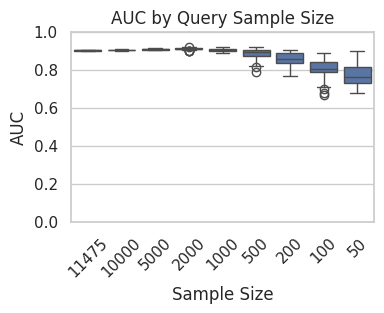

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="auc", data=metrics)
plt.title('AUC by Query Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUC")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)

plt.savefig('calcagno_subsampled_que_auc.svg')

plt.show()

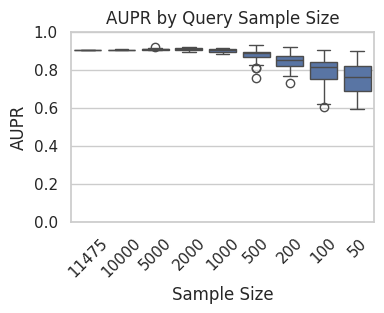

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the plot style
sns.set(style="whitegrid")

plt.figure(figsize=(4, 3))
sns.boxplot(x='sample_size', y="aupr", data=metrics)
plt.title('AUPR by Query Sample Size')
plt.xlabel('Sample Size')
plt.ylabel("AUPR")
plt.ylim(0, 1)
plt.gca().invert_xaxis()  # Flip x-axis
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig('calcagno_subsampled_que_aupr.svg')

plt.show()